# 3D Semantic Segmentation - Prediction
---

In this notebook we will resume the best 3D semantic segmentation model and we will predict the masks of the dicom files for which the segmentation is not provided.

# Setup
---

In [1]:
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install pyjpegls
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 51.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.9 MB/s eta 0:00:00a 0:00:01


In [2]:
# Importing libraries
import os
import random
import string
import time
import csv
from tqdm import tqdm
from glob import glob
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndi
import seaborn as sns
#sns.set_theme(style="whitegrid")

# To read dicom file
import pydicom
from pydicom import dcmread

# To read nifti file
import nibabel as nib

# Required dependencies
import gdcm
import pylibjpeg

# Monai
from monai.data import ArrayDataset, DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Compose,
    Activations,
    AsDiscrete,
    Resize,
    Zoom,
    ScaleIntensity,
    RandFlip,
    RandGridDistortion,
    RandAffine
)
from monai.utils import set_determinism, first

# Sklearn
from sklearn.model_selection import KFold

# PyTorch
import torch
import torch.nn as nn
from torch.nn.functional import one_hot

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


# Resume Configuration
---

In [3]:
# Path 
TRAIN_IMAGES_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
SEGMENTATIONS_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations'
OUTPUT_DIR = '.'

MODEL_PATH = '/kaggle/input/resume-training-output/WL7266AD_best_model'
CONFIG_PATH = '/kaggle/input/resume-training-output/WL7266AD_config.pkl'

# Load config from the pkl file
with open(CONFIG_PATH, 'rb') as f:
    config = pickle.load(f)

for k, v in config.items(): print(f'{k}: {v}')

ID: WL7266AD
spatial_size: (128, 128, 128)
prob: 0.5
k: 5
batch_size: 4
epochs: 400
lr: 0.0001
loss_weights: (0.05, 0.95)
channels: (16, 32, 64, 128, 256)
strides: (2, 2, 2, 2)
kernel_size: 3
up_kernel_size: 3
num_res_units: 2
act: PRELU
dropout: 0.0
bias: True
val_fold_idx: 1


In [4]:
# Masks to be reverted 
revert_mask = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
    ]

# Set Deterministic Training for Reproducibility
---

In [5]:
set_determinism(seed=0)

# Setting Up PyTorch for GPU Acceleration
---

In [6]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Enable cuDNN benchmark. Set to True whenever the input model does not change over training, False if, eg, some layers are deactivated
torch.backends.cudnn.benchmark = True

GPU: Tesla T4 is available.
cuda


# Function Declaration
---

In [7]:
def read_dicom_scan(folder_path):
    """ Read CT scan (dicom files) and stack the slices"""
    slices = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split(".")[0])):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(filepath)
            slices.append(ds.pixel_array)
    scan = np.stack(slices, -1).astype('float64')
    return scan


def read_nifti_file(file_path, revert_mask=revert_mask):
    """ Read nifit file segmentation"""    
    data = nib.load(file_path).get_fdata()
    shape = data.shape
    # Reorient because segmentations are done over the sagittal plane
    data = data.transpose(1, 0, 2)[::-1, :, ::-1]
    # Revert the files that have inverted sequence (from bottom to top)
    if file_path in revert_mask:
        data[:, :, ::-1]
    return data


def zoom_volume(vol, spatial_size):
    """Resize across z-axis"""
    """ NON UTILIZZATA SOSTITUITA DA RESIZE"""
    # Set the desired depth
    desired_width, desired_height, desired_depth = spatial_size
    # Get current depth
    current_depth = vol.shape[-1]
    current_width = vol.shape[0]
    current_height = vol.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    #vol = ndi.zoom(vol, (width_factor, height_factor, depth_factor), order=0, mode='constant')
    zoom_transform = Zoom(zoom=(width_factor, height_factor, depth_factor), keep_size=False)
    zoom_vol = zoom_transform(vol)
    return zoom_vol

def one_hot_encoding_multiclass_mask(mask):
    """ Binary OneHot Encoding of Multi-class masks"""
    labels = list(range(8))
    num_labels = len(labels)
    c, h, w, d = mask.shape
    enc_mask = np.zeros((num_labels, h, w, d))
    for c in range(1, num_labels):  # this loop starts from label 1 to ignore background 0
        enc_mask[c, :, :, :] = (mask == labels[c]) # 1 for the pixel belonging to that class, 0 for the rest of the pixel
        
    return enc_mask

def expand_dims(arr):
    return np.expand_dims(arr, axis=0)

def training_plot(file, output_path, config):
    """Plot Training and Validation losses, namely dice, bce (binary cross entorpy) and dice_bce"""
    # Training losses
    train_bce_dice_loss = file['train_bce_dice_loss']
    train_dice_loss = file['train_dice_loss']
    train_bce_loss = file['train_bce_loss']
    # Validation losses
    val_bce_dice_loss = file['val_bce_dice_loss']
    val_dice_loss = file['val_dice_loss']
    val_bce_loss = file['val_bce_loss']
    
    epochs = range(1, len(train_bce_dice_loss) + 1)
    
    # Plot Train Losses
    plt.plot(epochs, train_bce_dice_loss, label='train_bce_dice_loss', color='darkorange')
    plt.plot(epochs, train_dice_loss, label='train_dice_loss', color='antiquewhite', linestyle='dashed')
    plt.plot(epochs, train_bce_loss, label='train_bce_loss', color='tan', linestyle='dotted')
    
    # Plot Val Losses
    plt.plot(epochs, val_bce_dice_loss, label='val_bce_dice_loss', color='darkblue')
    plt.plot(epochs, val_dice_loss, label='val_dice_loss', color='lavender', linestyle='dashed')
    plt.plot(epochs, val_bce_loss, label='val_bce_loss', color='slateblue', linestyle='dotted')
    
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Training_plot.png'))
    plt.show()

def validation_metric_plot(file, output_path, config):
    val_dice_metric = file['val_dice_metric']
    epochs = range(1, len(val_dice_metric)+1)
    plt.plot(epochs, val_dice_metric, label='Validation Dice Metric', color='red')
    plt.title('Validation Metric')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Validation_Metric_plot.png'))
    plt.show()

def inverse_one_hot_encoding_multiclass(enc_mask):
    """ Convert OneHot Encoded mask back to Multi-class mask, 
    Use this function when postprocessing raw model output with threshold value"""
    labels = list(range(8))
    # Assuming enc_mask is of shape (num_labels, h, w, d)
    num_labels, h, w, d = enc_mask.shape
    
    # Initialize the output mask
    mask = np.zeros((h, w, d), dtype=np.int32)
    
    # Iterate over the labels and assign the label where the corresponding channel is 1
    for c in range(1, num_labels):  # ignore the background channel 0
        mask[enc_mask[c, :, :, :] == 1] = c
    
    return mask

# Dataset
---

In this section we will create a dataset with IDs and path of all CT scans not employed in model training, i.e., the test instances that are the scans for which the segmentation mask was not provided by the RSNA.

In [8]:
# Create Dataset containg ID of the dicom files used during training
df_train = pd.DataFrame()

# Store IDs of training CT scans
df_train['ID'] = os.listdir(SEGMENTATIONS_PATH)

# Remove the extension '.nii'
df_train['ID'] = df_train['ID'].apply(lambda x: x[:-4])

# Print the shape of the dataset
print(df_train.shape)

# Show the head
df_train.head()

(87, 1)


ID
0    1.2.826.0.1.3680043.780
1  1.2.826.0.1.3680043.21321
2   1.2.826.0.1.3680043.6125
3  1.2.826.0.1.3680043.30067
4  1.2.826.0.1.3680043.12833

In [9]:
# Create Dataset with all the CT scan available
df = pd.DataFrame()

# Store the ID's of all CT scans available
df['ID'] = os.listdir(TRAIN_IMAGES_PATH)

# Add complete path to reach CT scan folder in train_images
df['image_path'] = df['ID'].apply(lambda x: os.path.join(TRAIN_IMAGES_PATH, x))

# Print the shape of the dataset
print(df.shape)

# Show the head
df.head()

(2019, 2)


ID  \
0  1.2.826.0.1.3680043.17625   
1   1.2.826.0.1.3680043.3850   
2   1.2.826.0.1.3680043.2286   
3  1.2.826.0.1.3680043.14435   
4   1.2.826.0.1.3680043.3442   

                                          image_path  
0  /kaggle/input/rsna-2022-cervical-spine-fractur...  
1  /kaggle/input/rsna-2022-cervical-spine-fractur...  
2  /kaggle/input/rsna-2022-cervical-spine-fractur...  
3  /kaggle/input/rsna-2022-cervical-spine-fractur...  
4  /kaggle/input/rsna-2022-cervical-spine-fractur...

In [10]:
# Left join between df and df_train to isolate the unseen CT scans
df_test = df.merge(df_train, on='ID', how='left', indicator=True)

# Count the number of training CT scan and test CT scan
df_test['_merge'].value_counts()

_merge
left_only     1932
both            87
right_only       0
Name: count, dtype: int64

In [11]:
# Filter rows where the indicator is "left_only"
df_test = df_test[df_test['_merge'] == 'left_only']

# Drop the indicator column if you don't need it
df_test = df_test.drop(columns=['_merge'])

df_test.shape

(1932, 2)

# Transforms 
---

In [12]:
# Define transforms for images
test_image_trans = Compose(
    [   # Load Data
        read_dicom_scan,
        # Data Preparation
        expand_dims, 
        Resize(spatial_size=config['spatial_size'], mode="area"), # Resize the volume to target spatial_size
        ScaleIntensity() # Scale between (0,1)
    ]
)

# Define dataset and dataloader
test_ds = ArrayDataset(df_test.image_path, test_image_trans)

test_loader = DataLoader(test_ds, 
                        batch_size=config['batch_size'], 
                        shuffle=False,
                        num_workers=2
                       )

# Instantiate Model
---

In [13]:
# Create Model with UNet architecture
model = UNet(spatial_dims=3, # (Height, Width, Depth)
             in_channels=1,  
             out_channels=8, # 8 binary mask 7 as the vertebrae(C1->C7) + background
             channels=config['channels'], 
             strides=config['strides'], 
             kernel_size=config['kernel_size'], 
             up_kernel_size=config['up_kernel_size'], 
             num_res_units=config['num_res_units'], 
             act=config['act'], 
             dropout=config['dropout'], 
             bias=config['bias']
            ).to(device)

# Define the transforms to apply to model prediction, Softmax because multiclass segmentation problem
post_trans = Compose([Activations(sigmoid=False, softmax=True, dim=0), 
                      AsDiscrete(argmax=True, dim=0)])

# Resume Best Model
---

In [14]:
# Resume state from checkpoint
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

# Set model in evaluation mode
model.eval()

/tmp/ipykernel_36/1415127588.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

# Prediction
---

In [15]:
# We used the trained model to obtain the segmentation mask of the unseen CT scans.
with torch.no_grad():
    # Take first batch of data
    test_patients = first(test_loader)
    test_patients = test_patients.to(device)
    # Predict mask
    test_outputs = model(test_patients)
    # Post process the raw output of the model
    test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


# Reconstruct Segmentation Mask
---

In [18]:
patient = 3

patient_scan = test_patients[patient].cpu()

mask = test_outputs[patient].cpu()

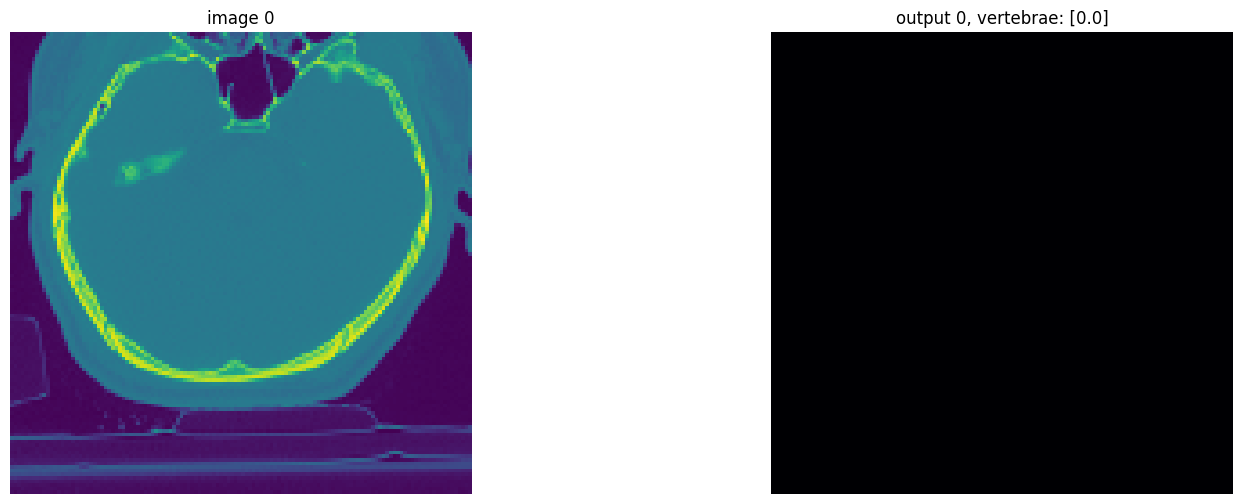

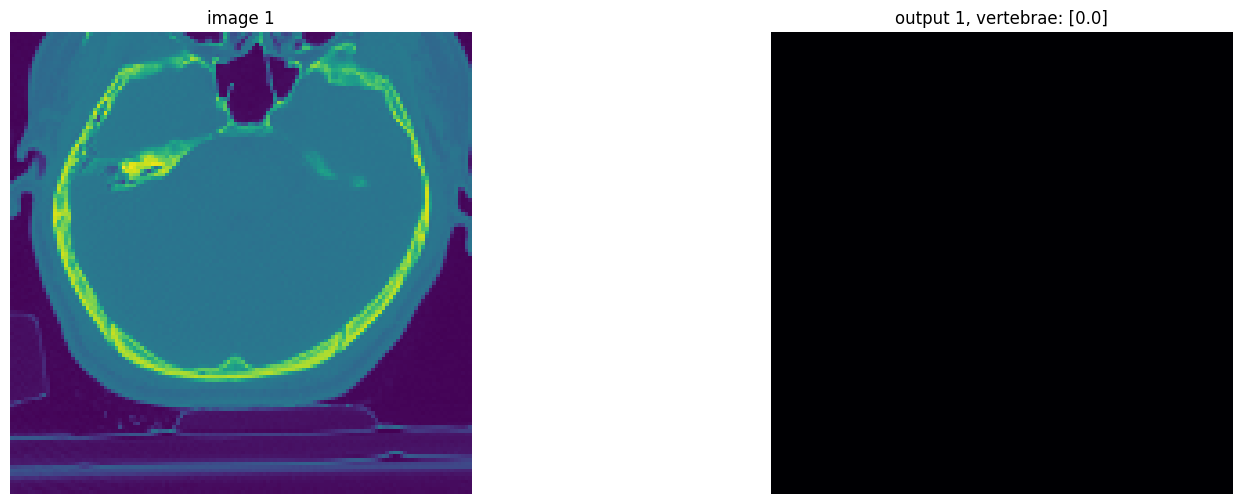

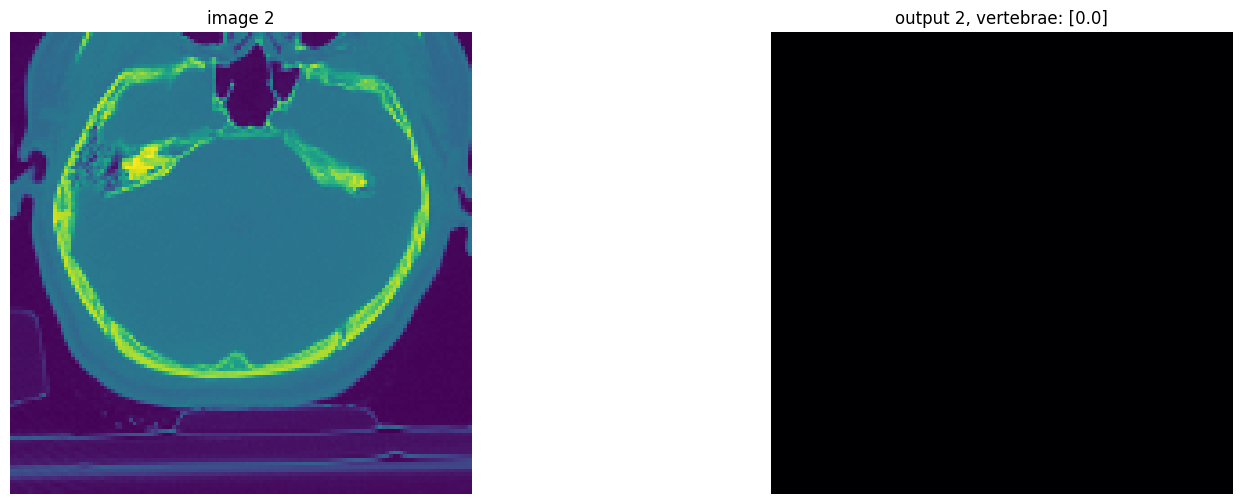

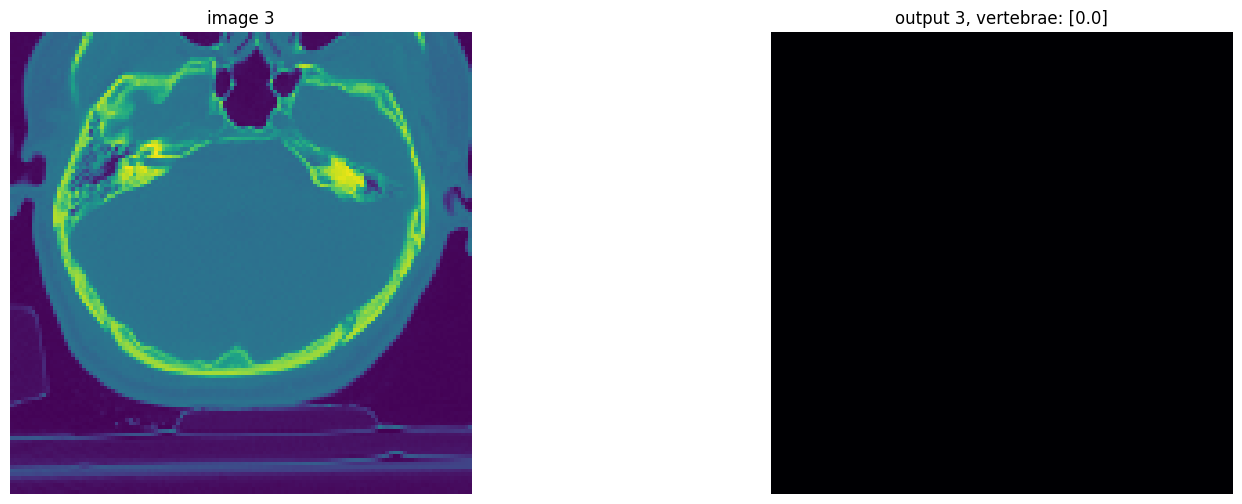

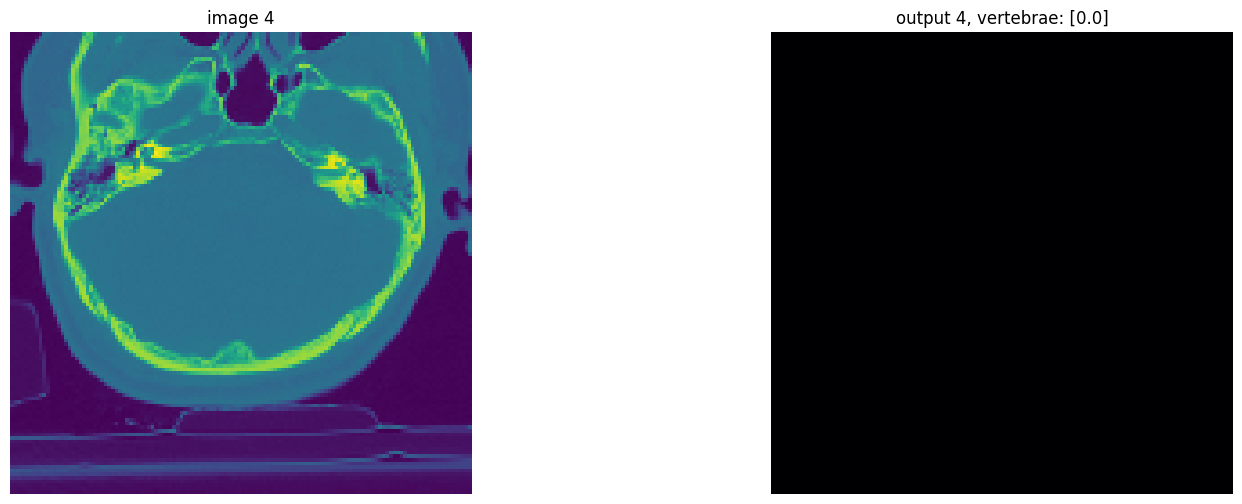

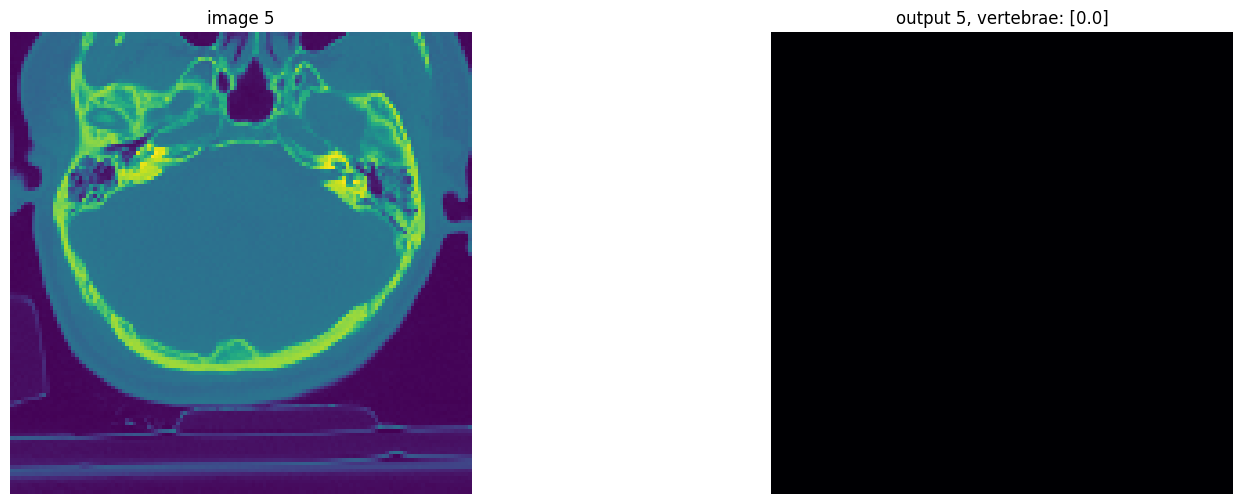

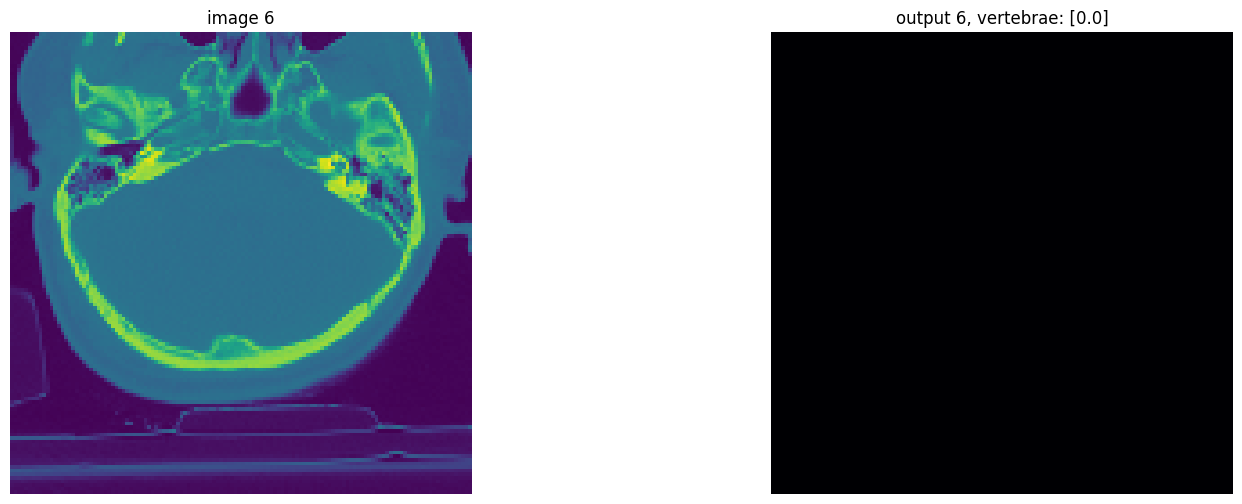

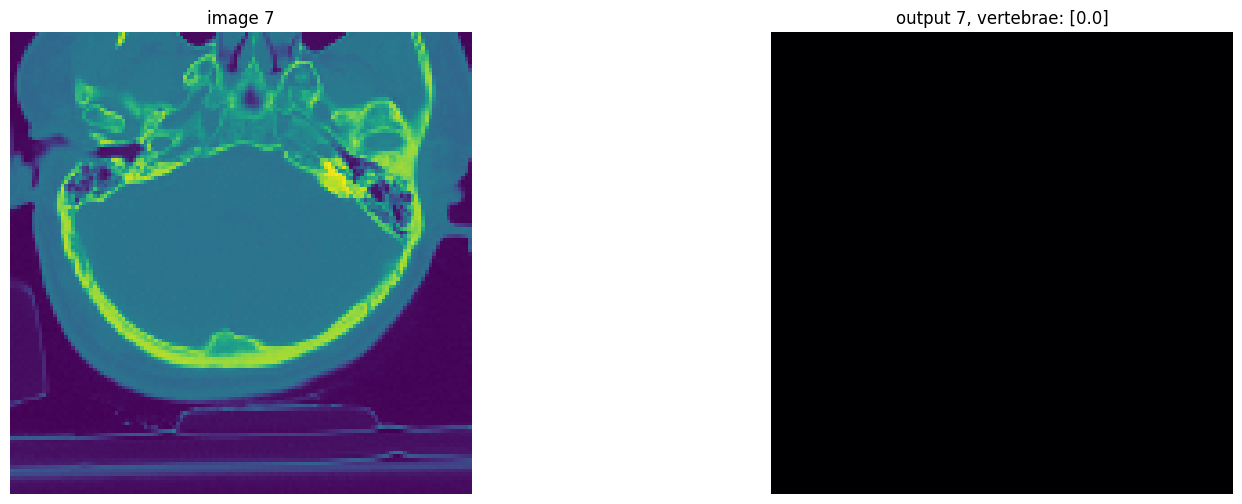

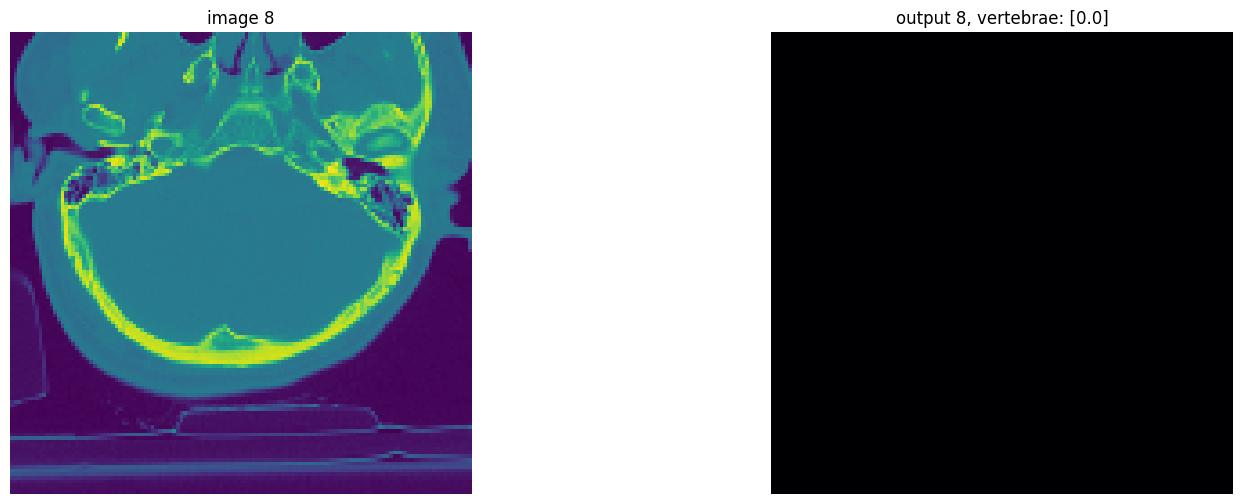

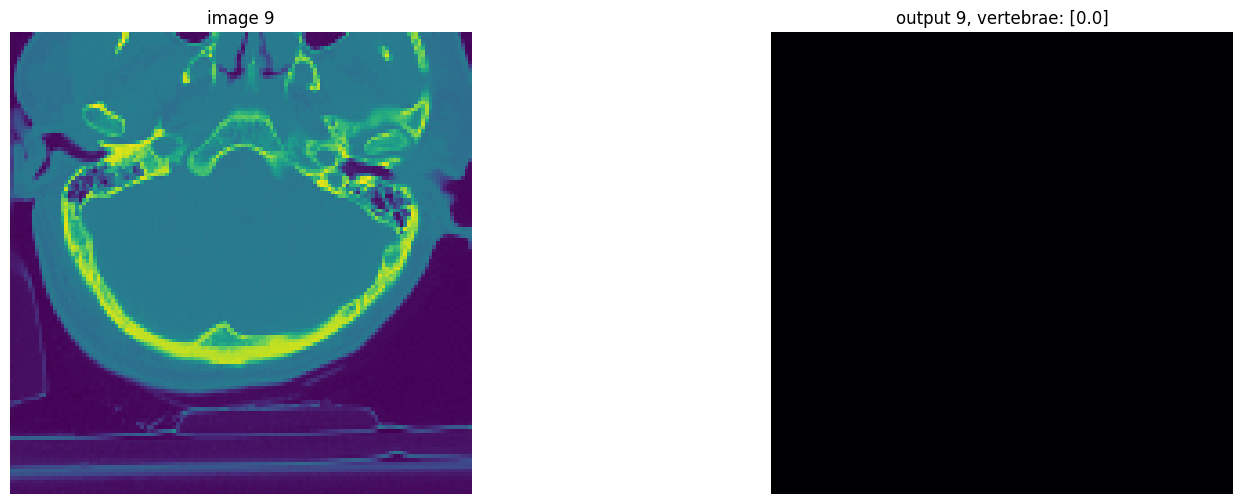

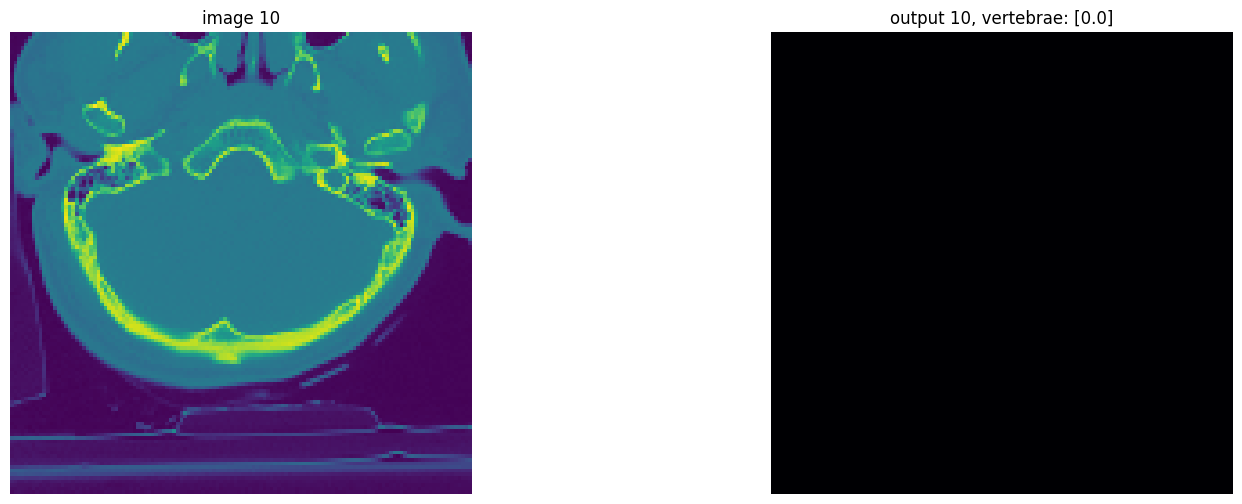

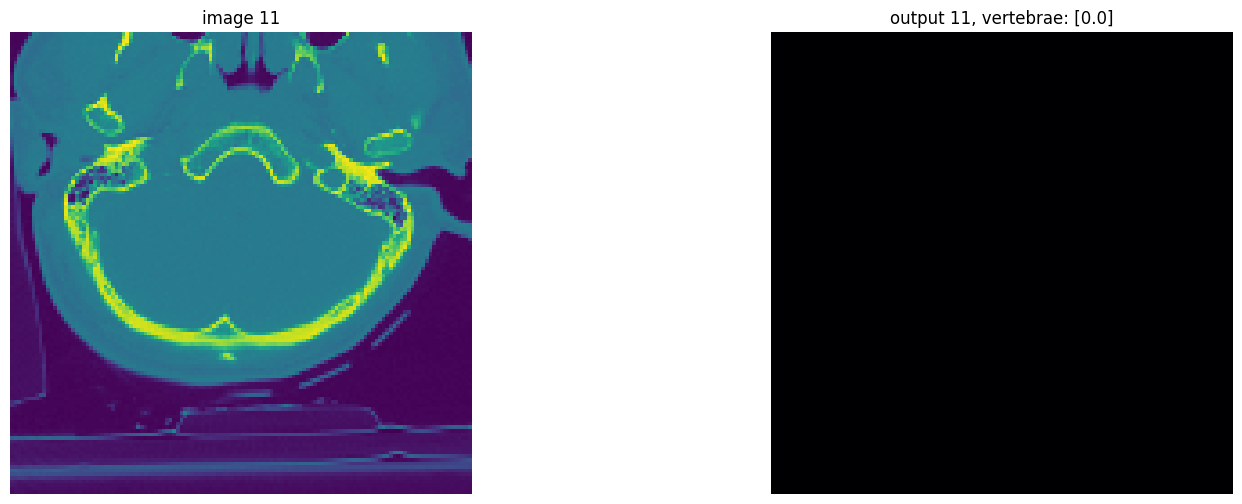

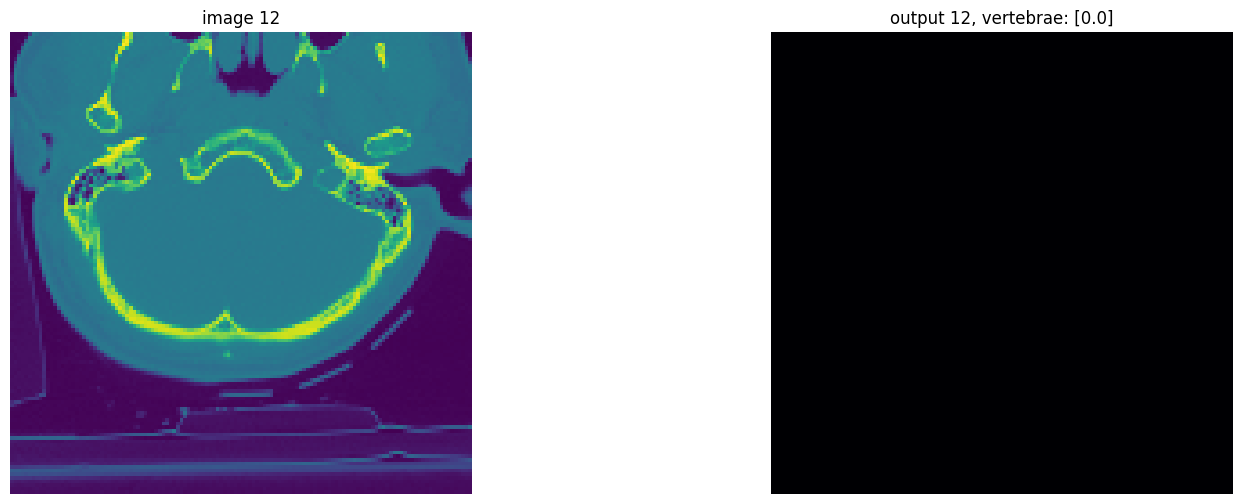

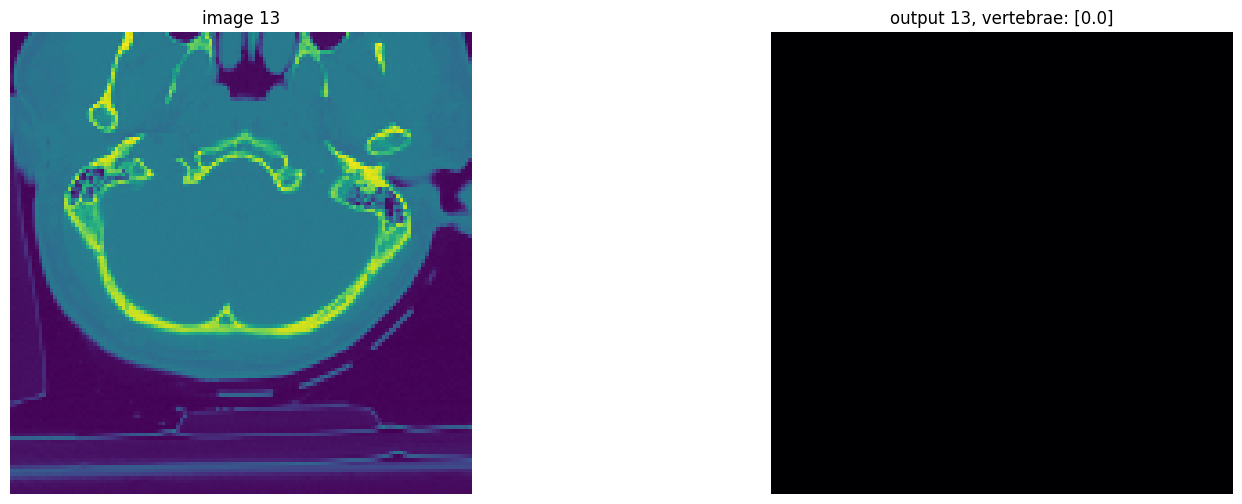

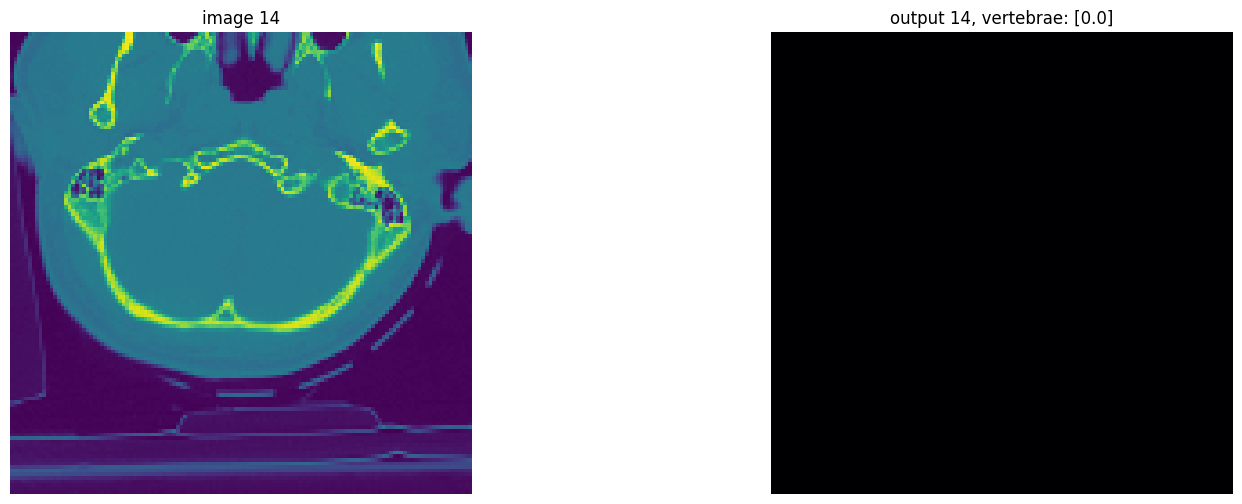

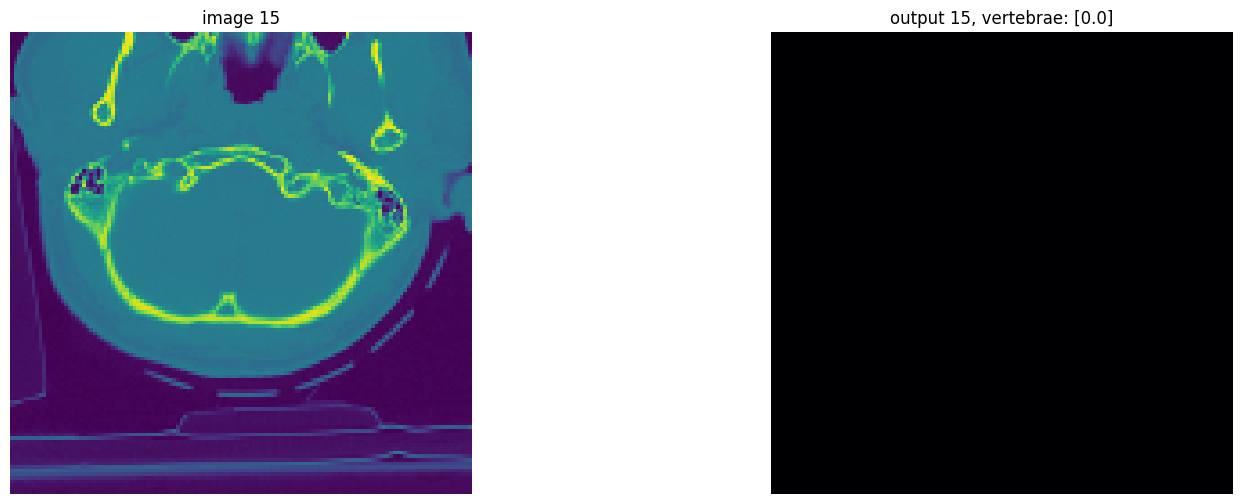

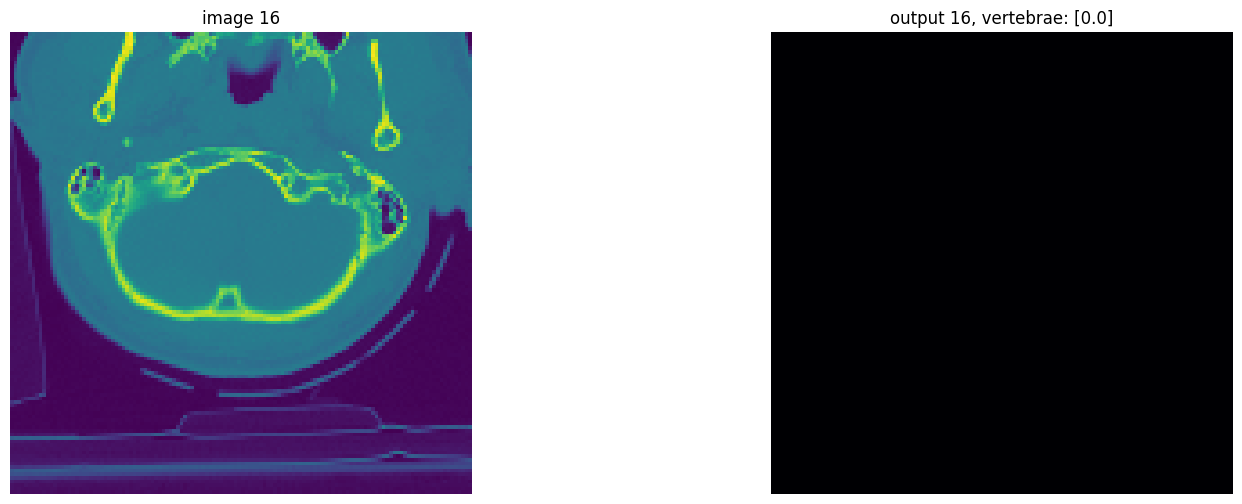

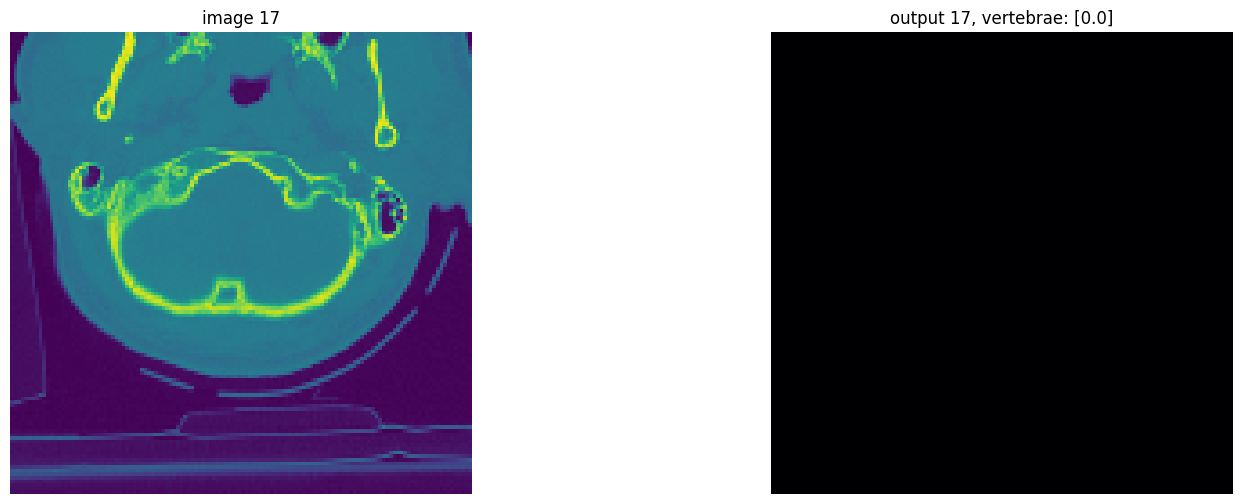

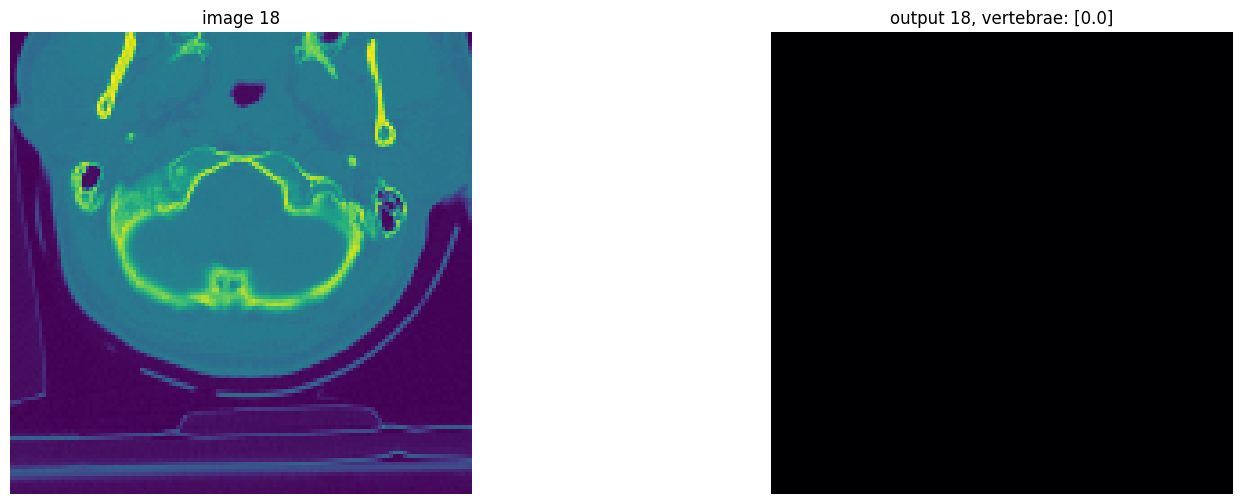

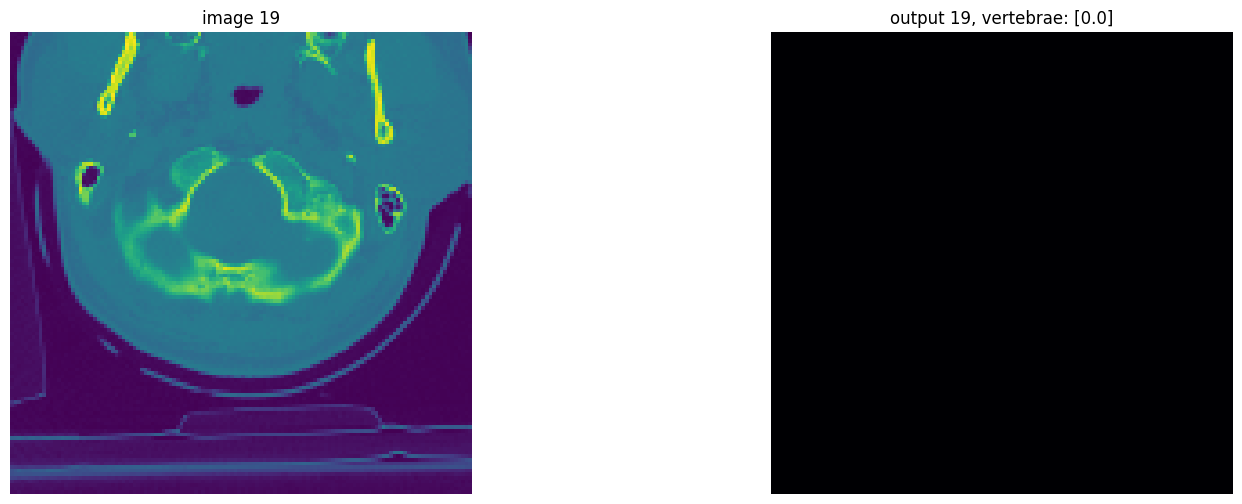

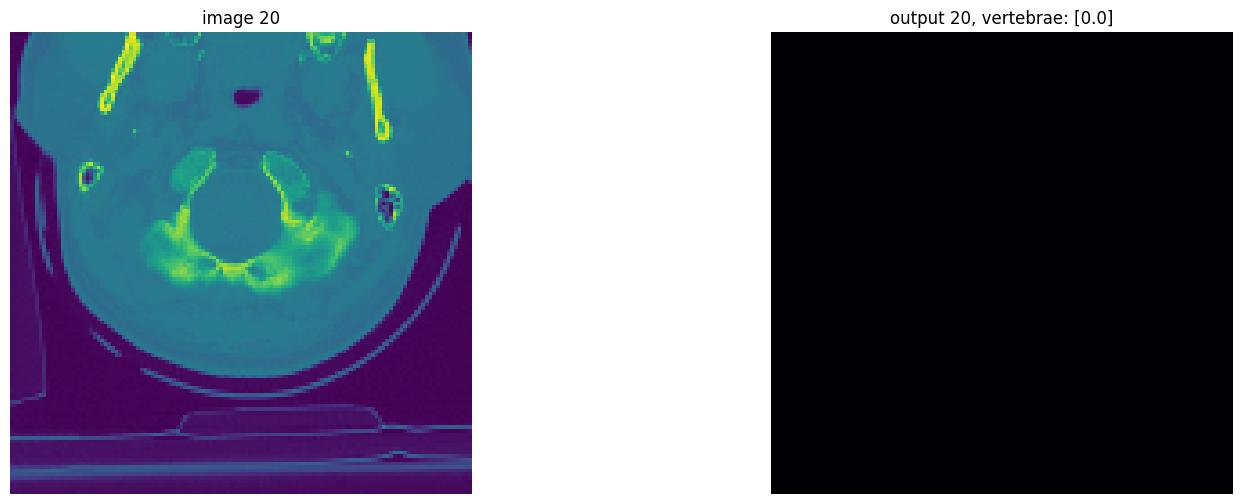

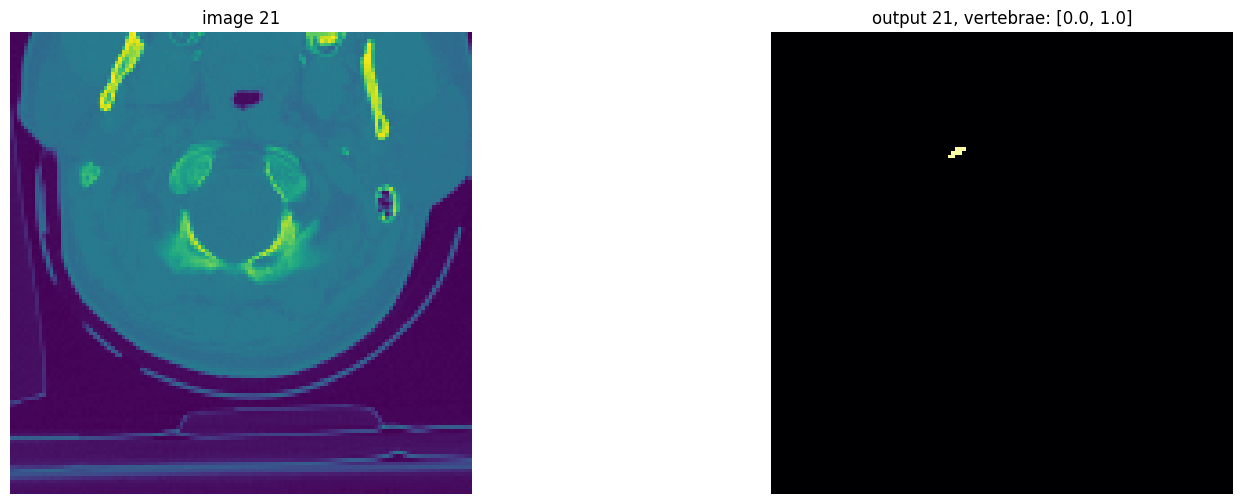

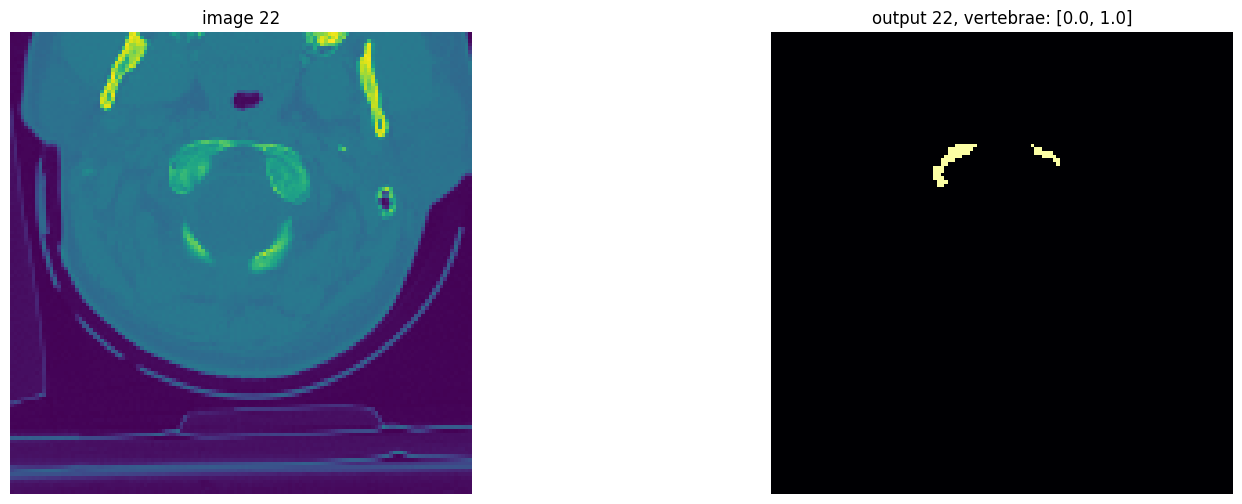

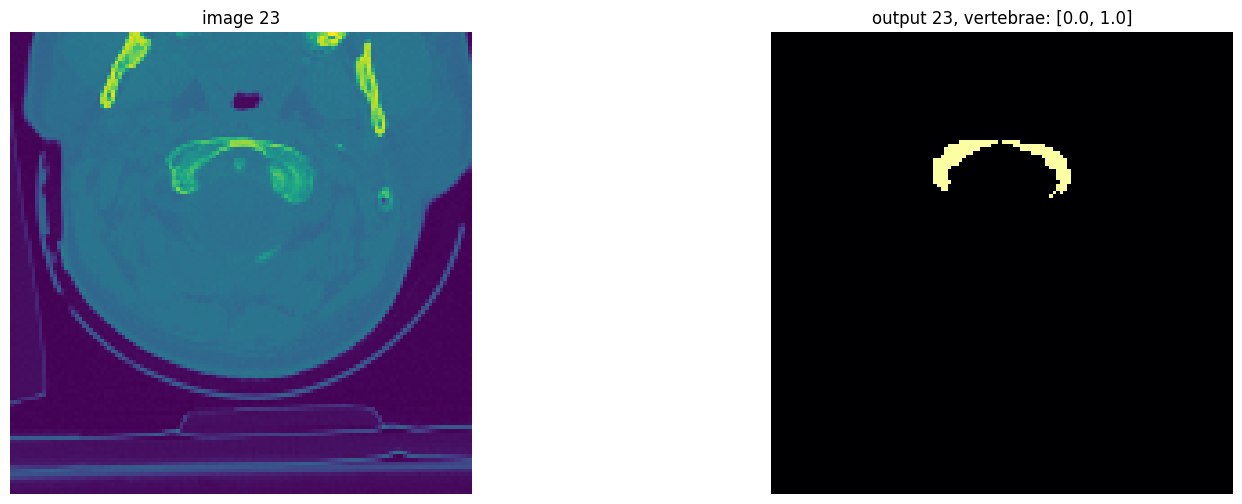

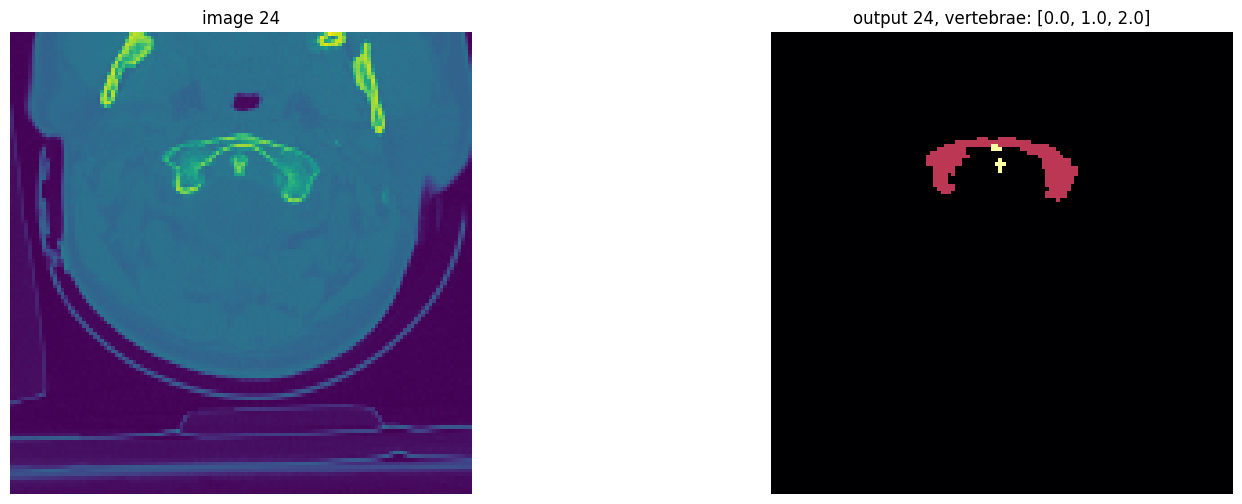

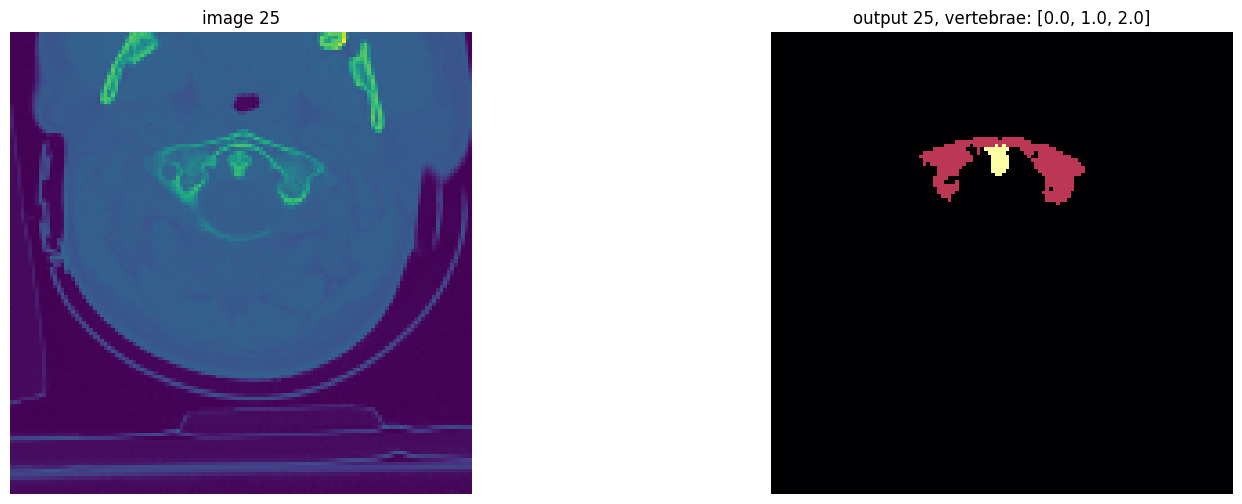

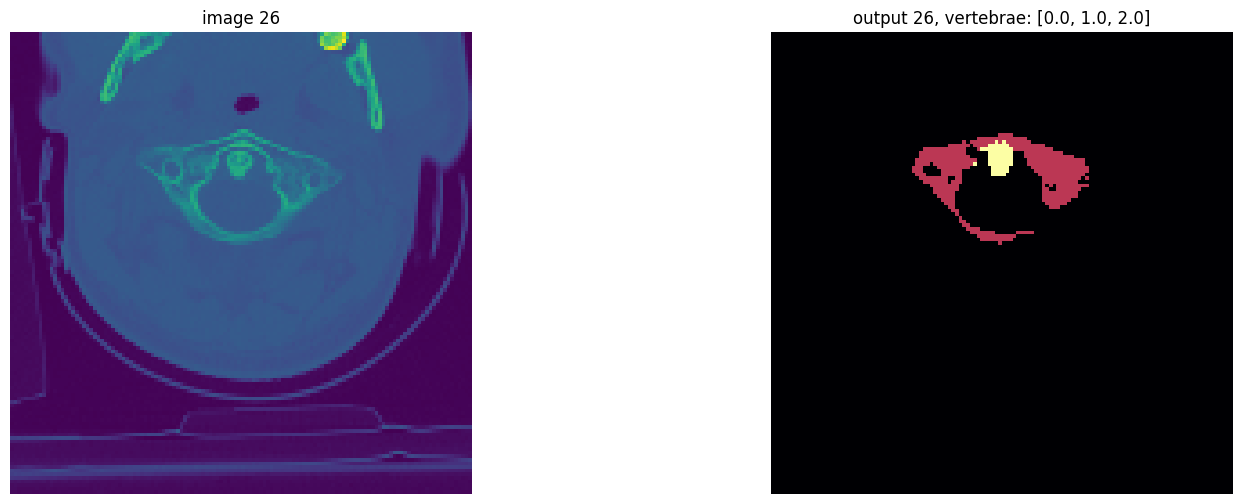

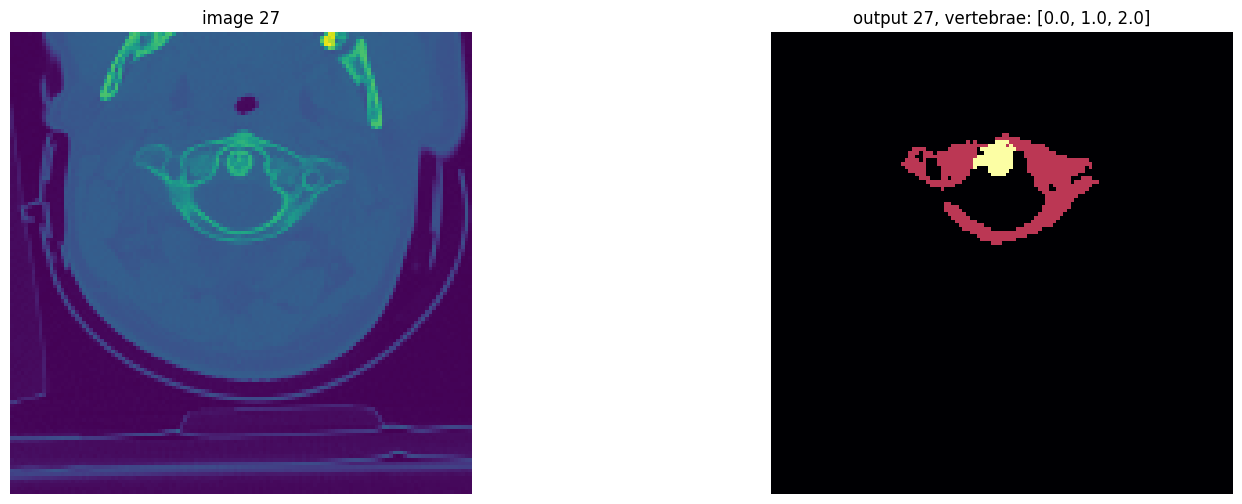

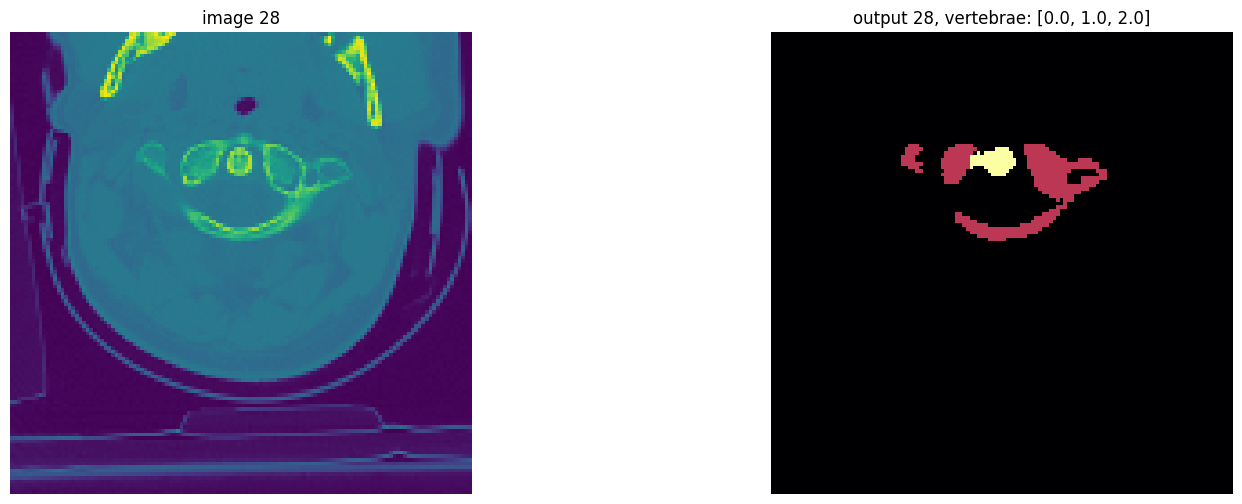

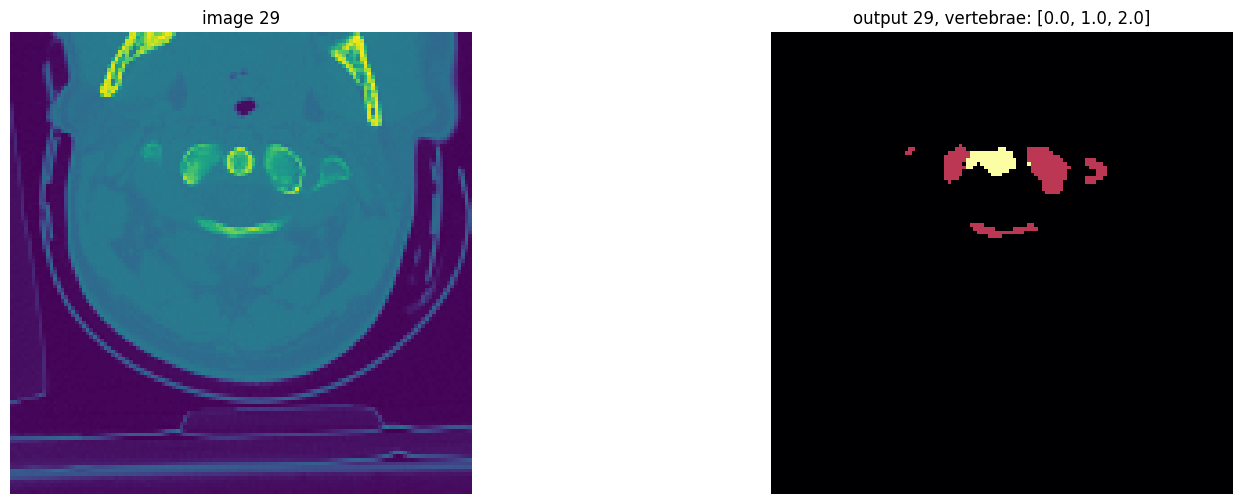

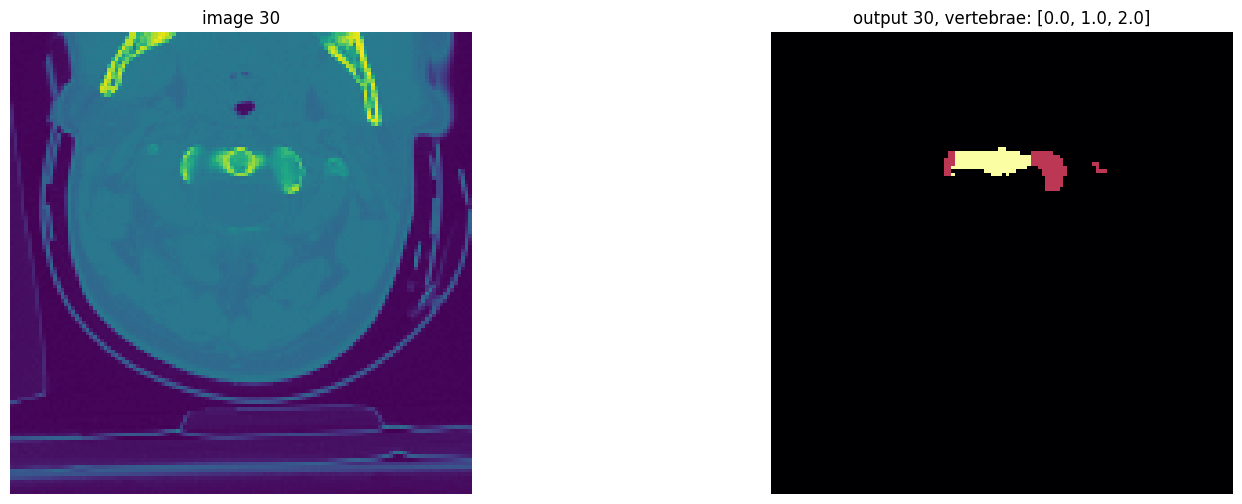

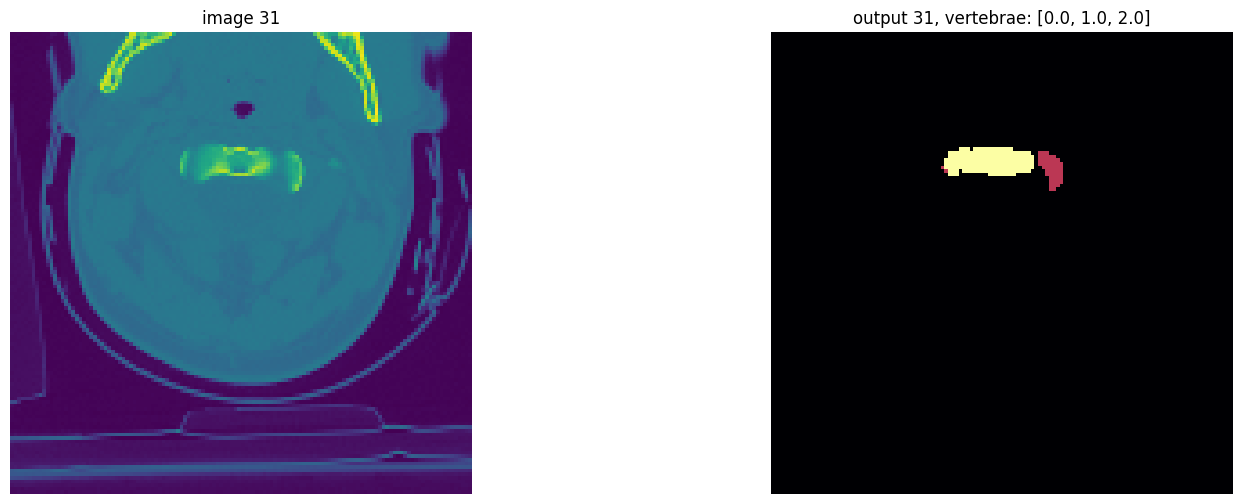

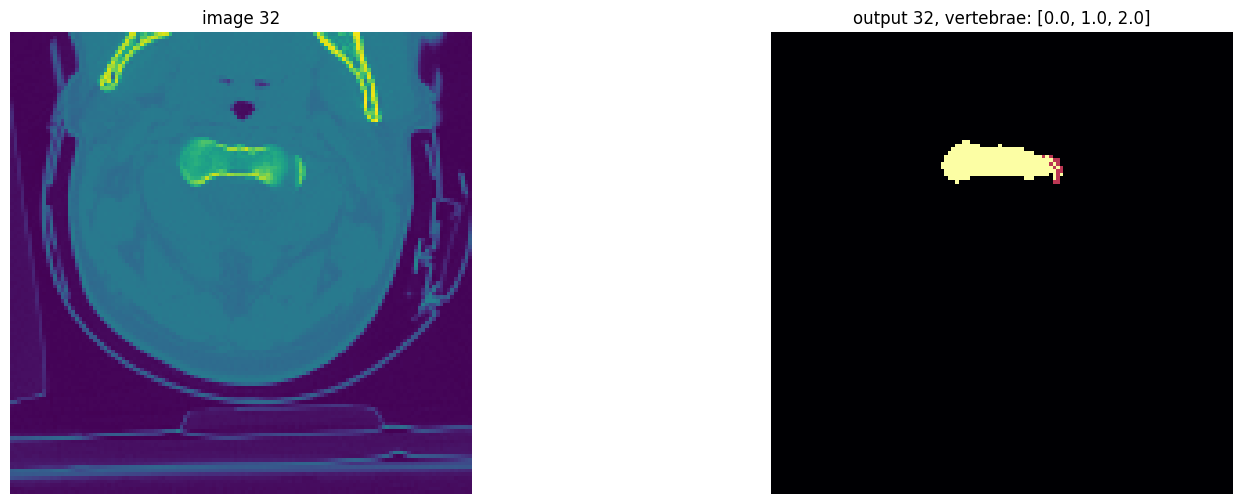

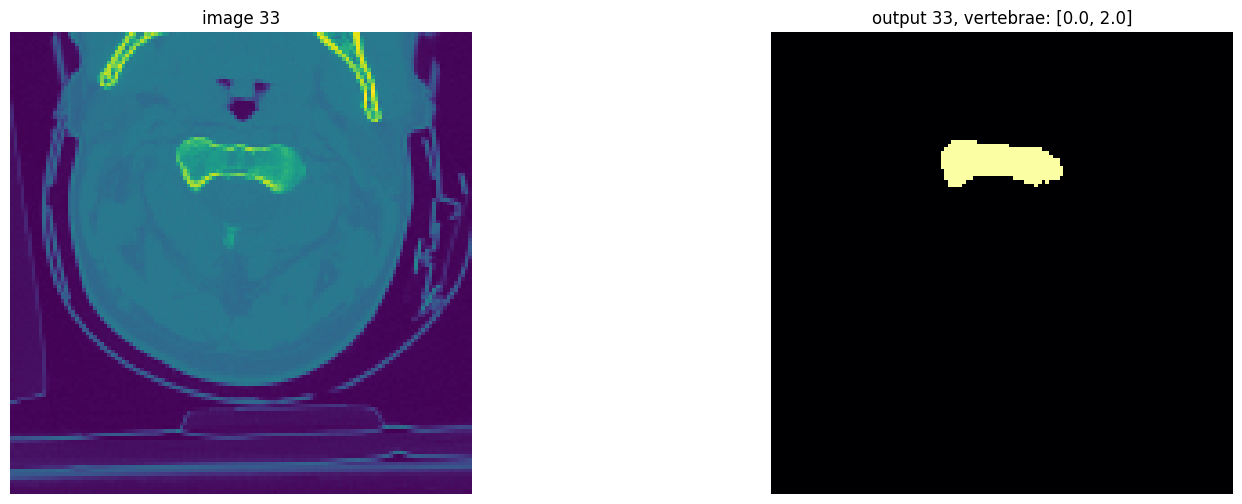

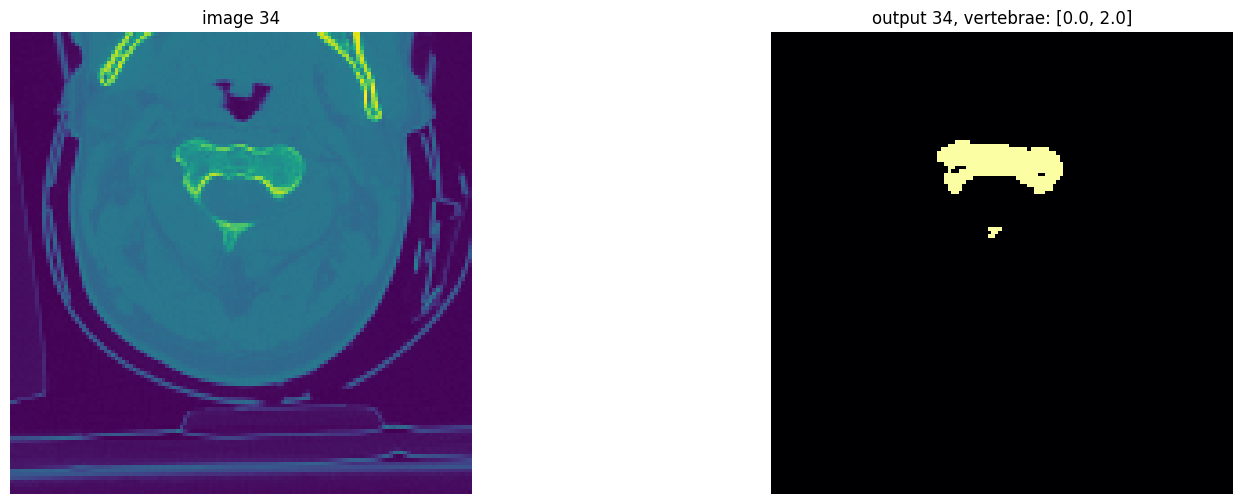

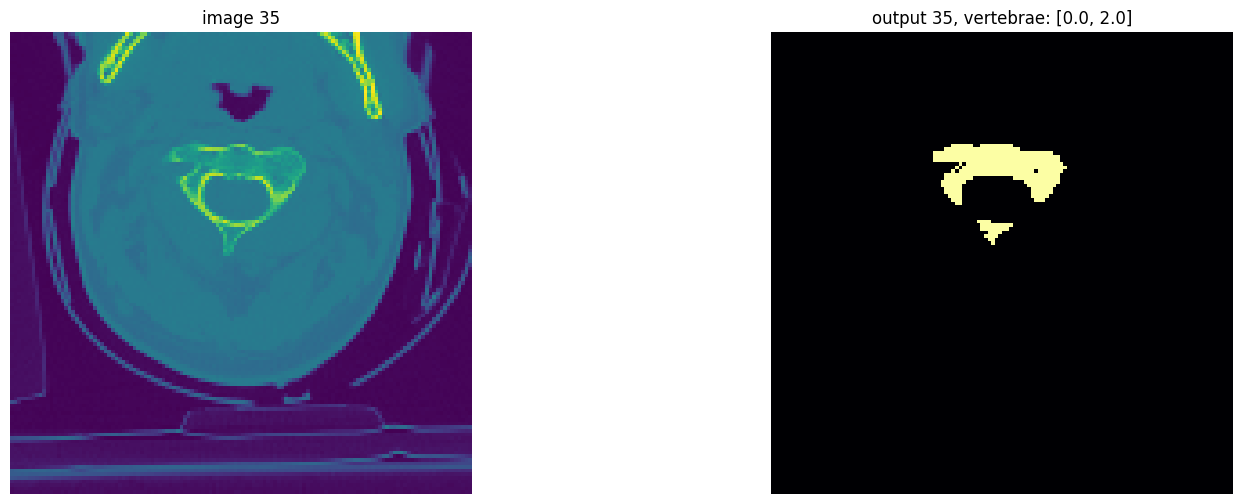

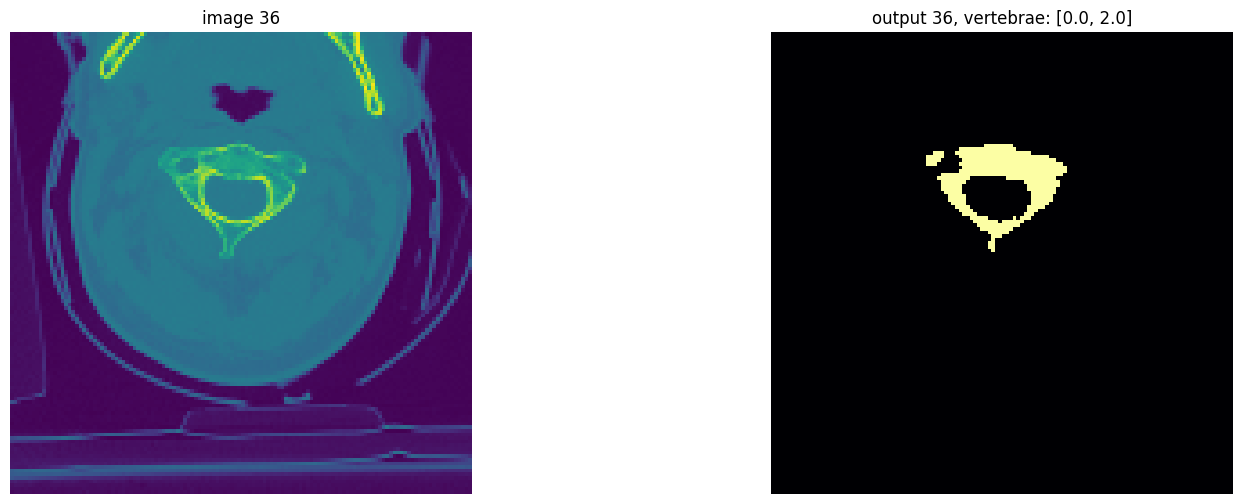

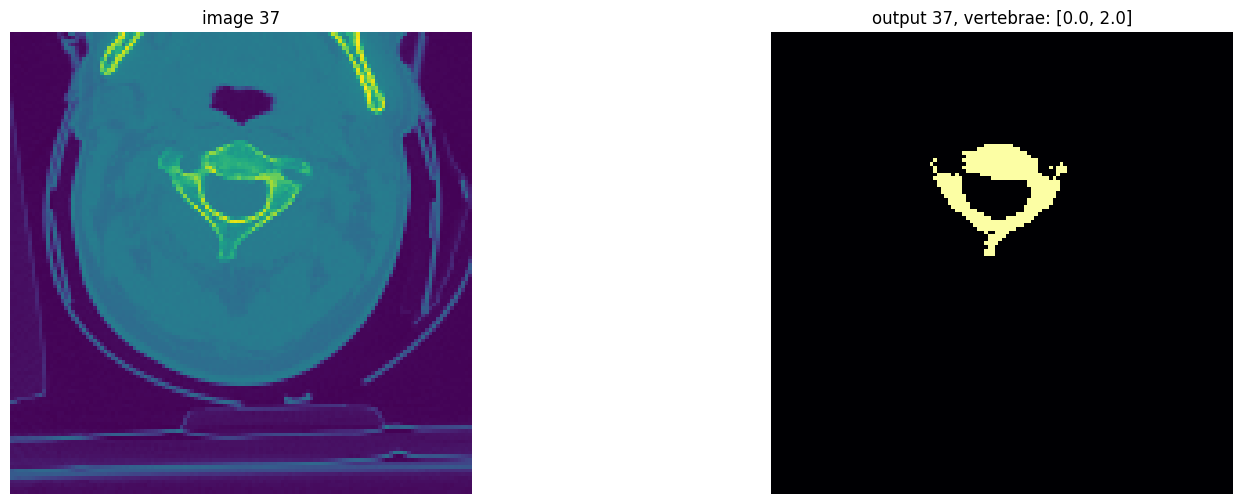

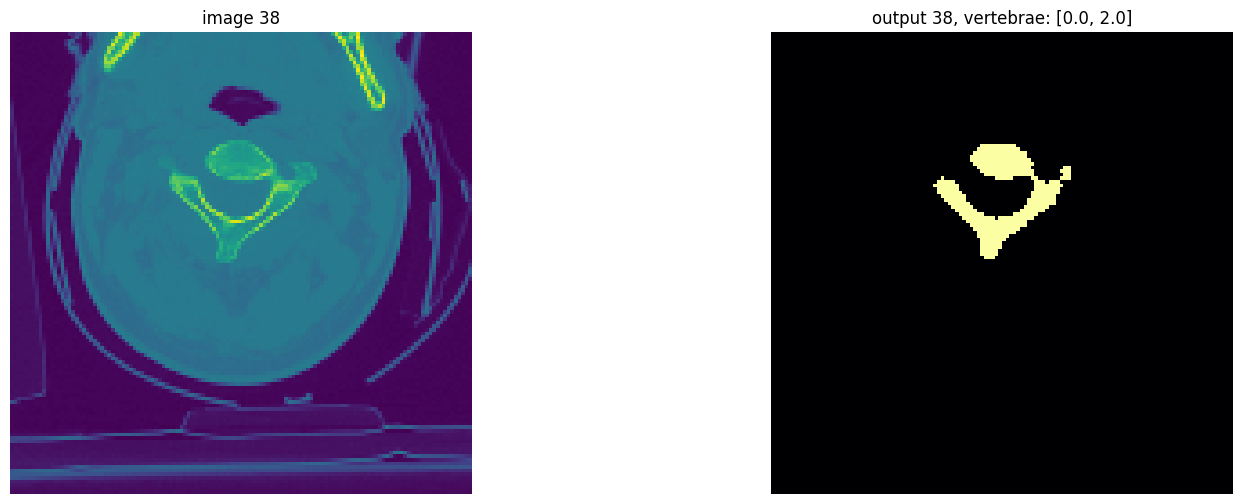

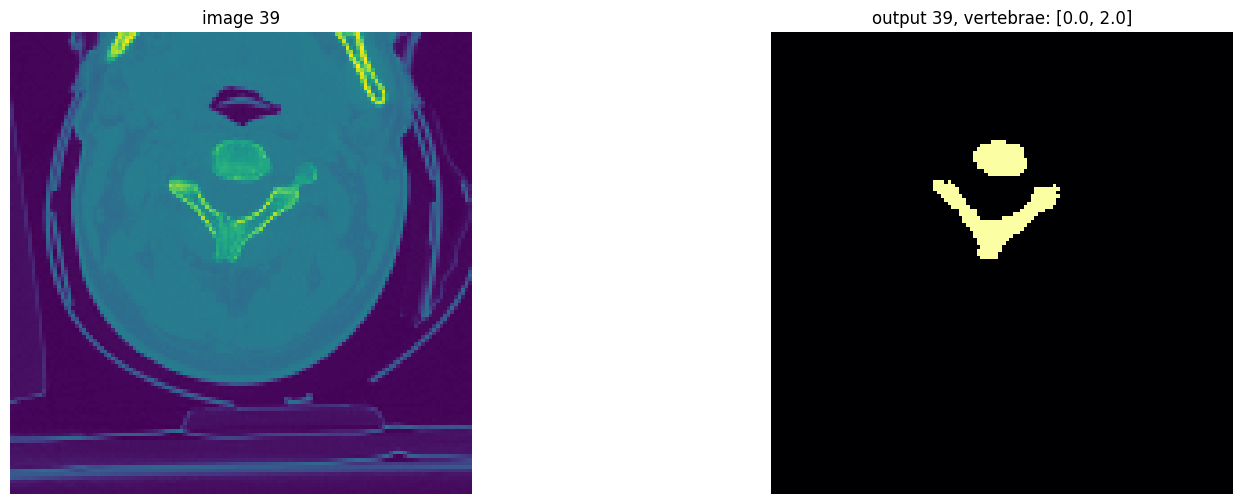

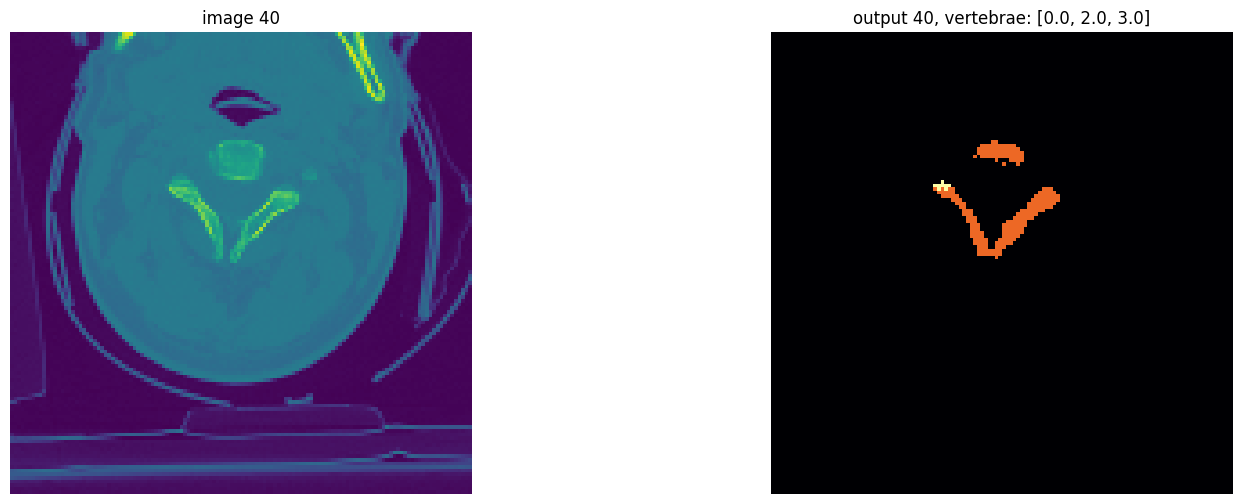

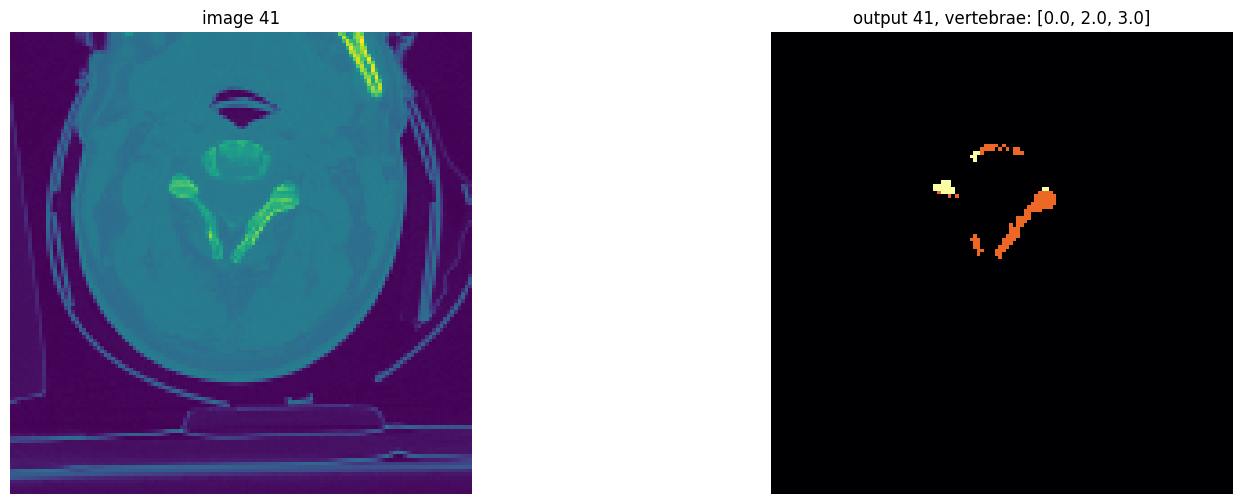

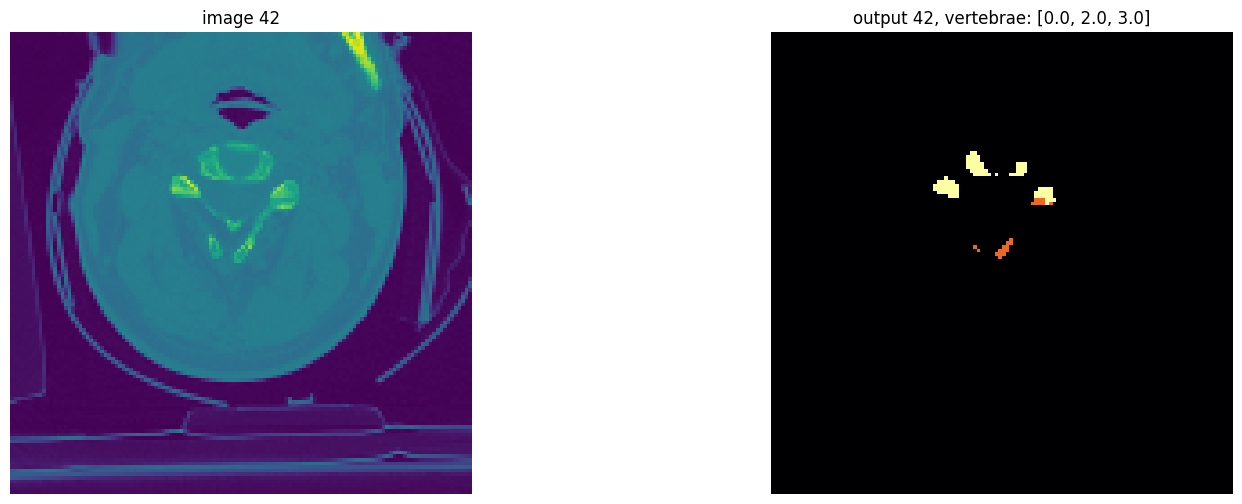

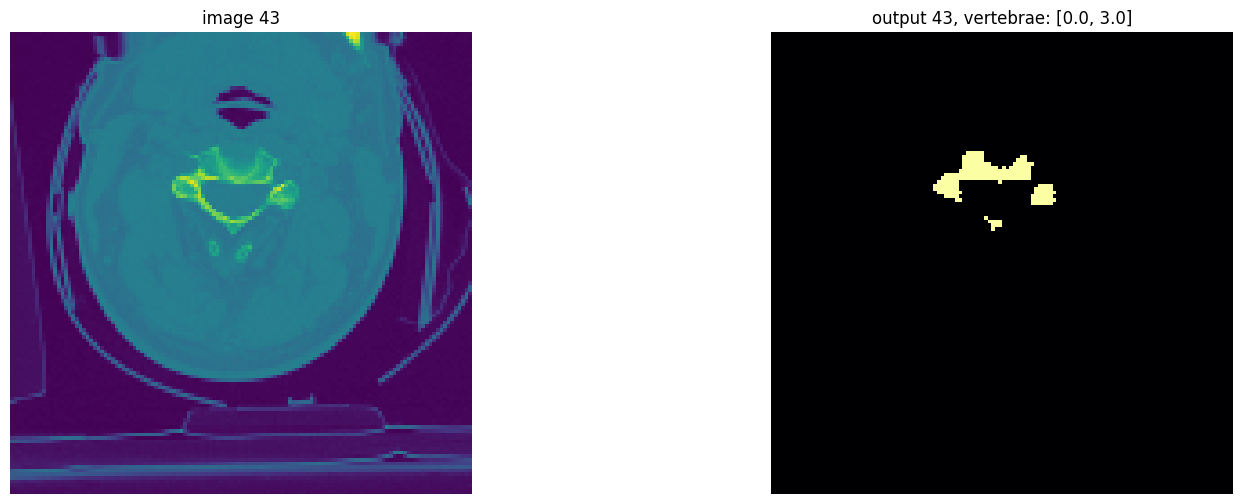

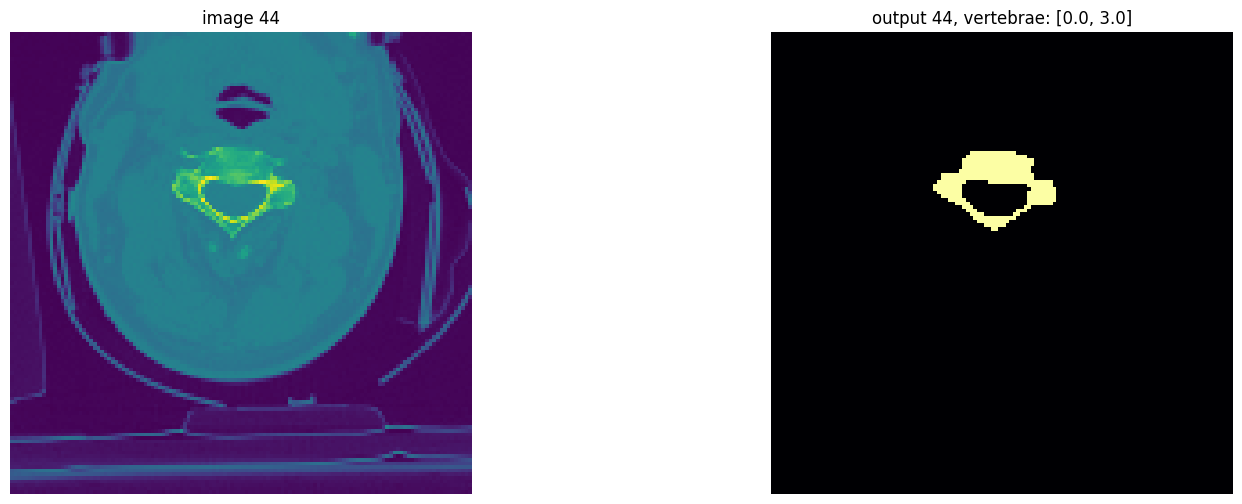

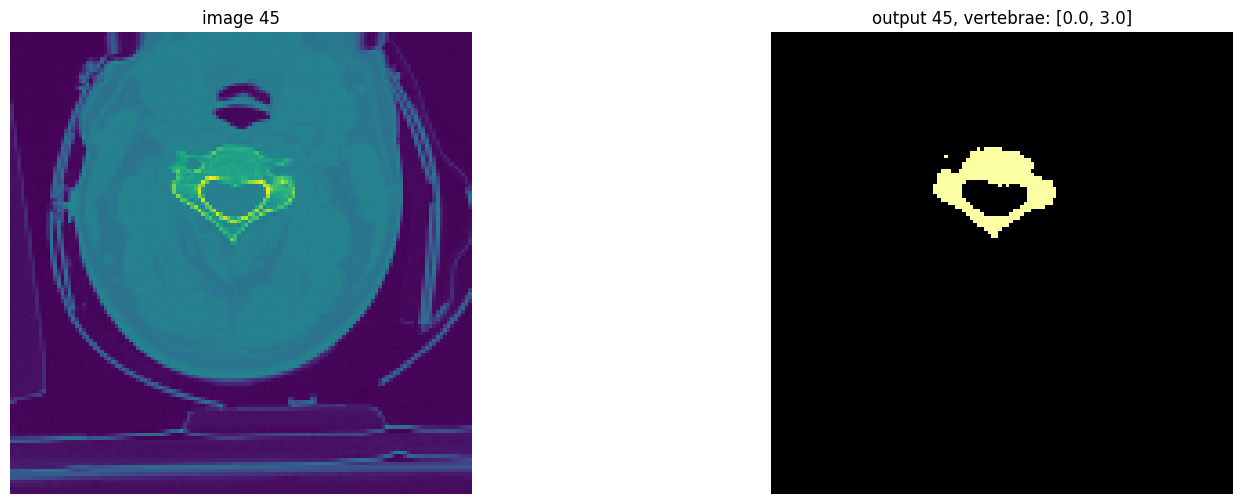

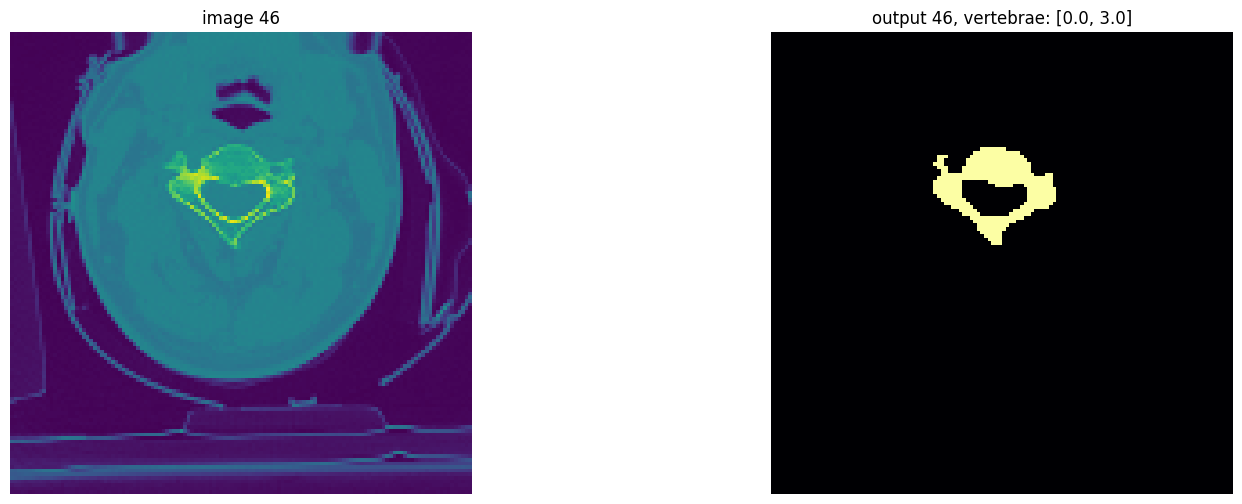

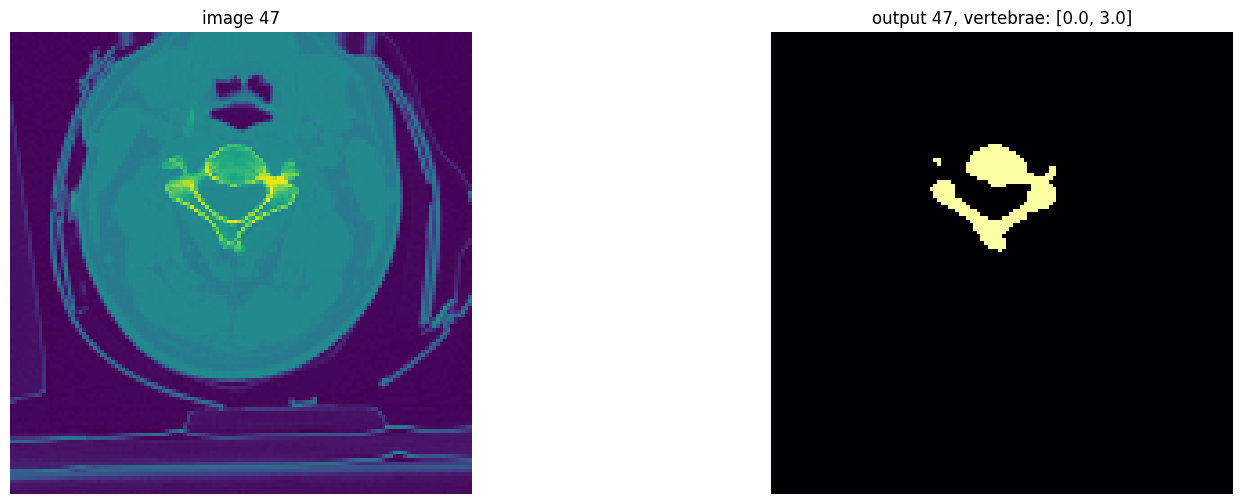

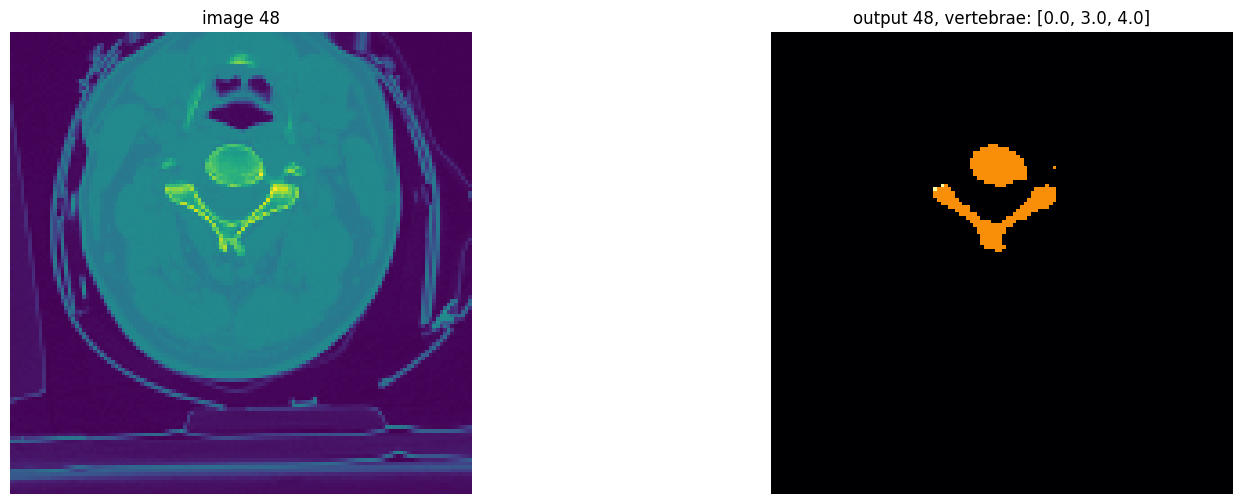

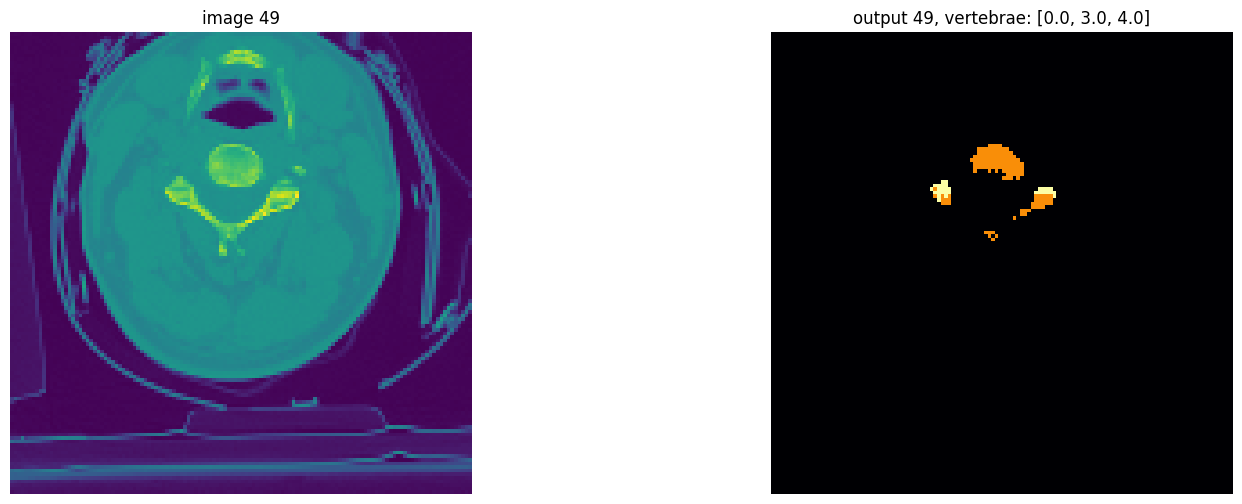

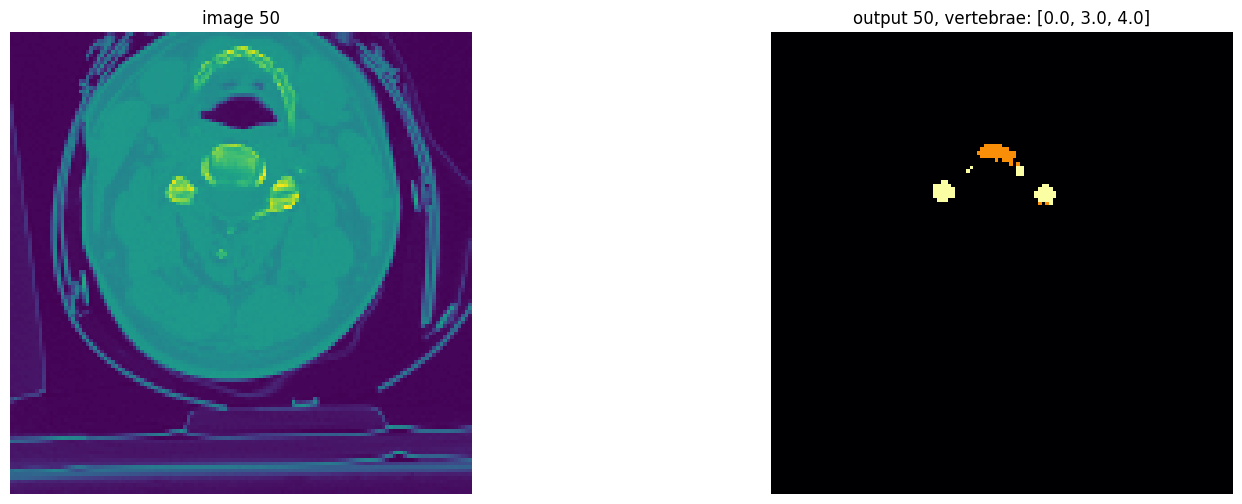

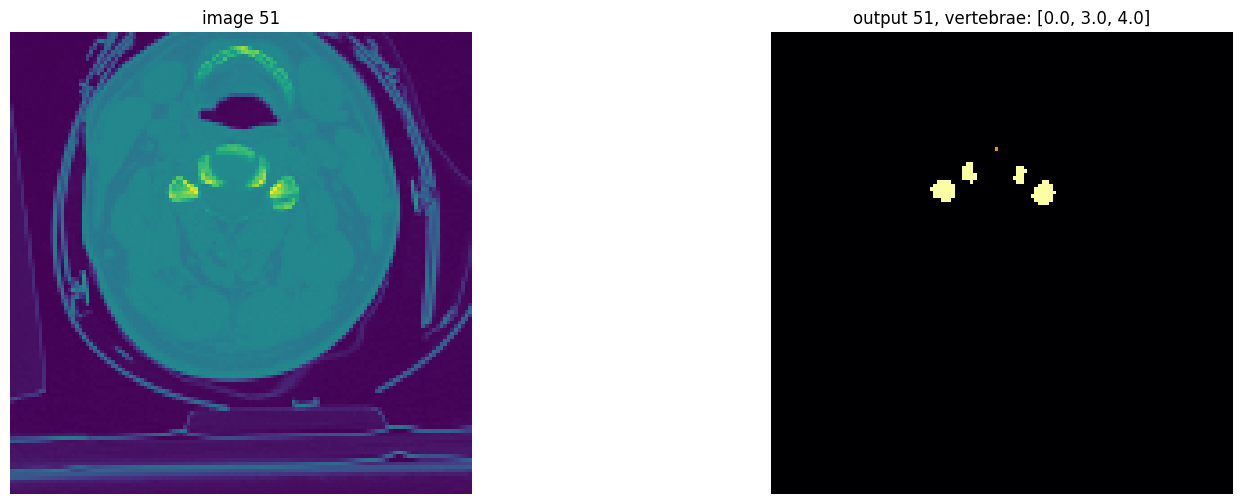

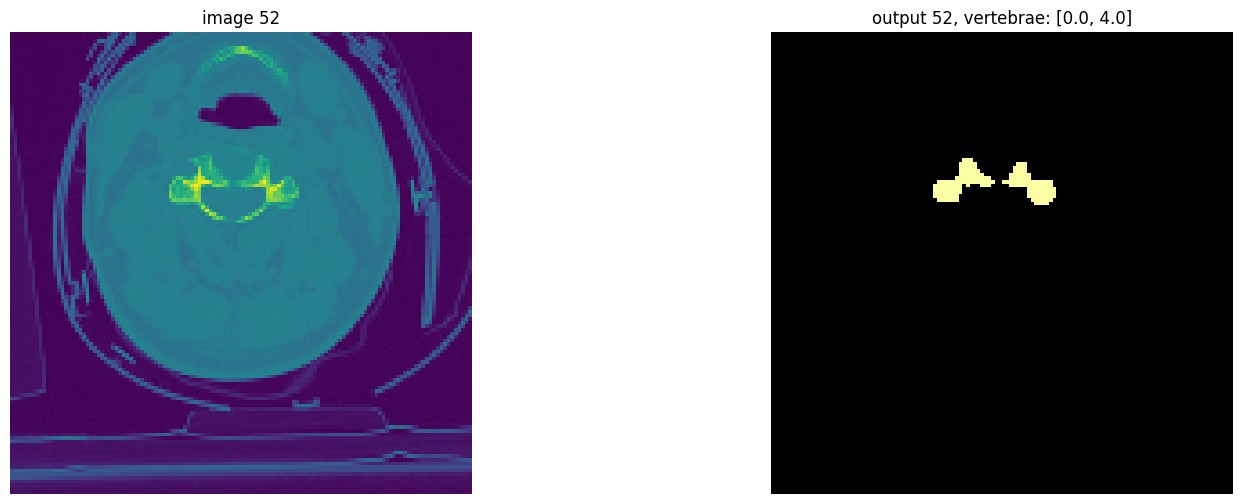

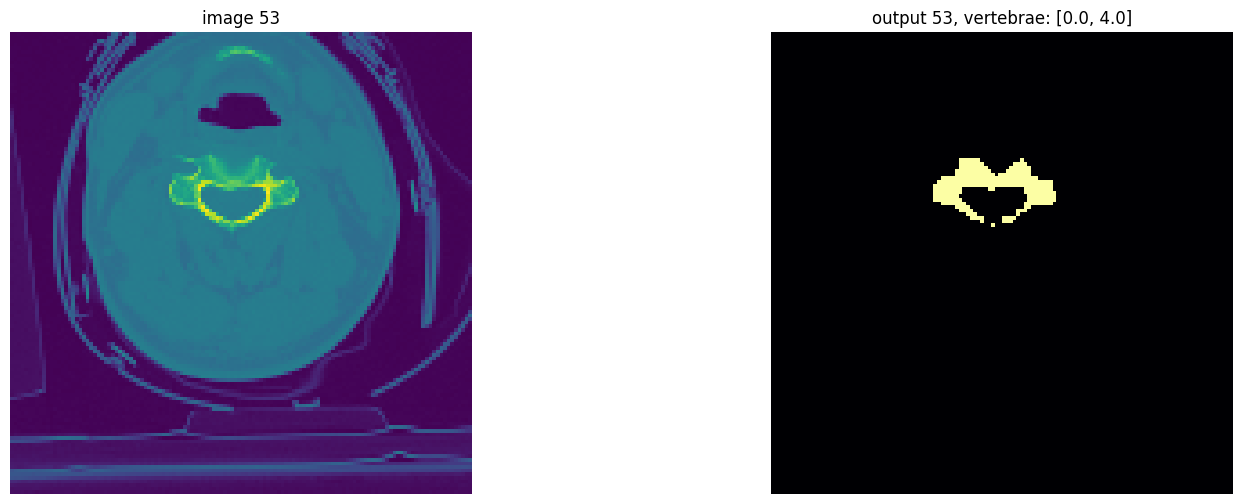

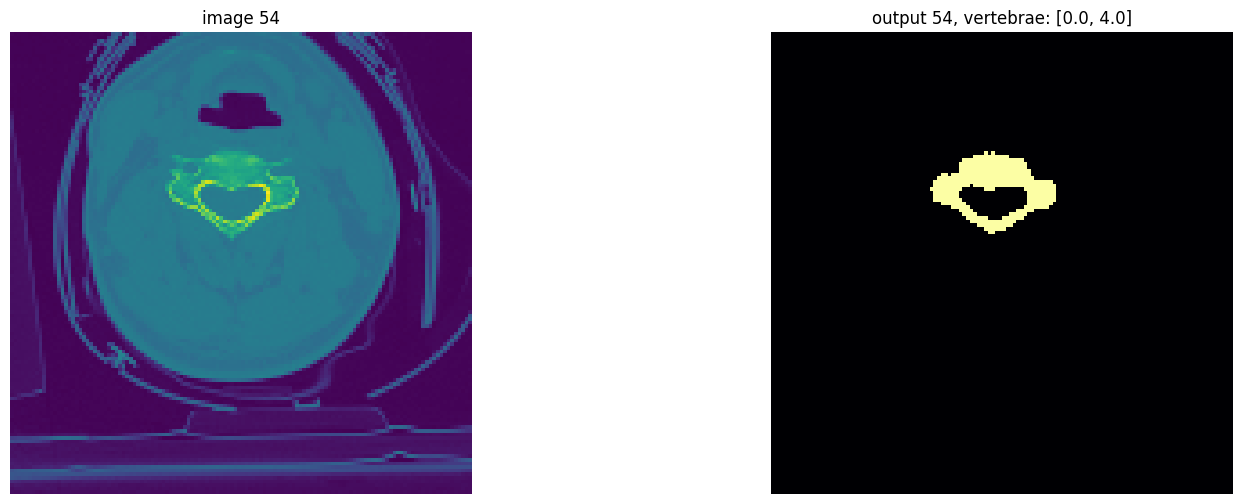

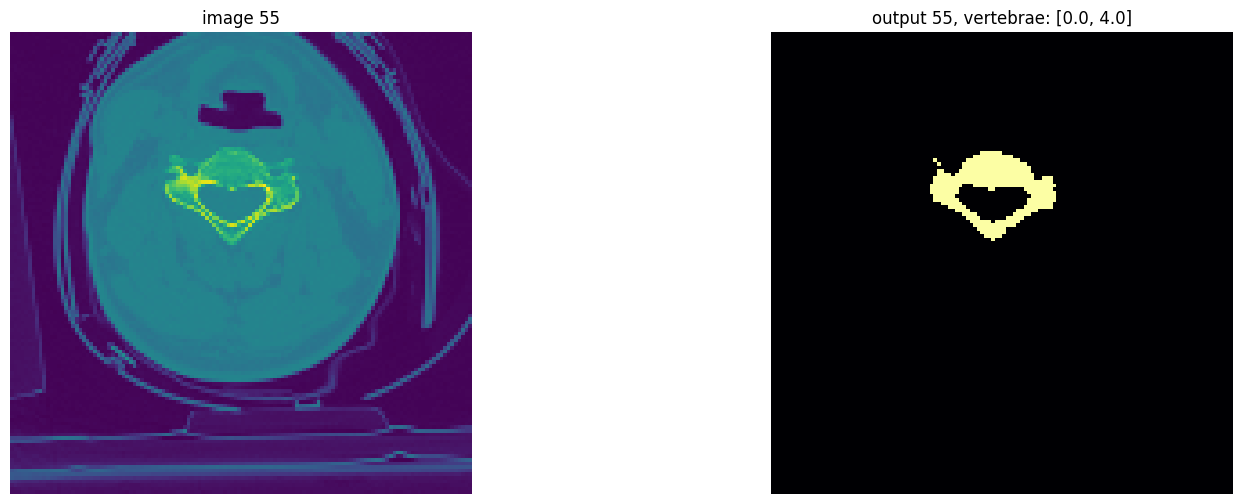

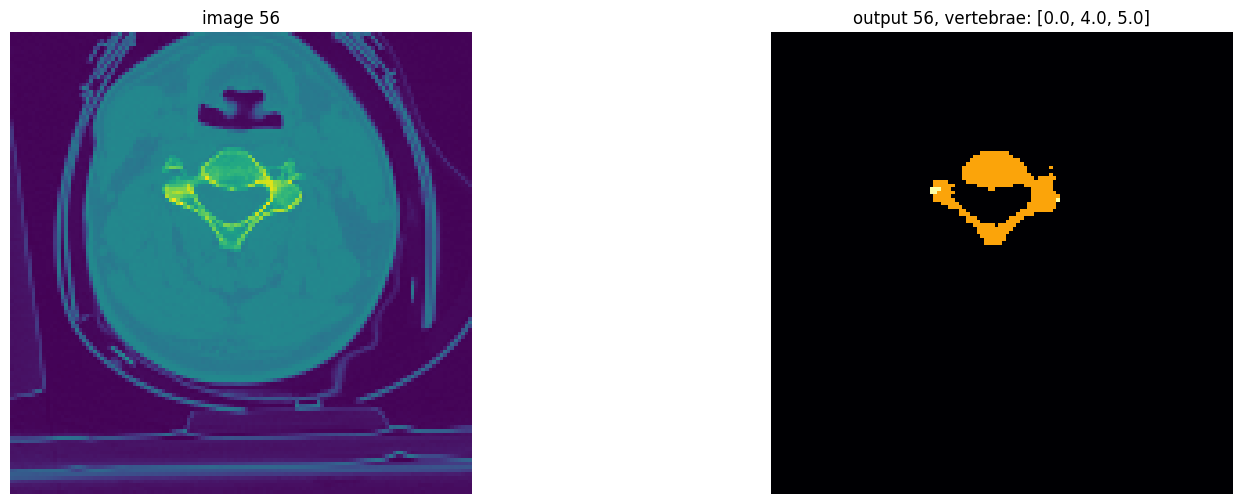

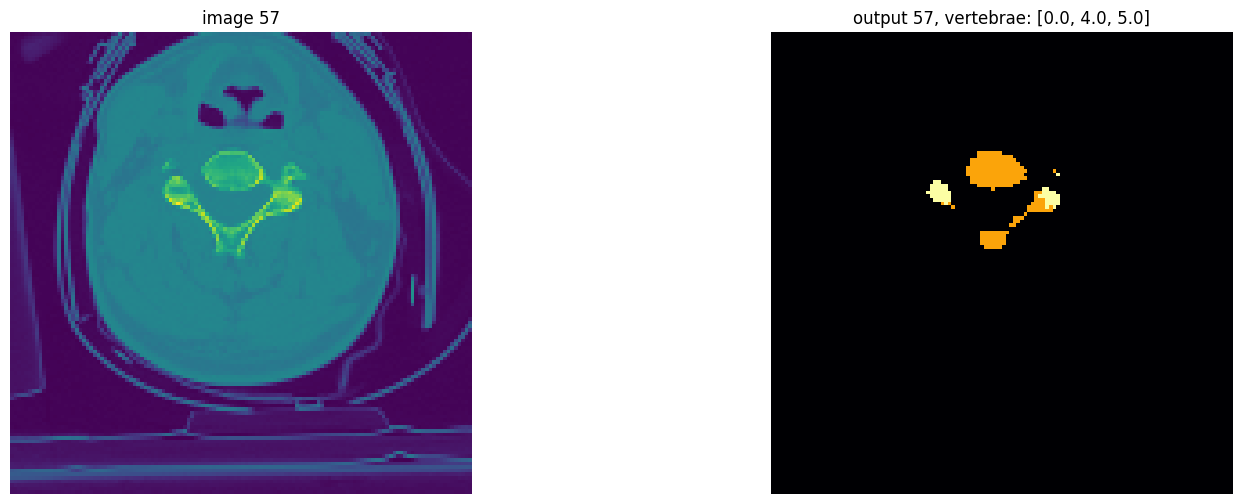

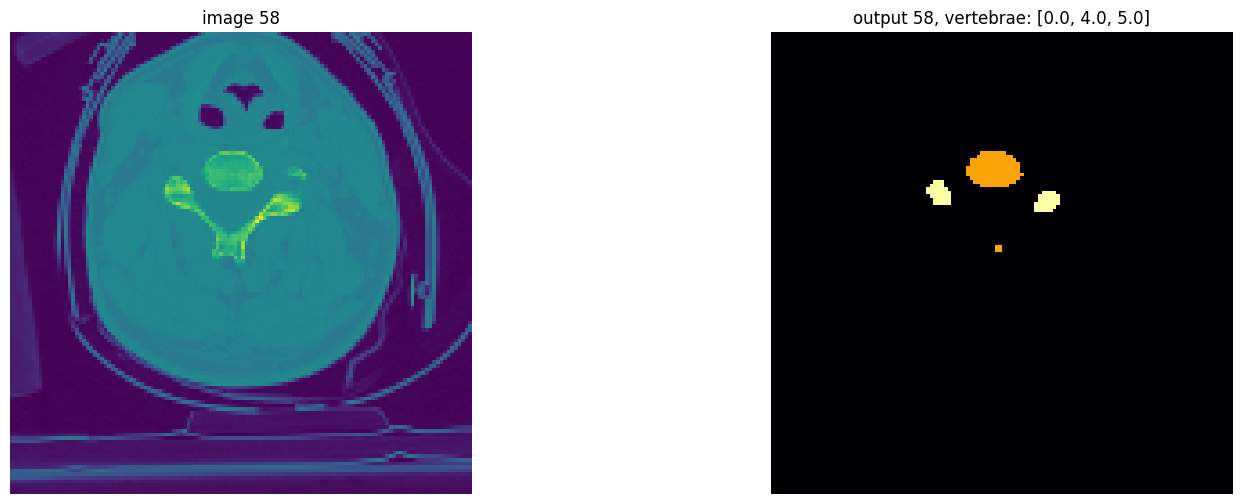

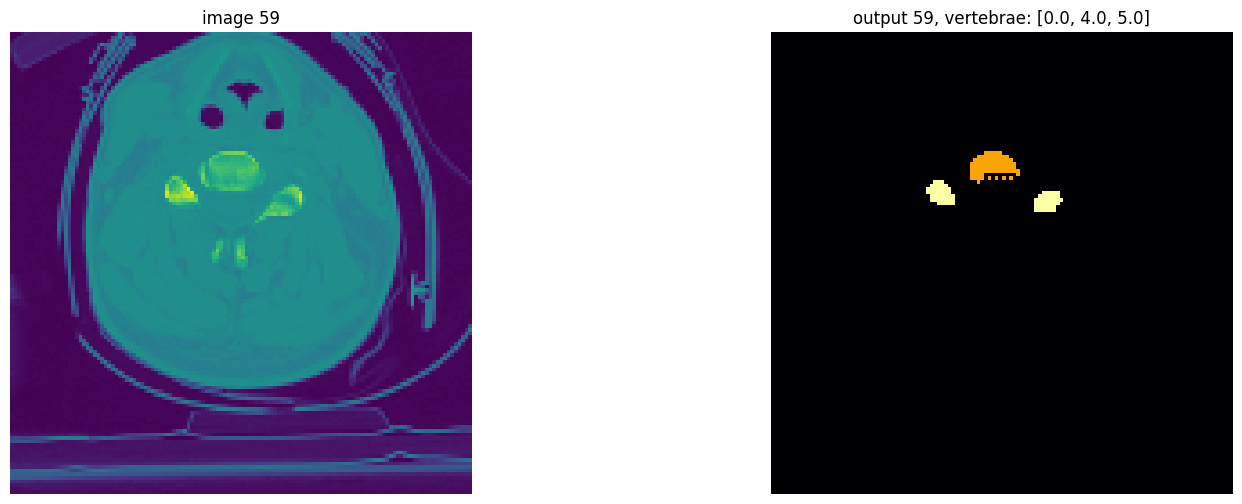

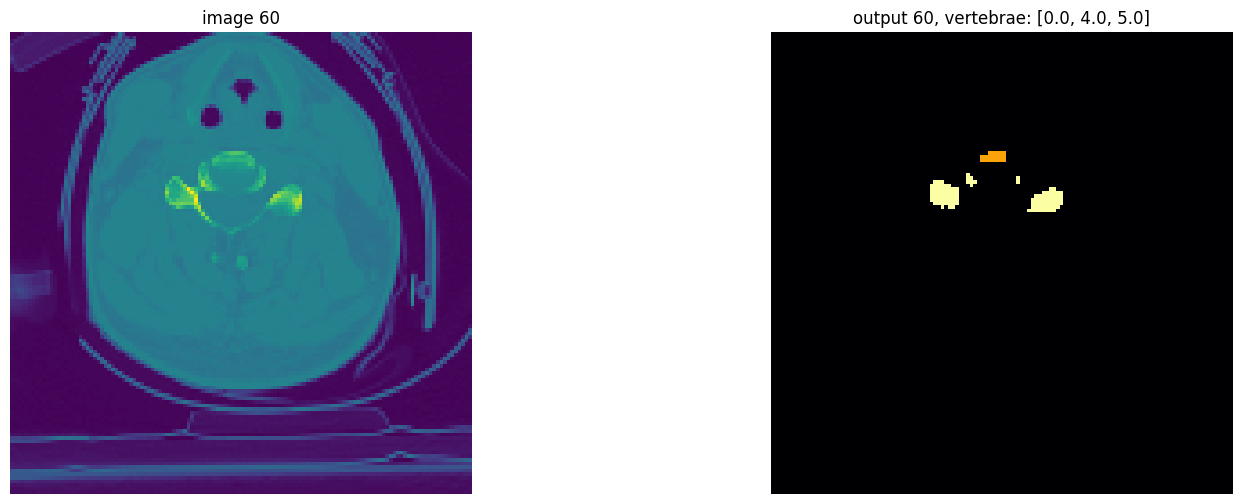

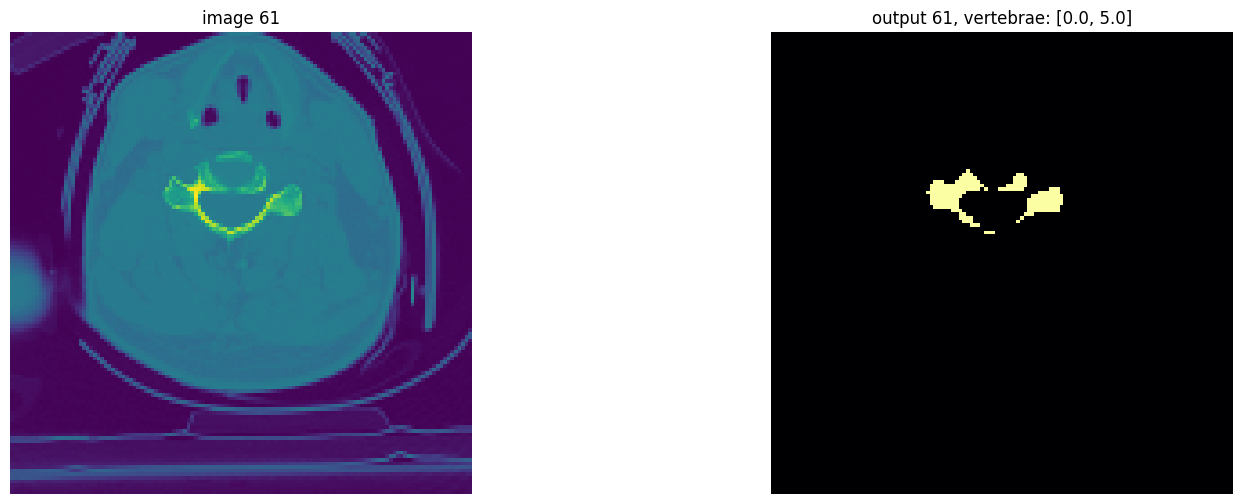

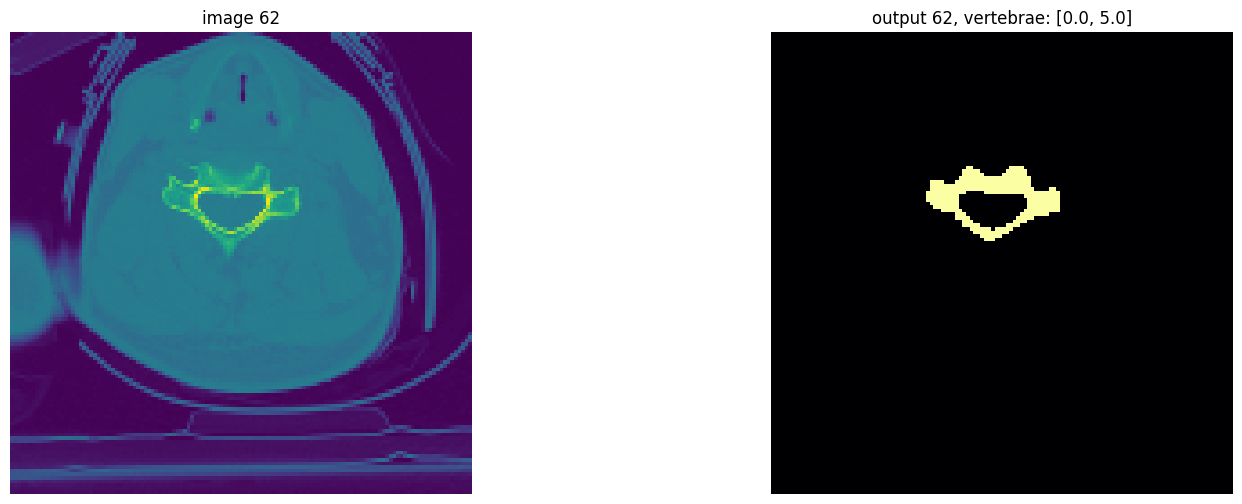

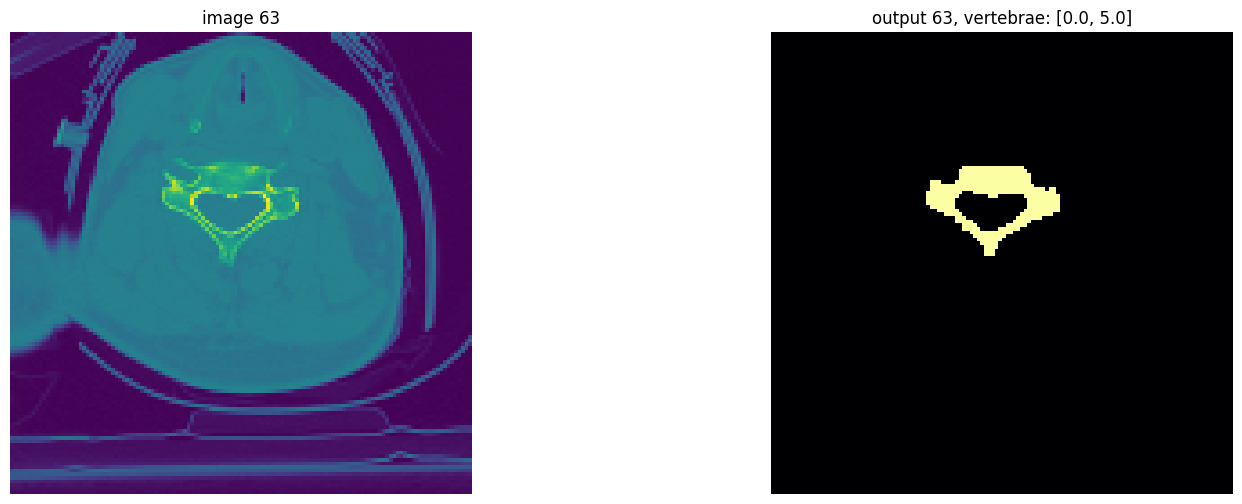

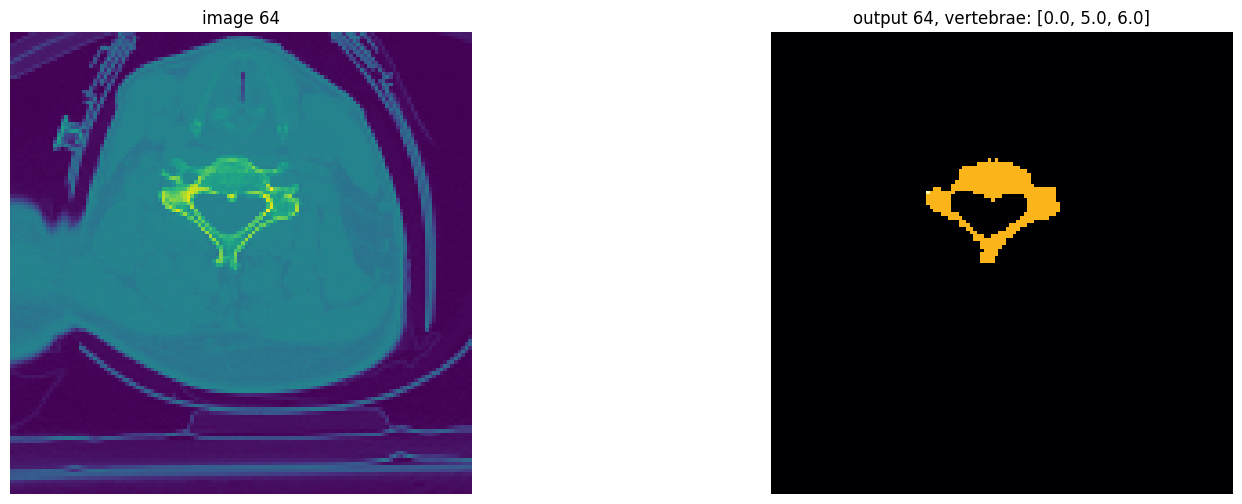

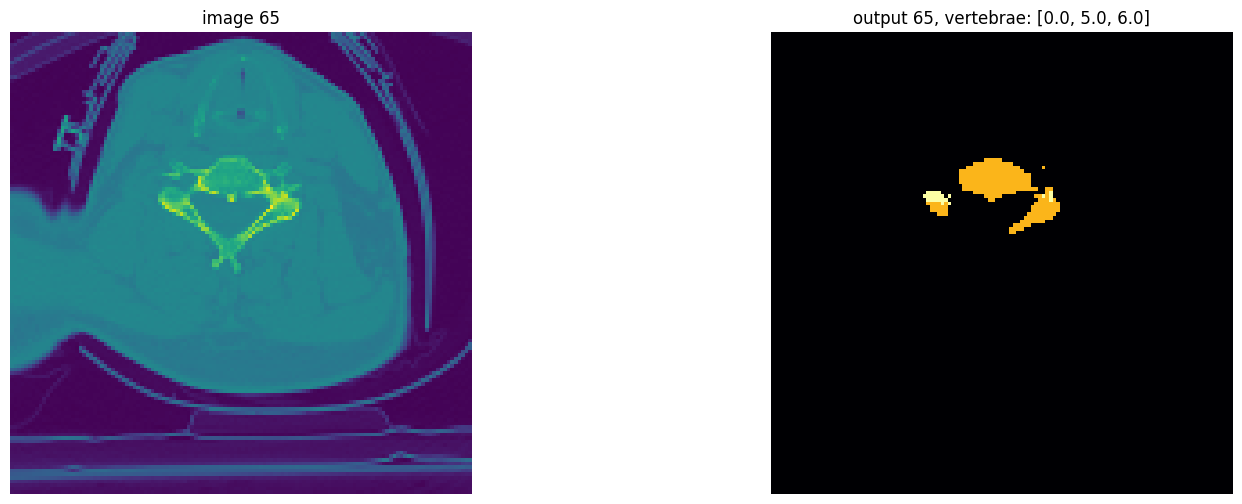

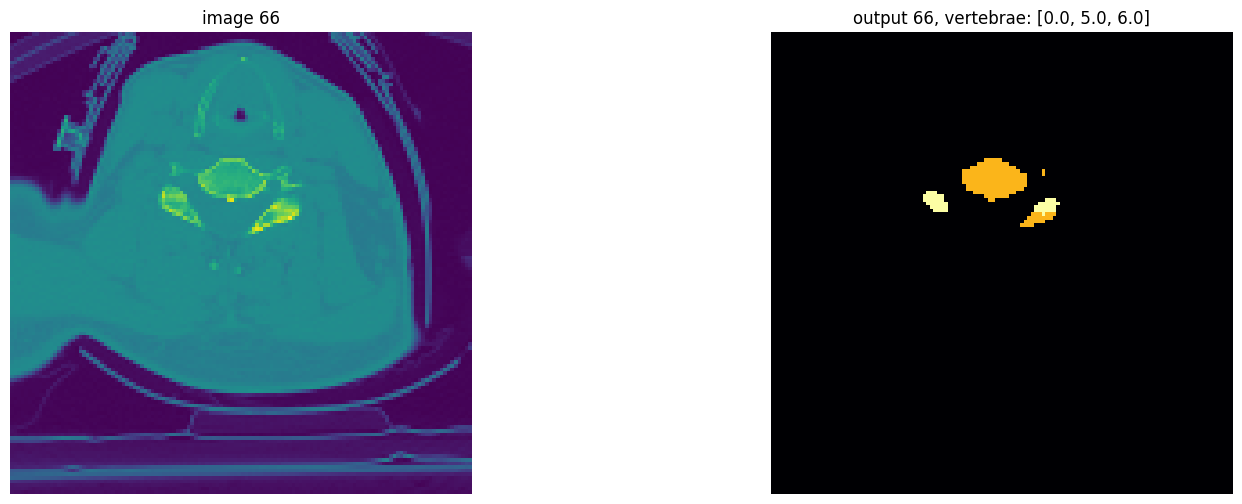

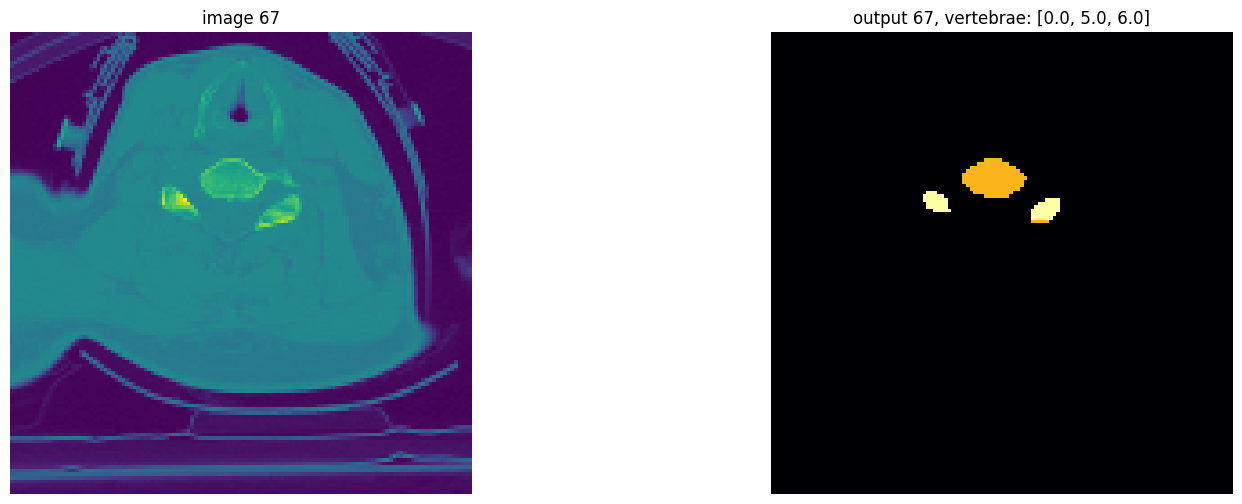

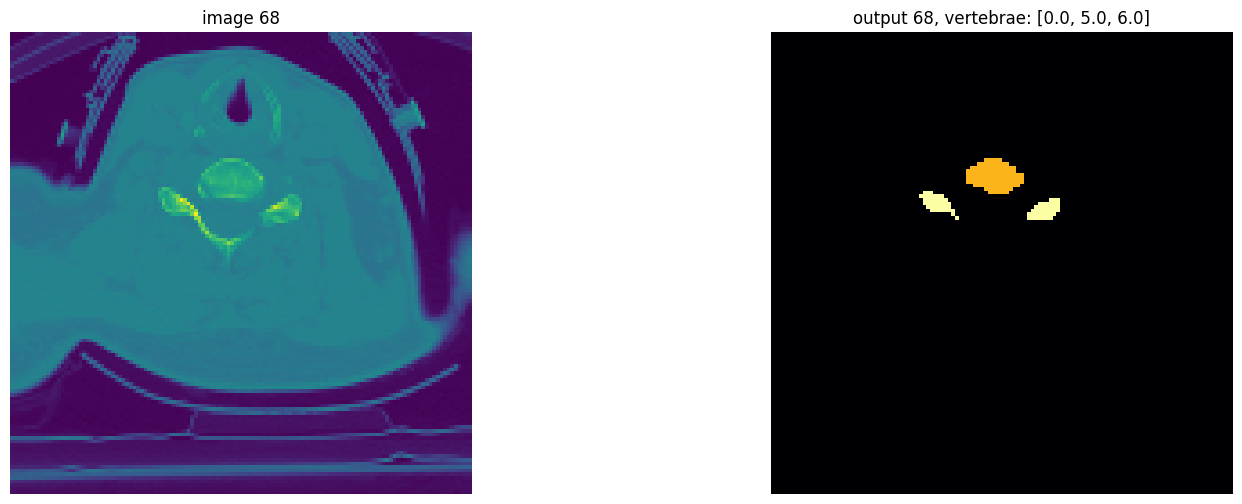

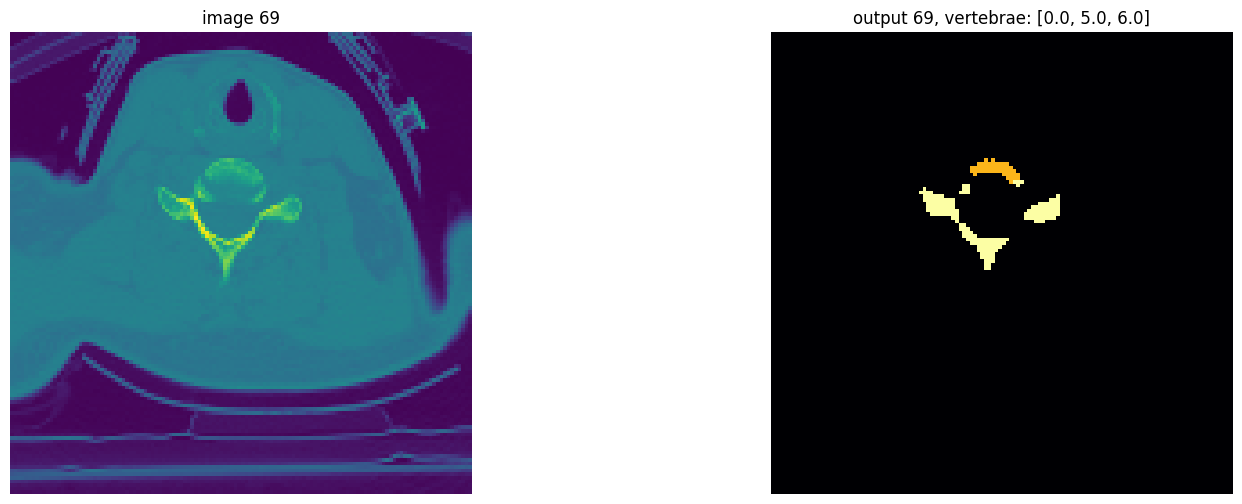

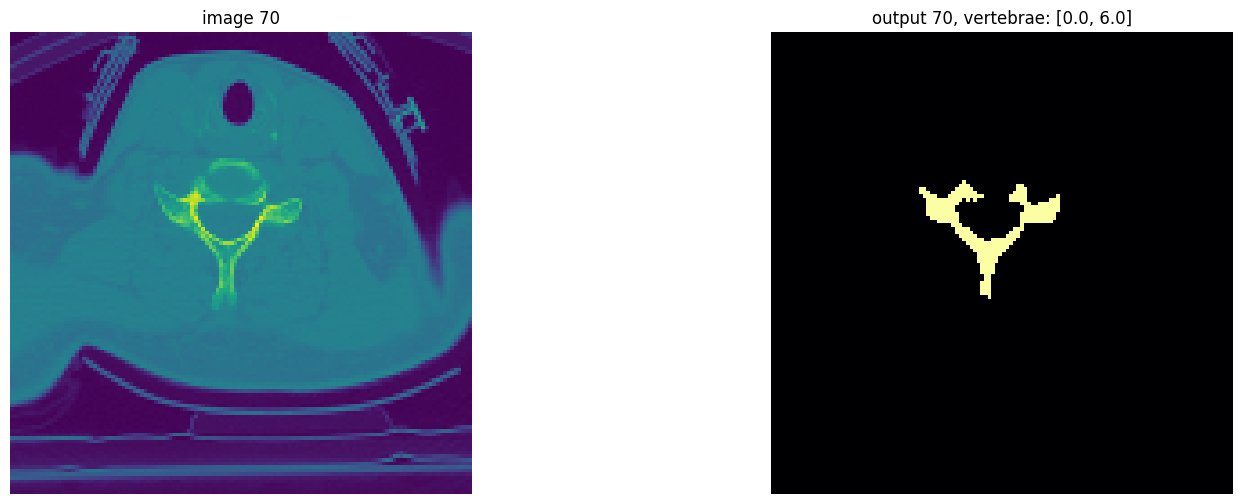

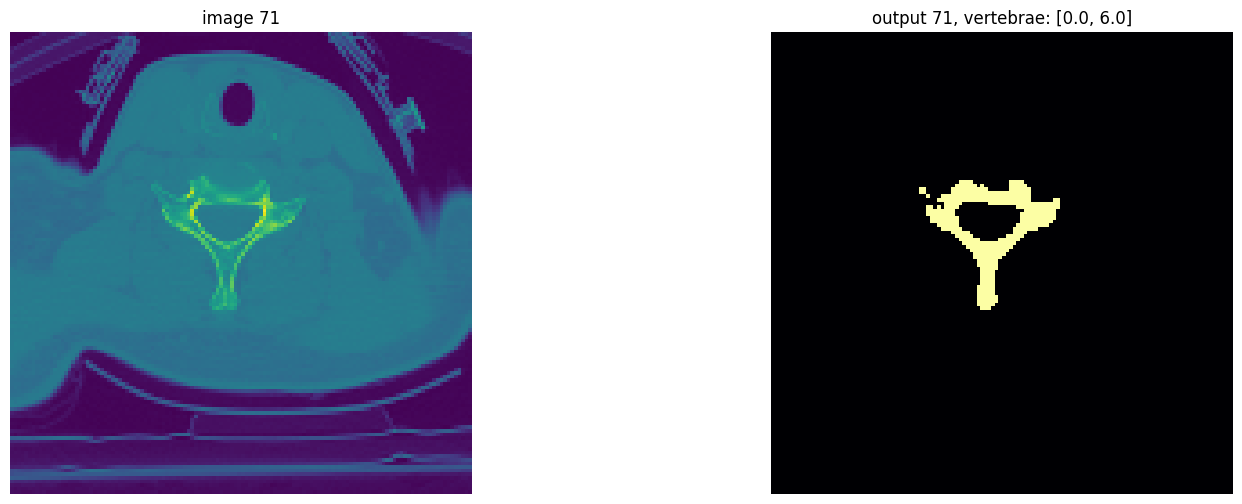

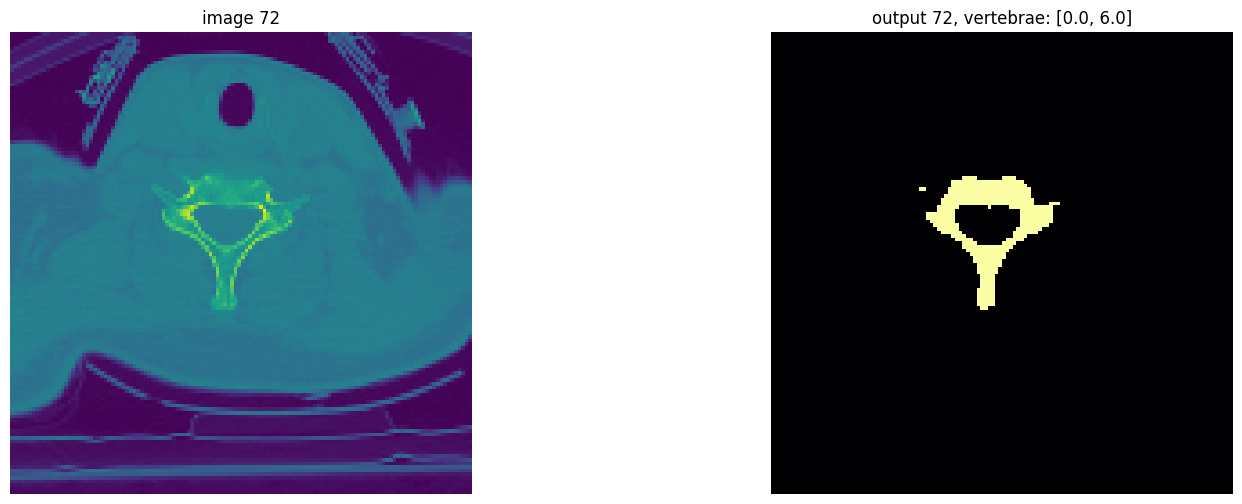

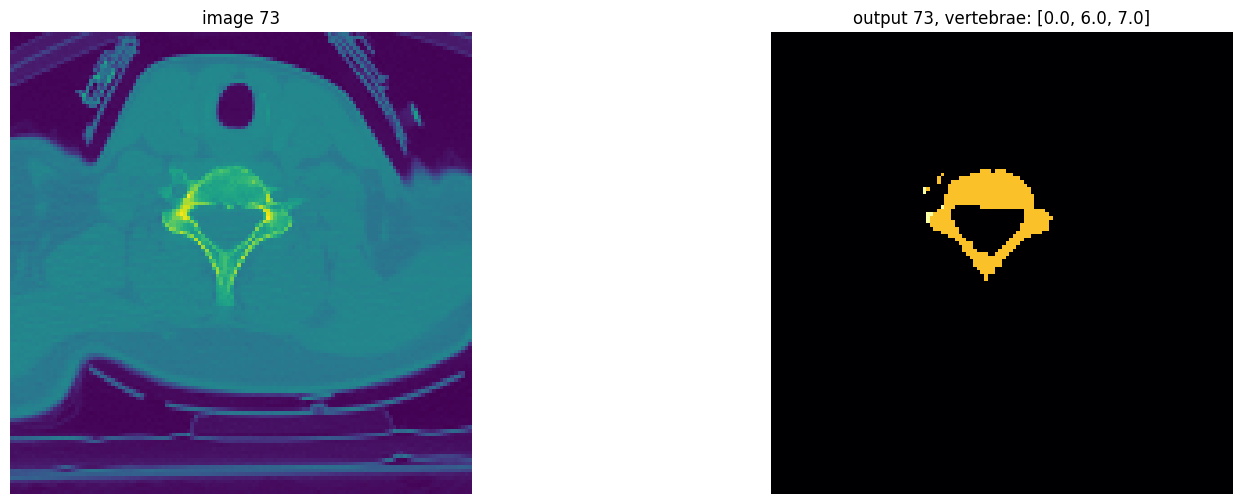

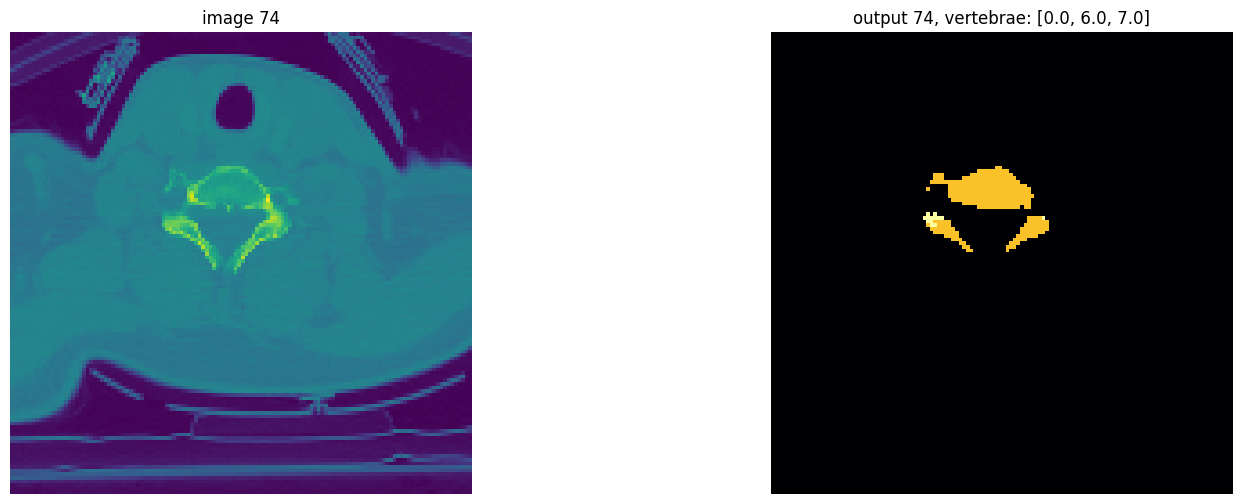

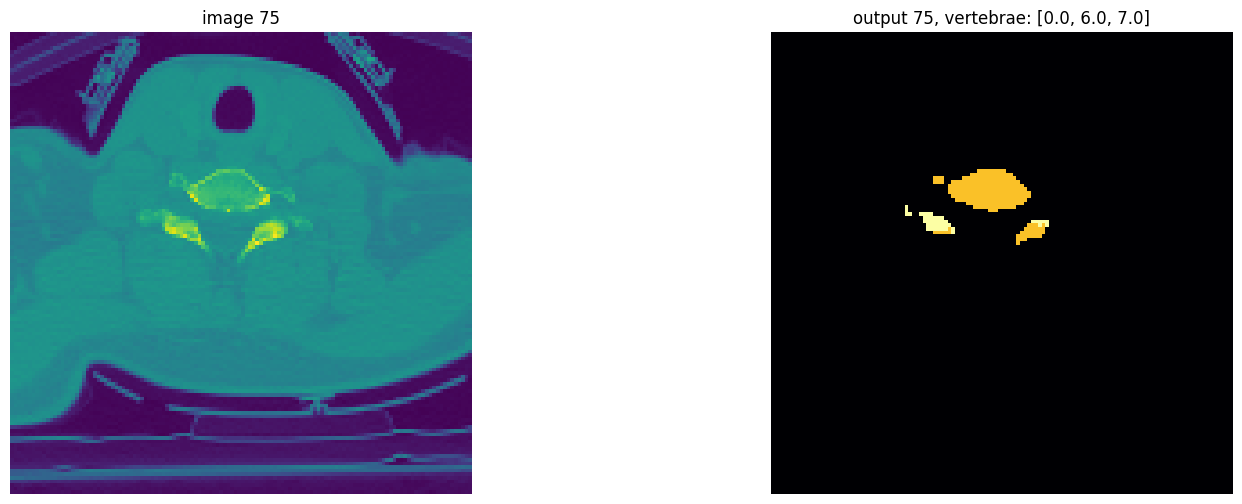

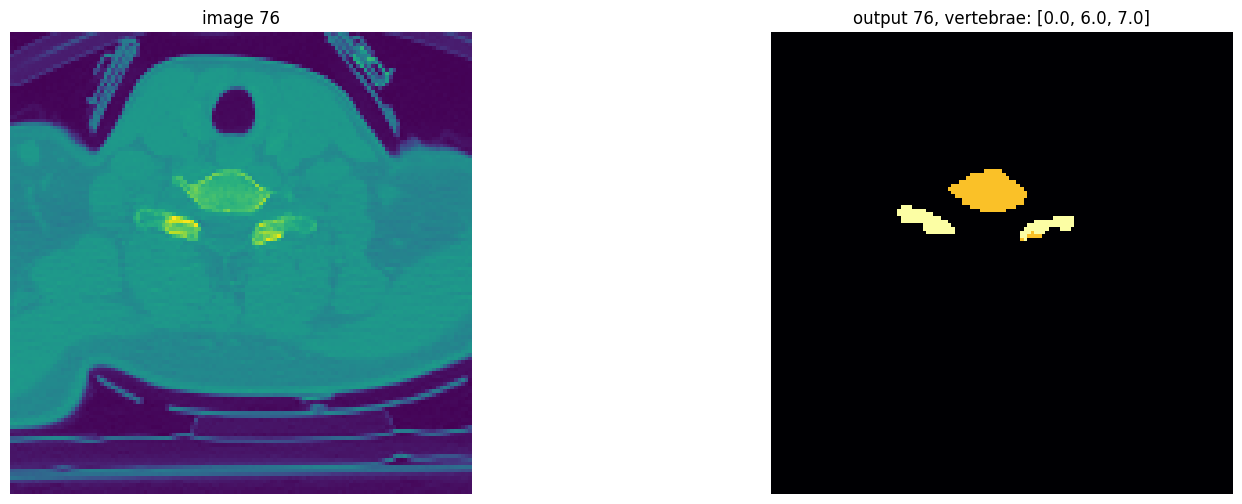

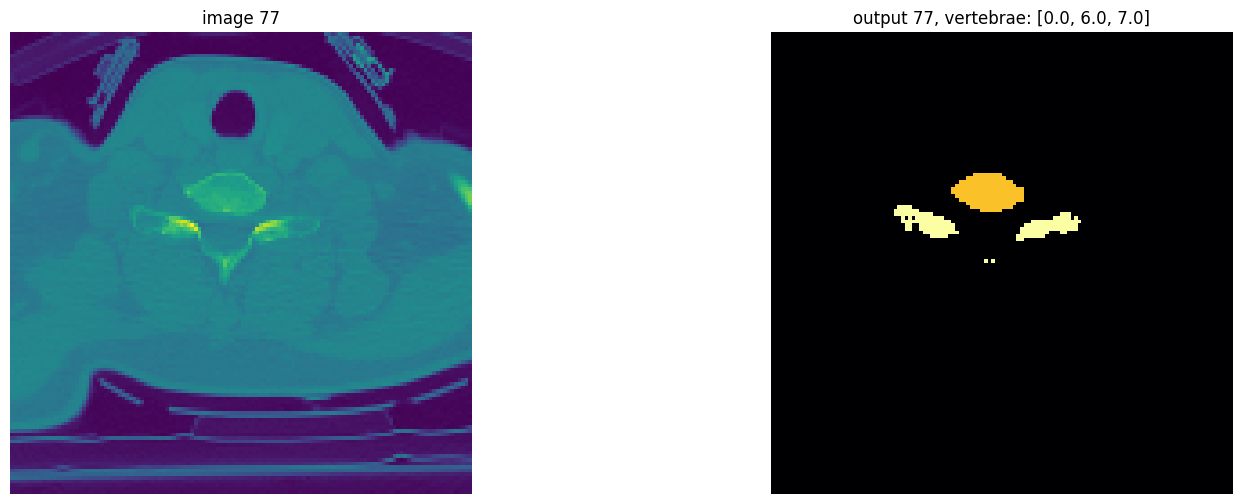

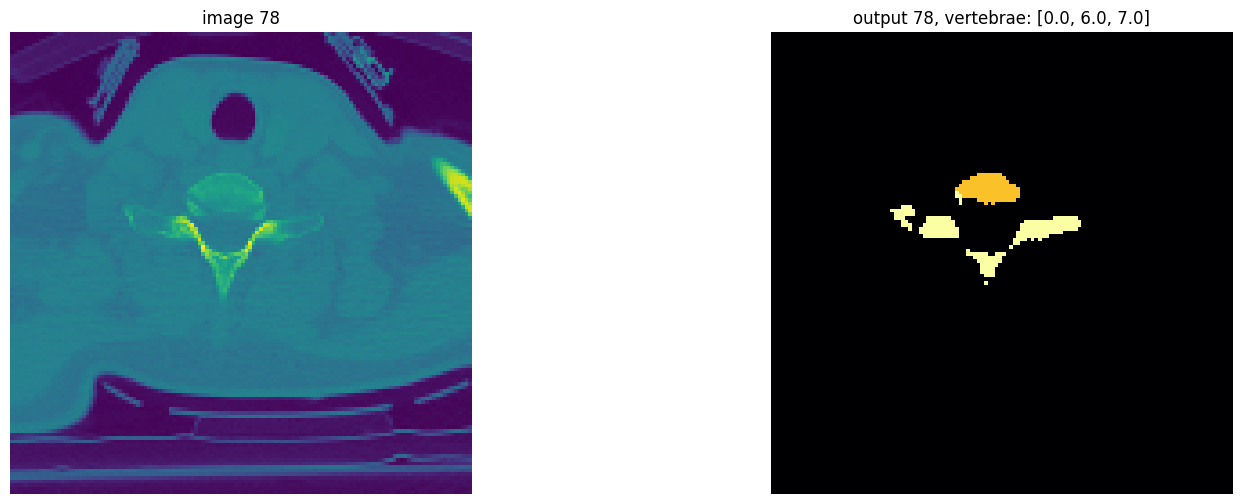

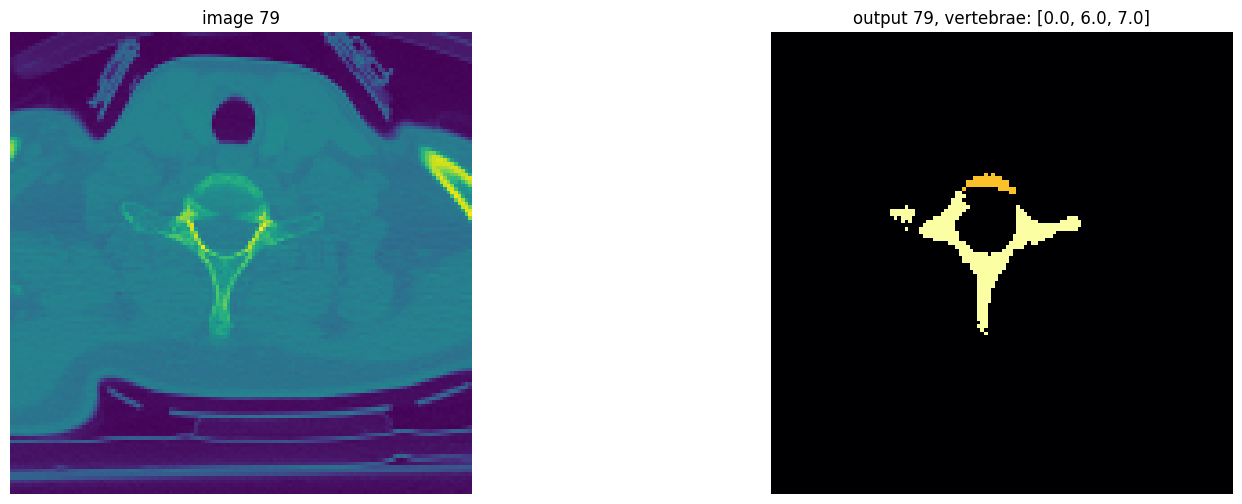

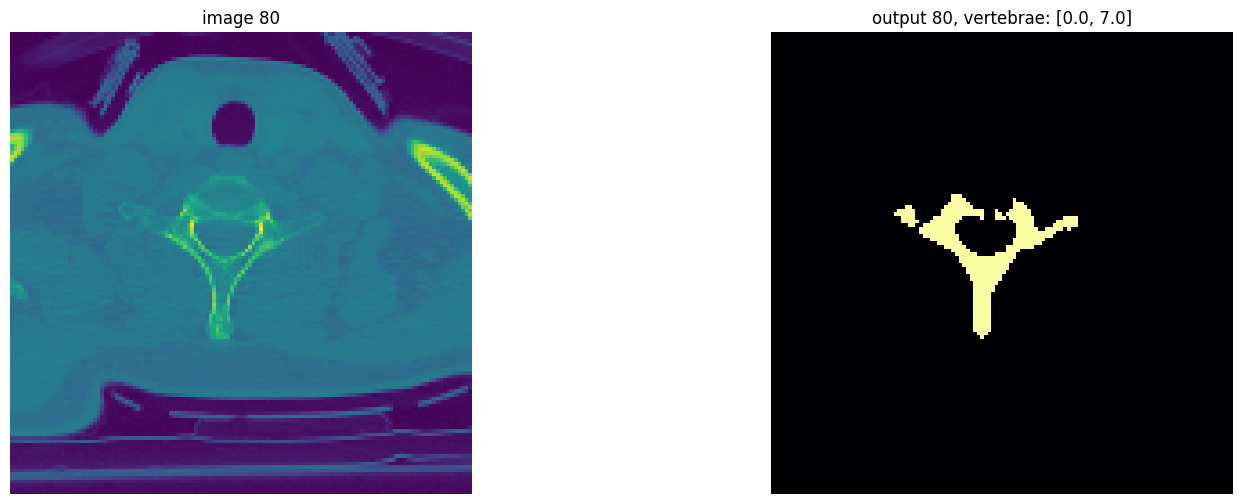

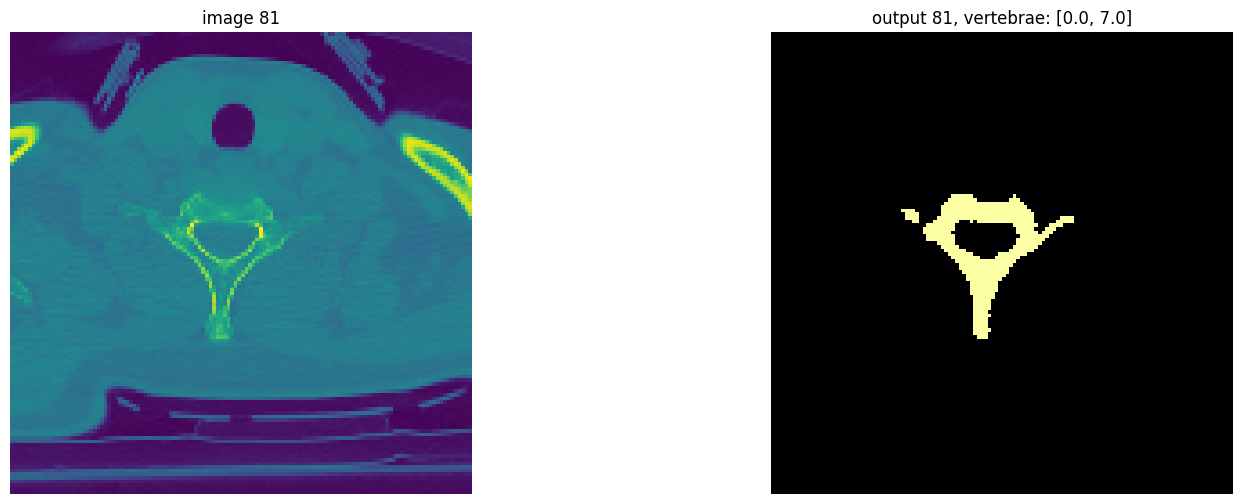

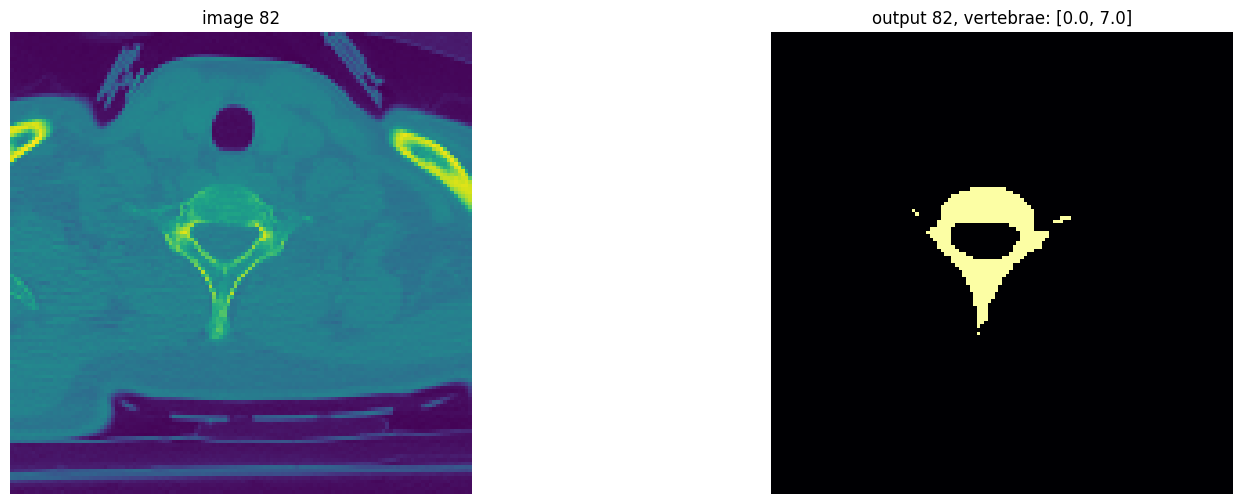

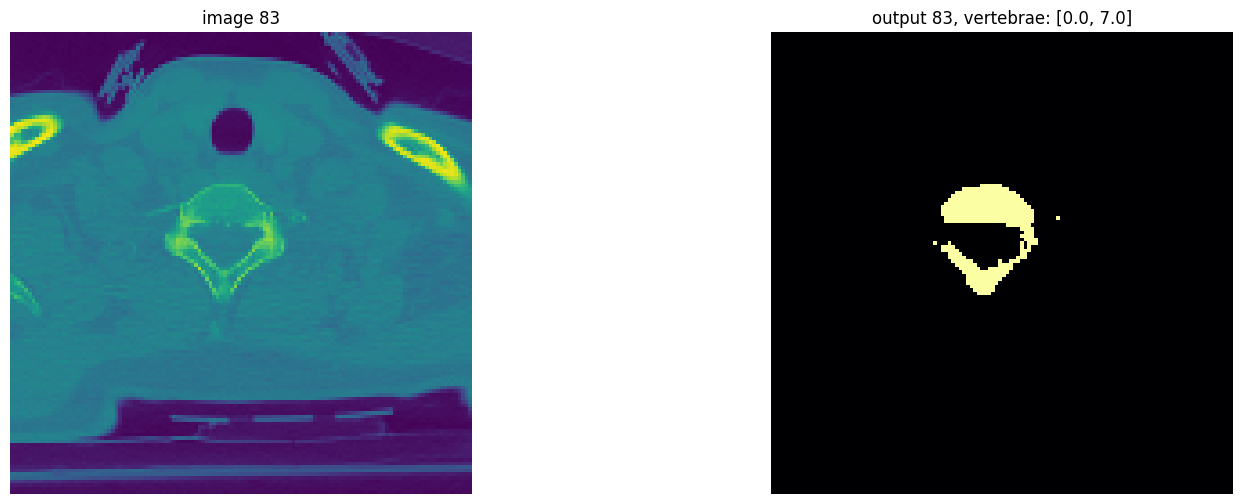

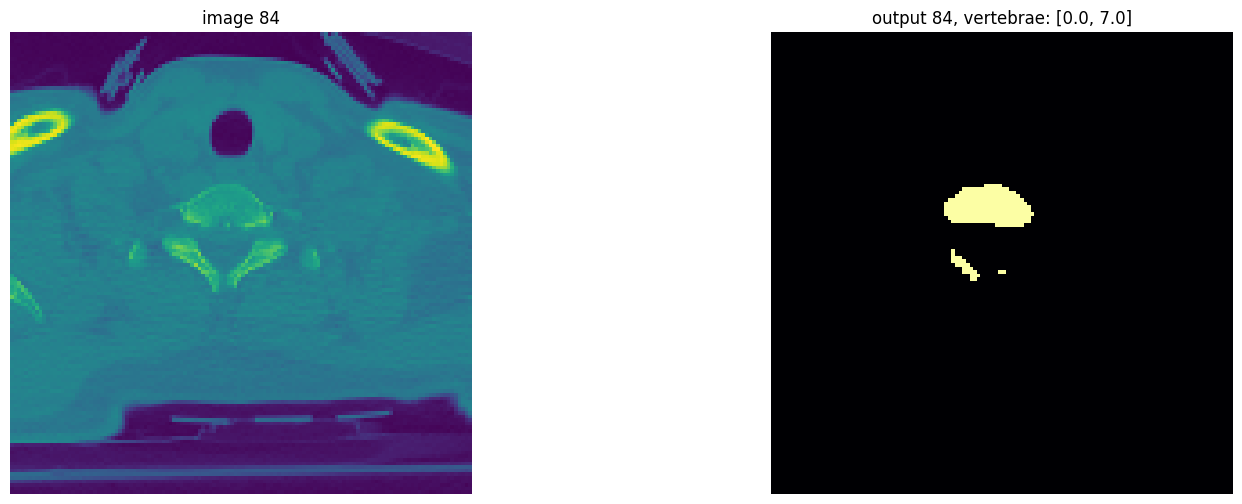

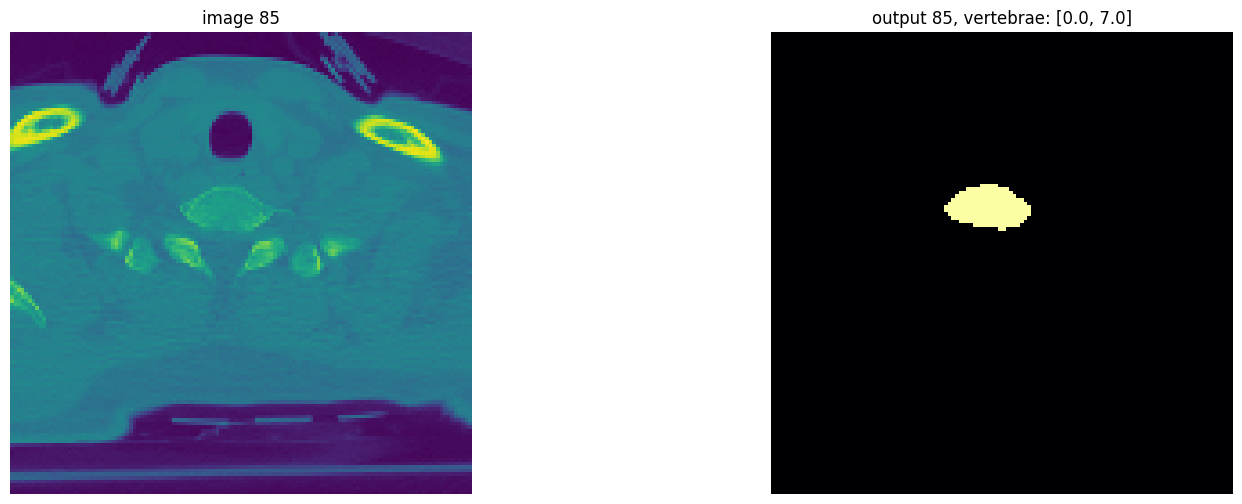

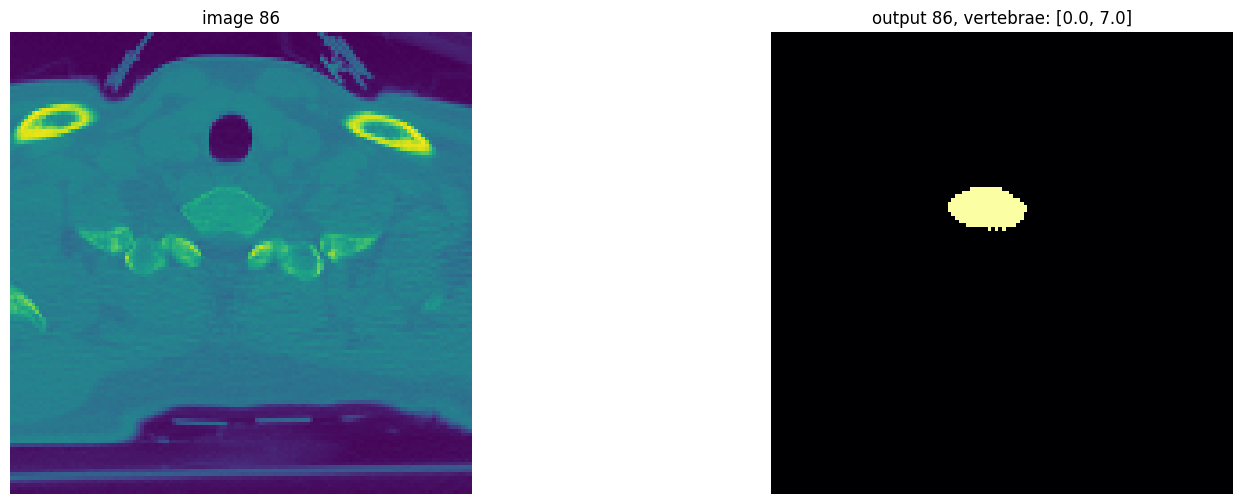

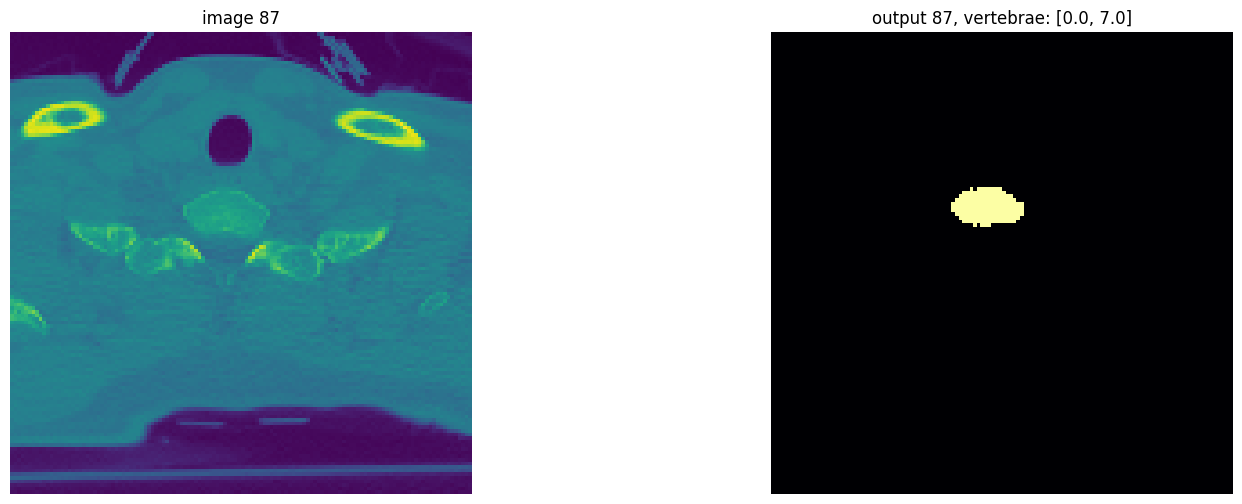

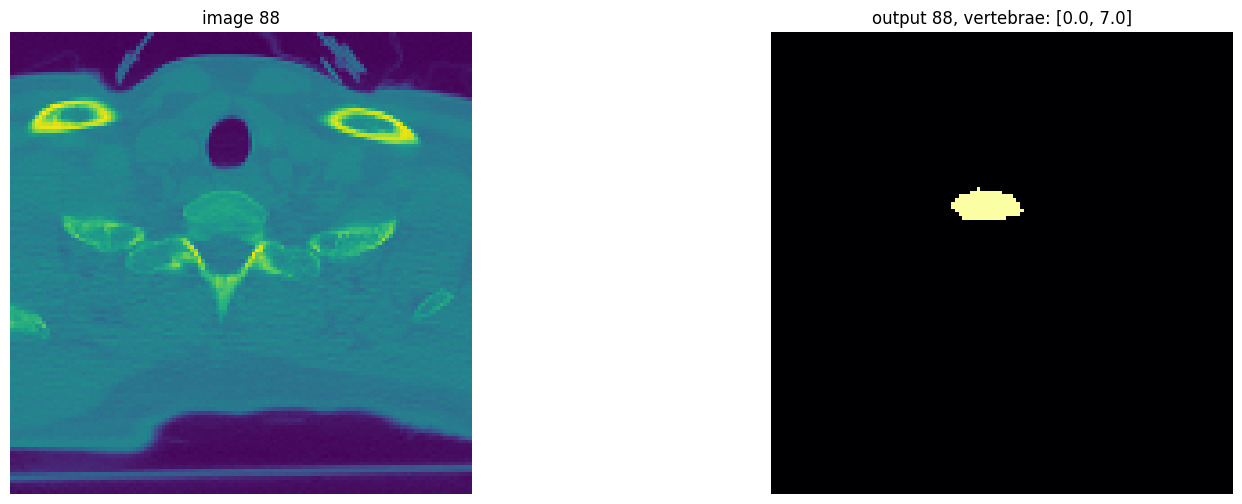

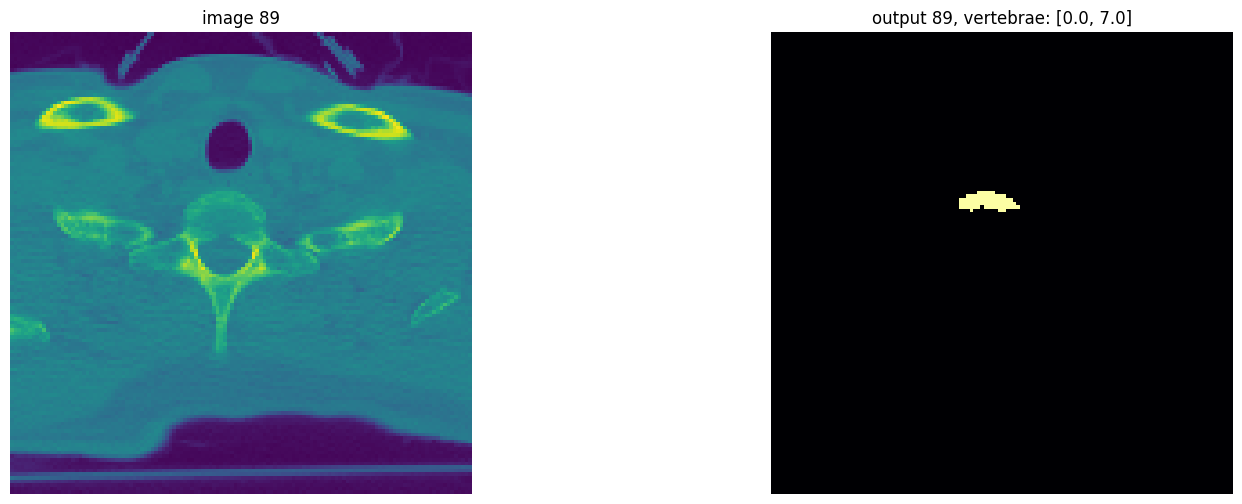

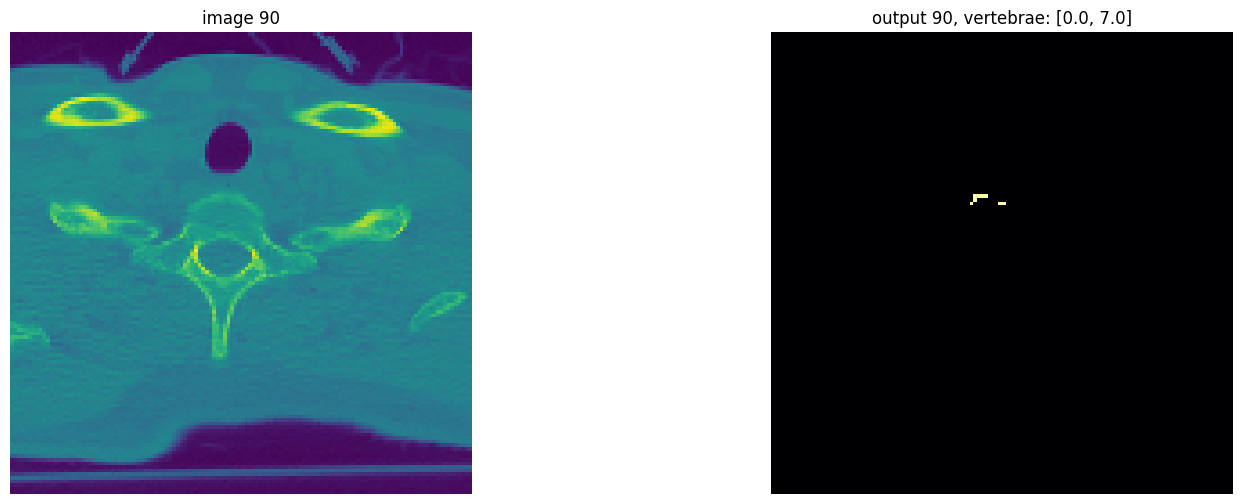

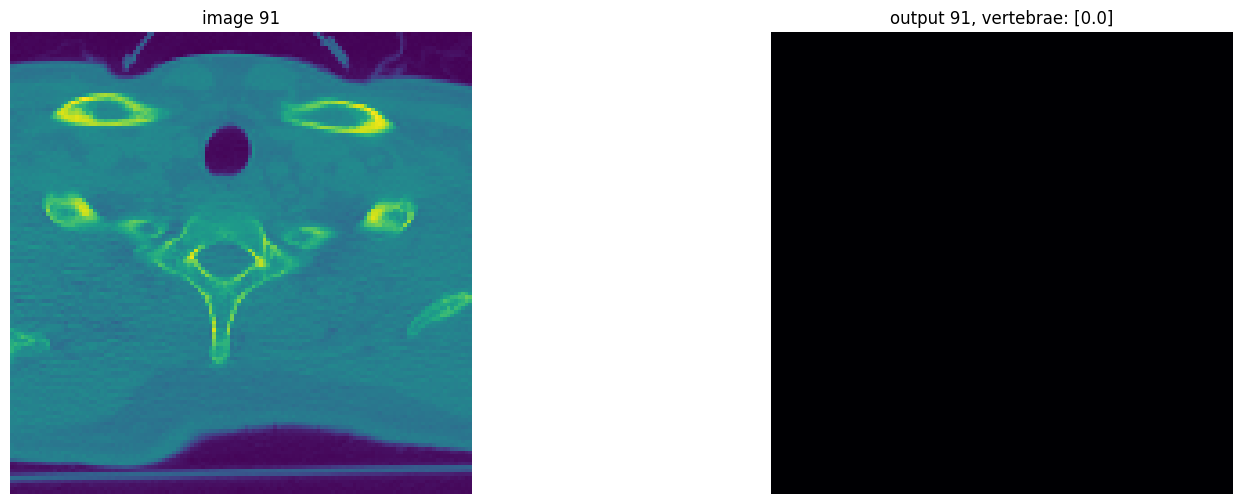

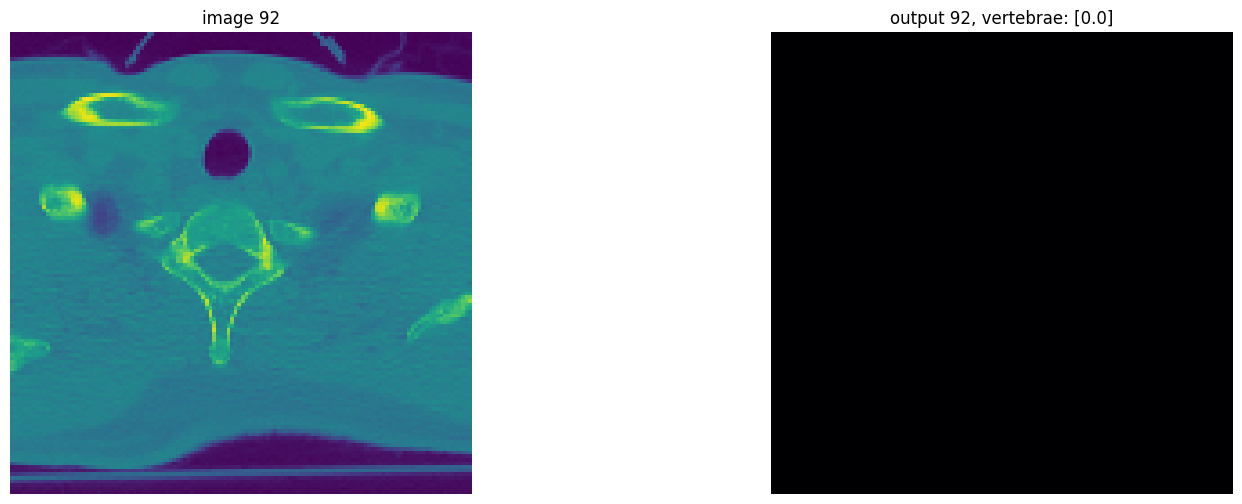

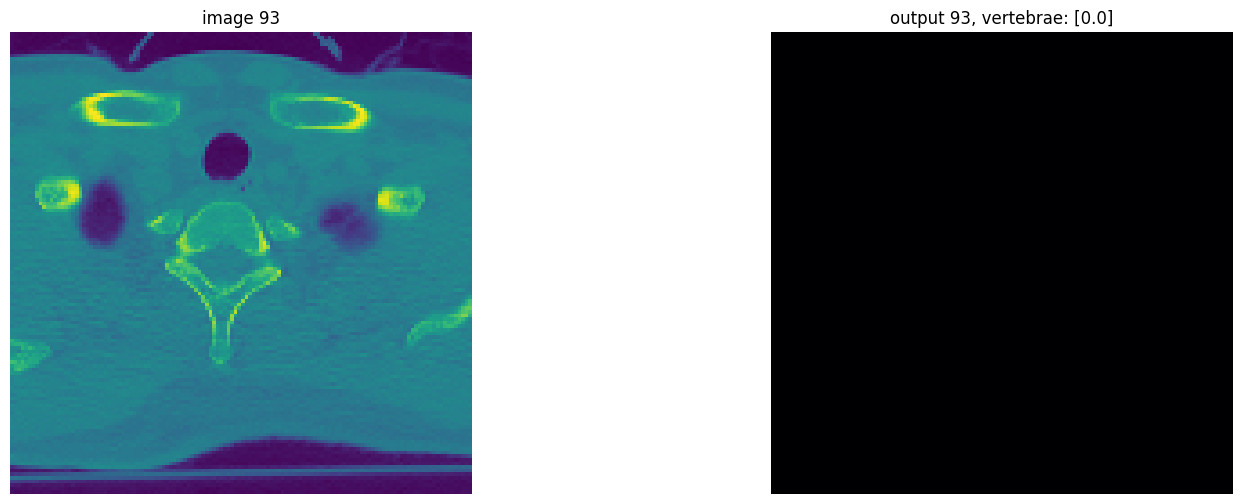

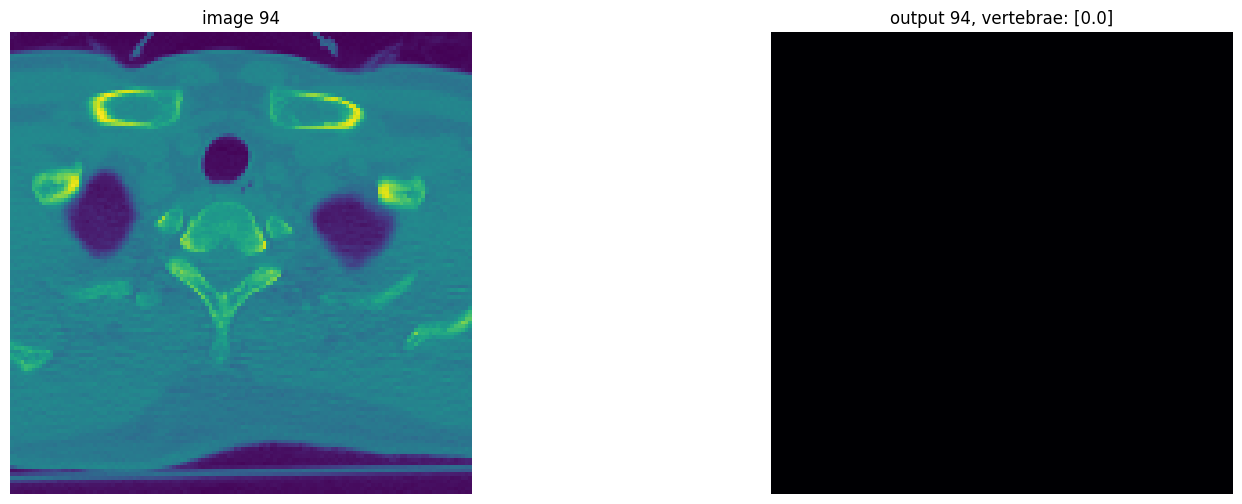

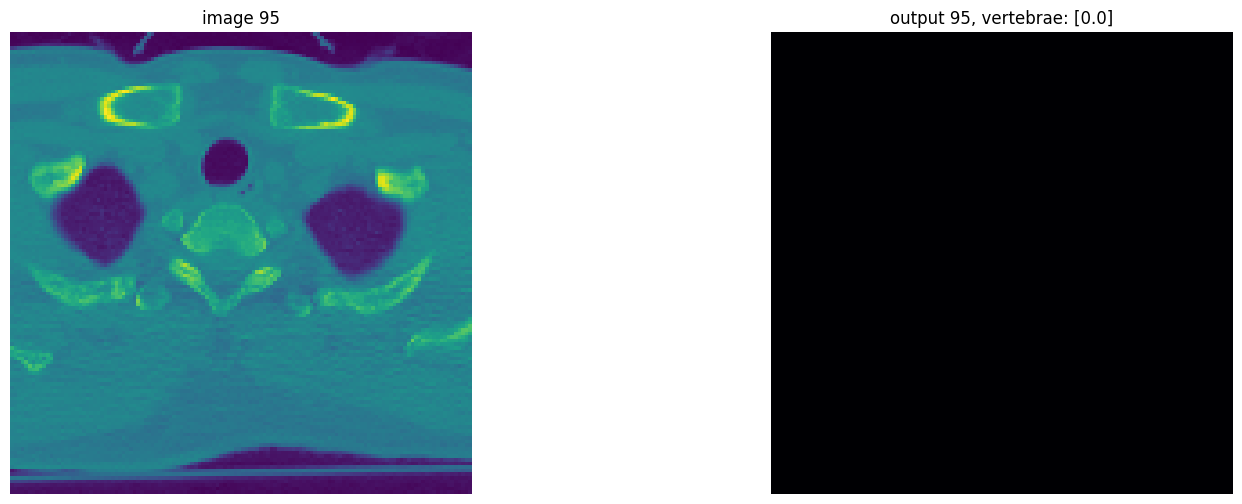

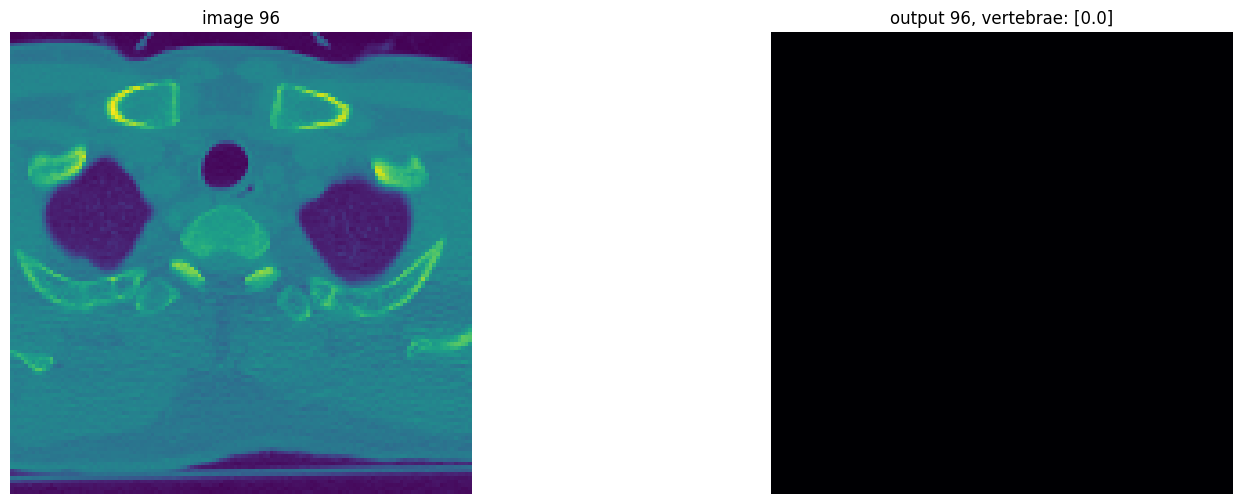

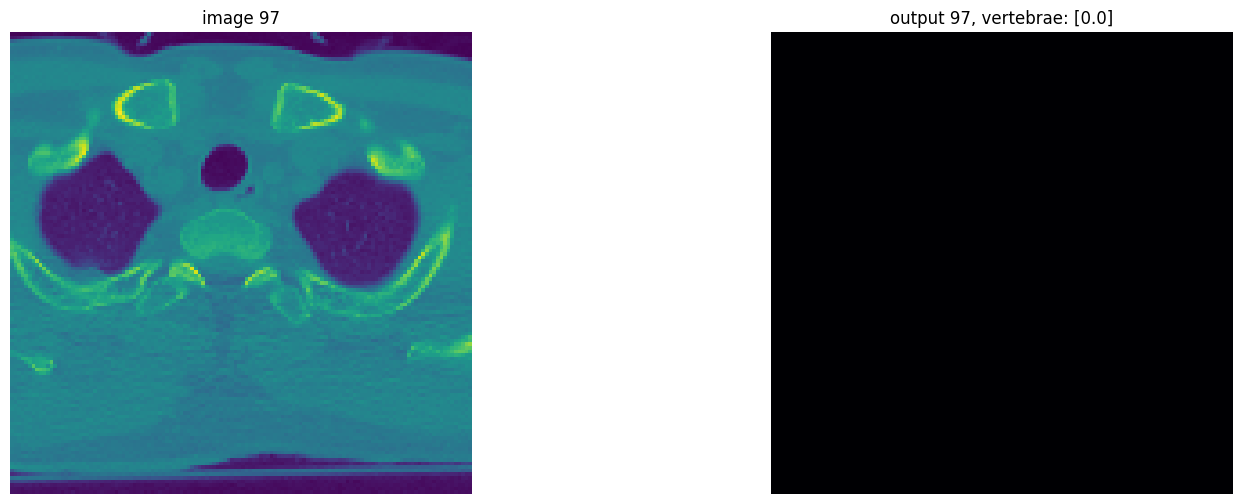

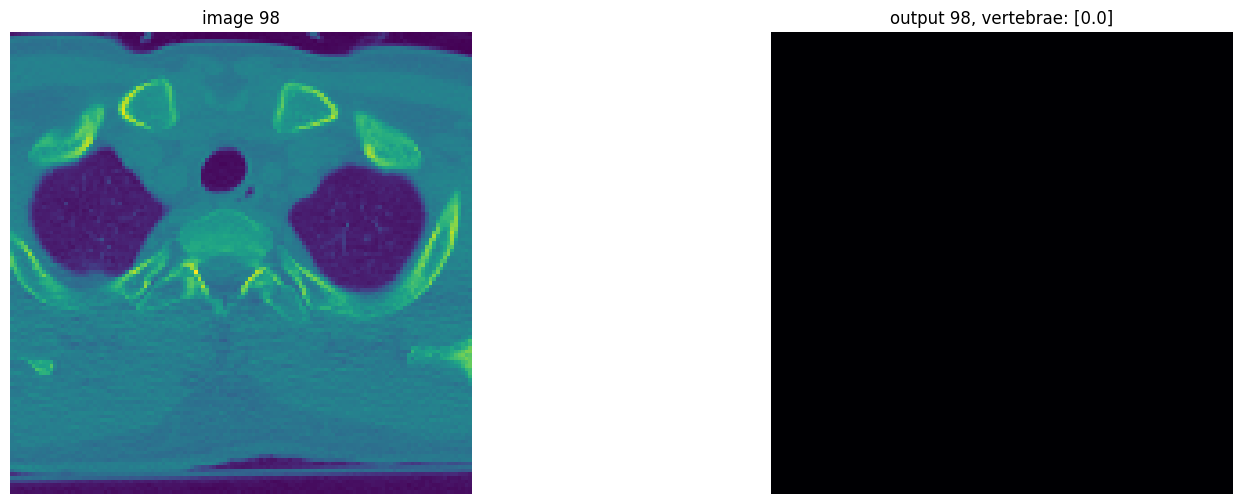

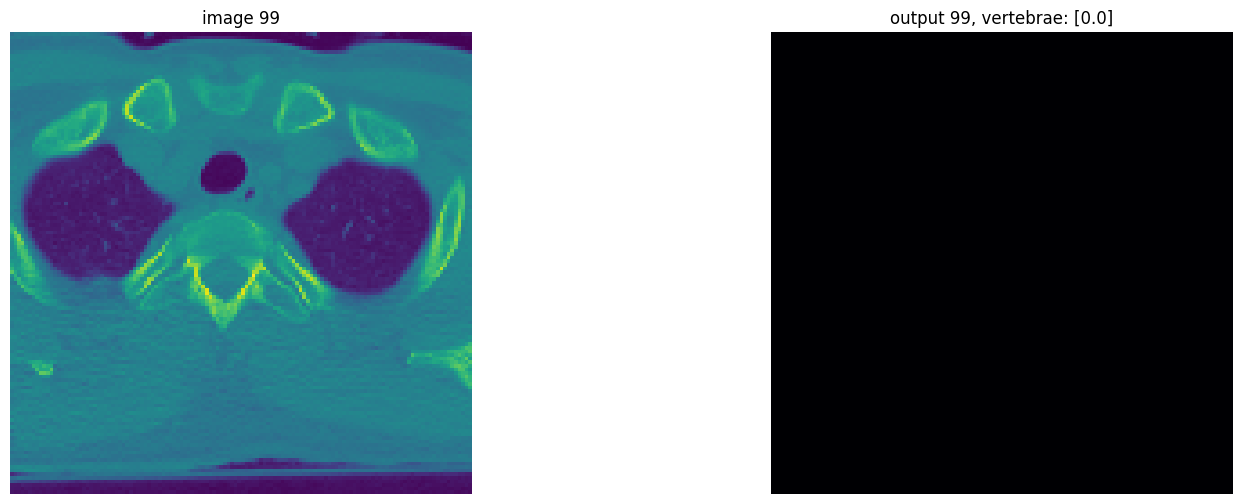

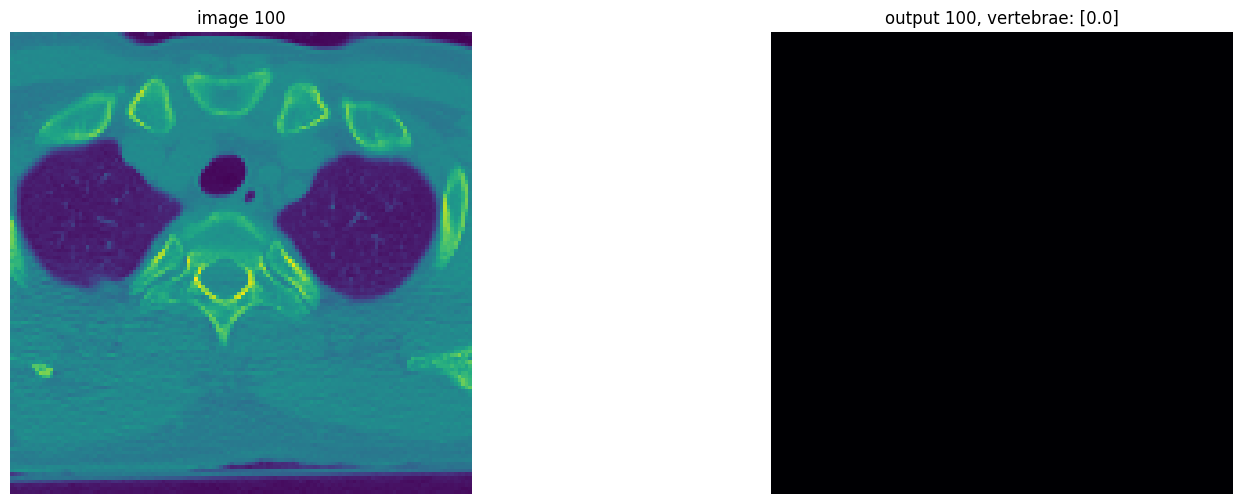

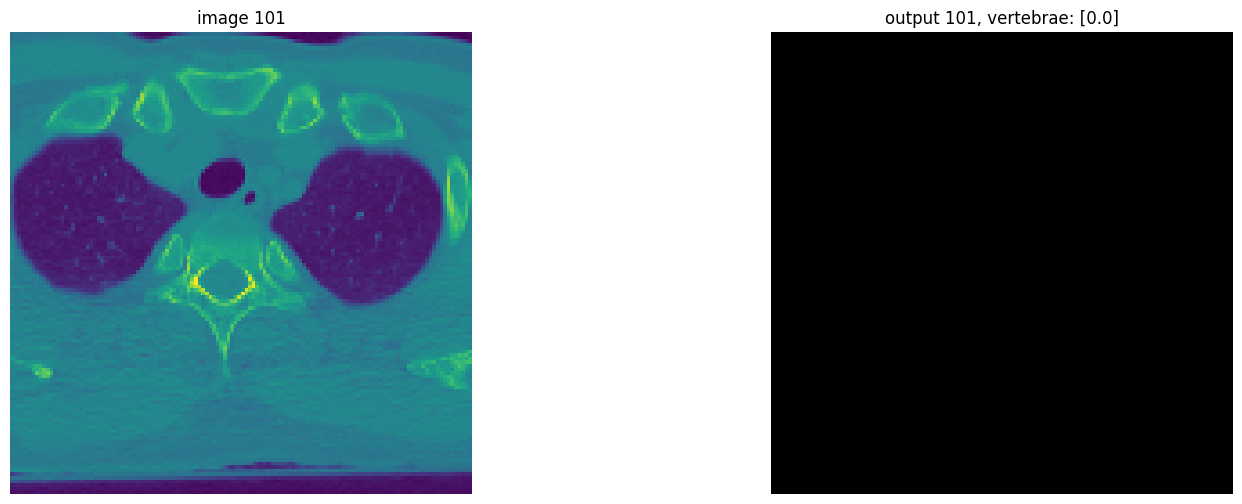

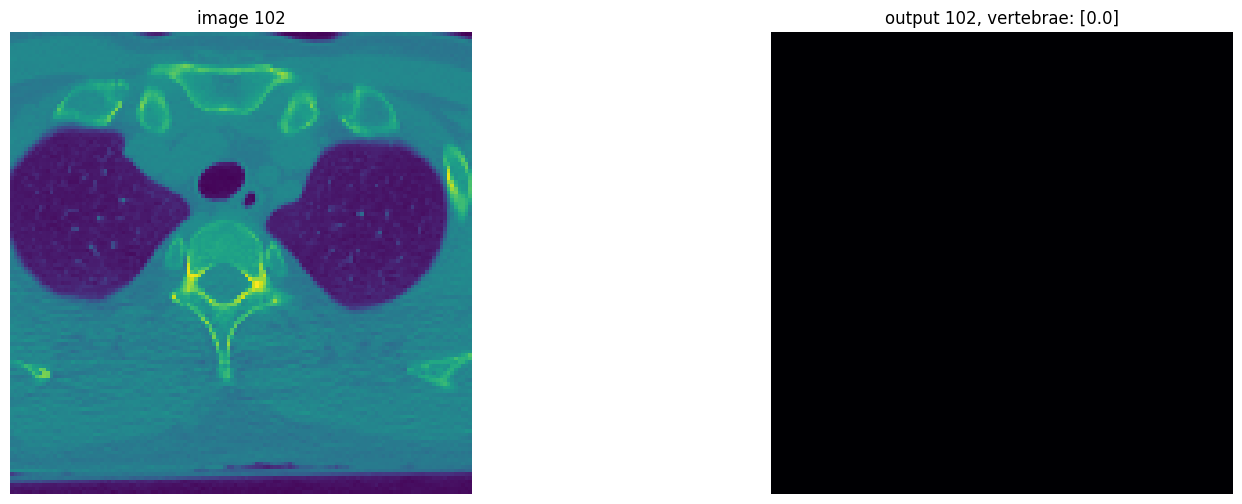

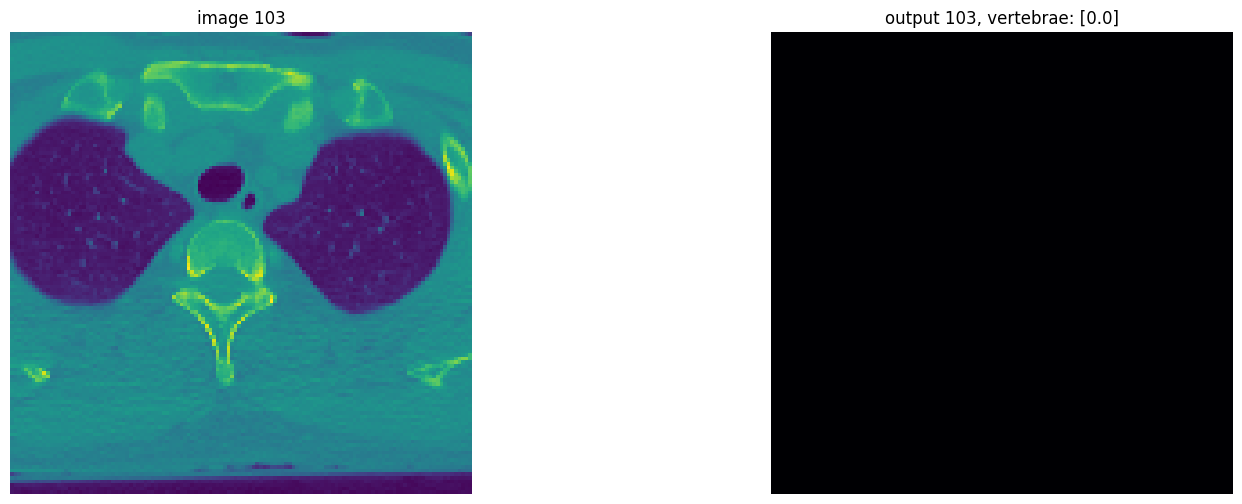

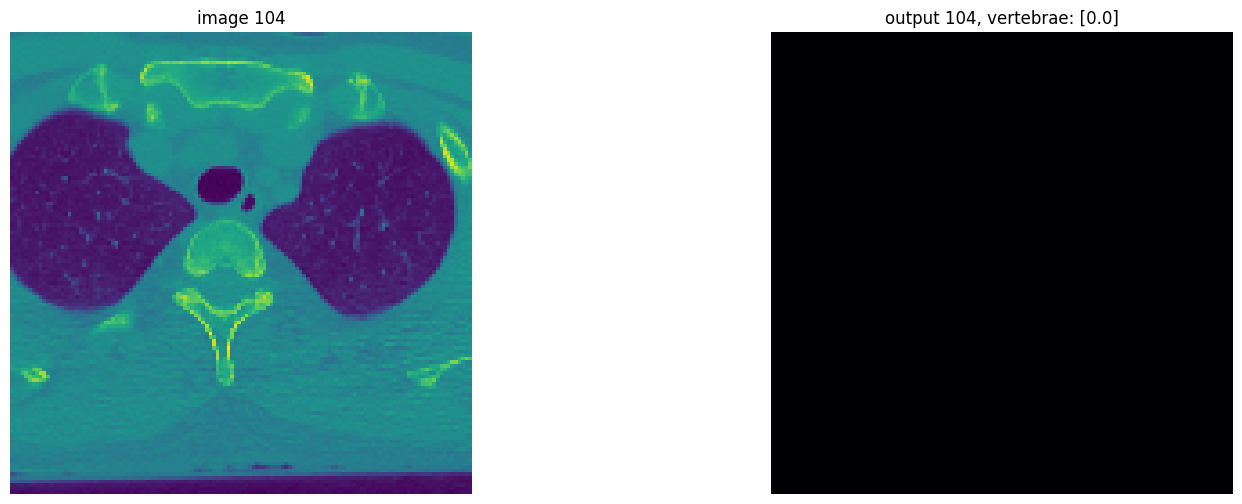

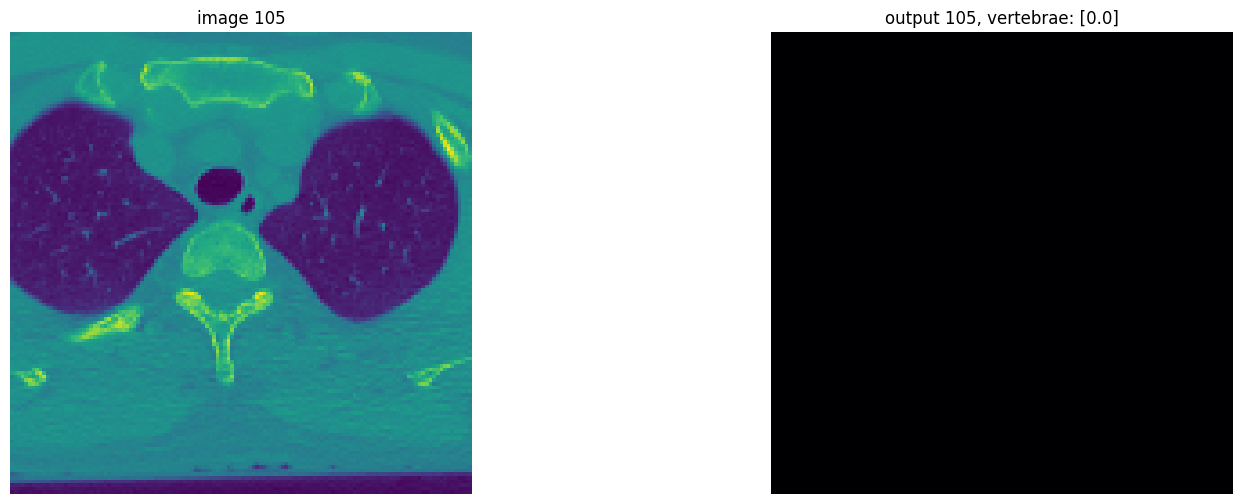

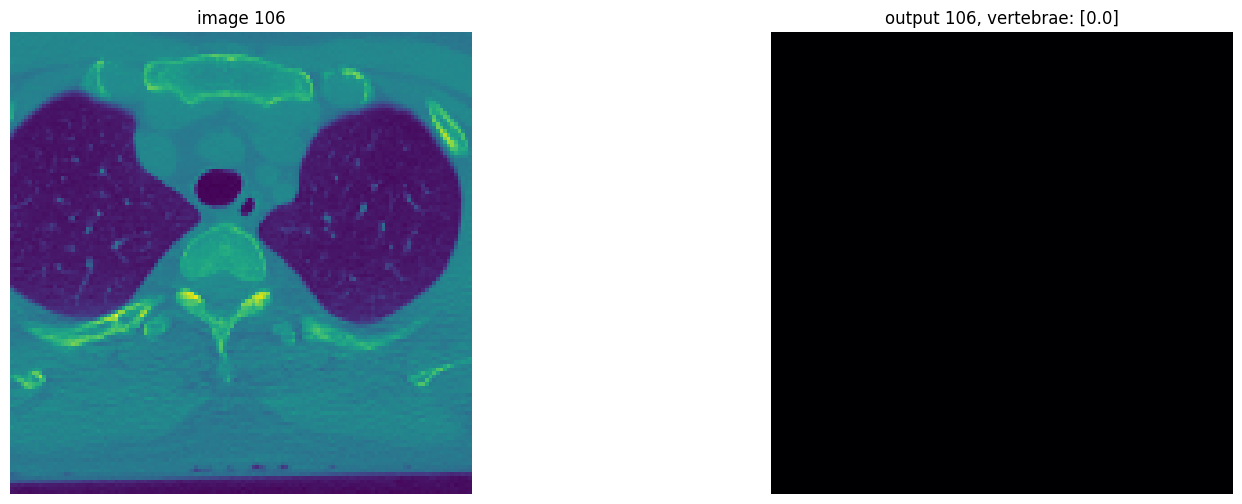

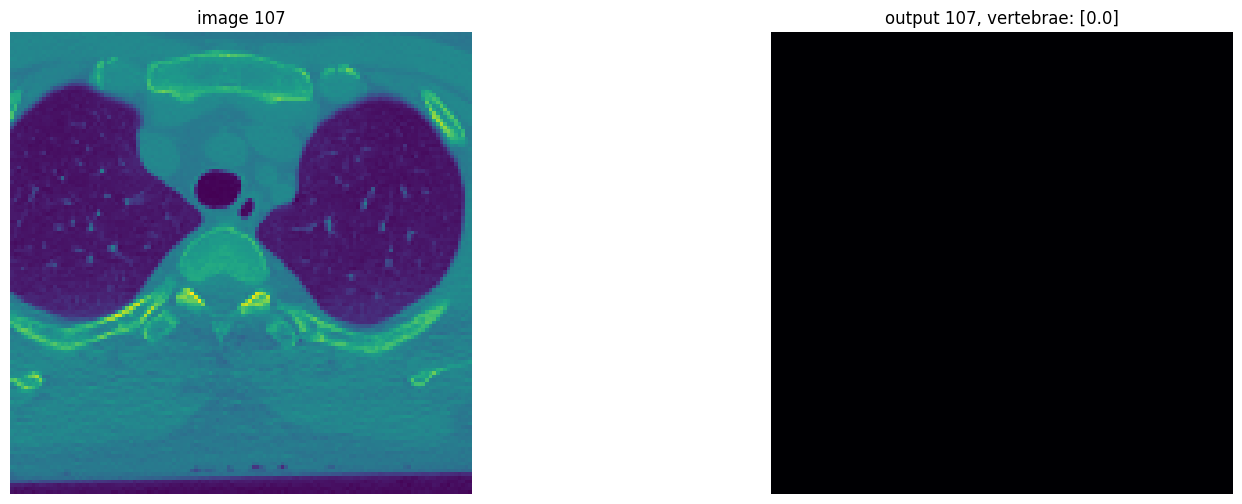

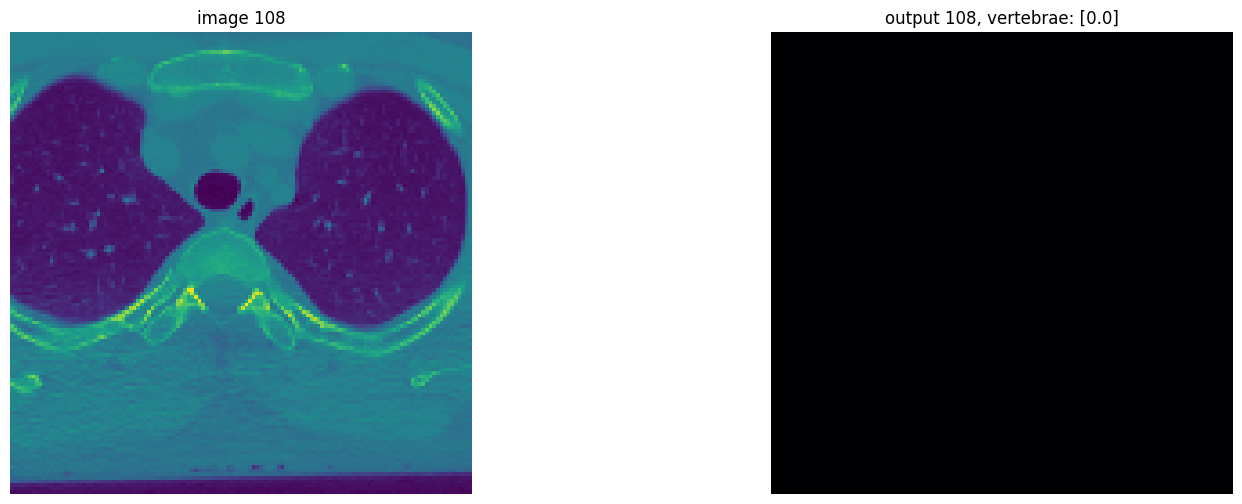

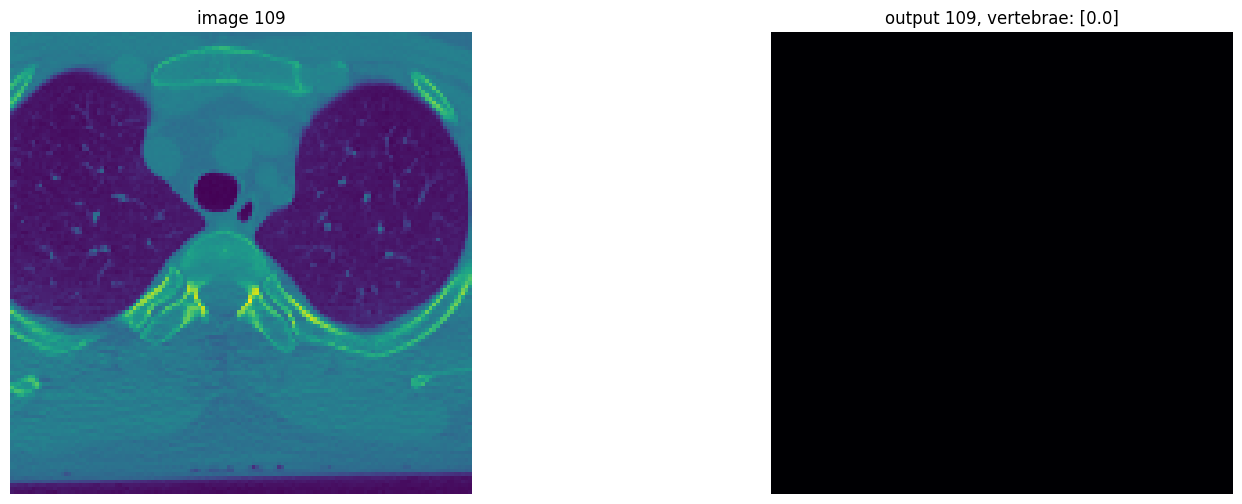

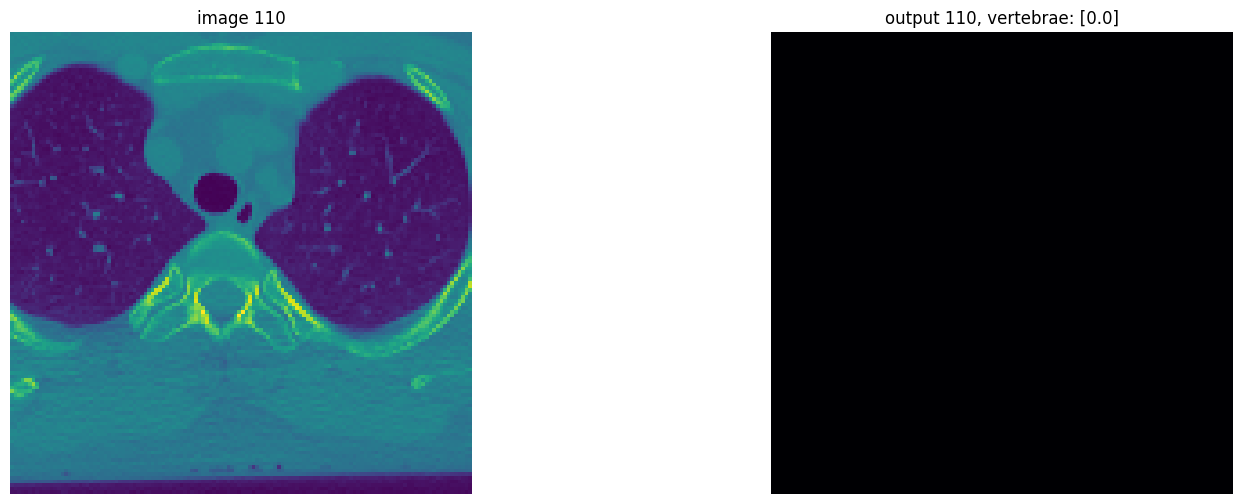

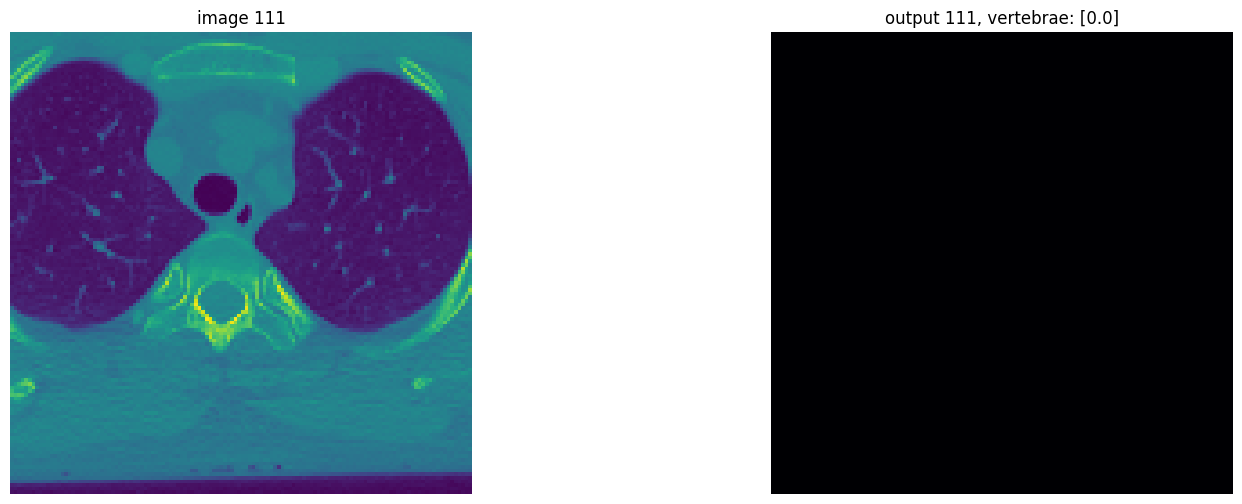

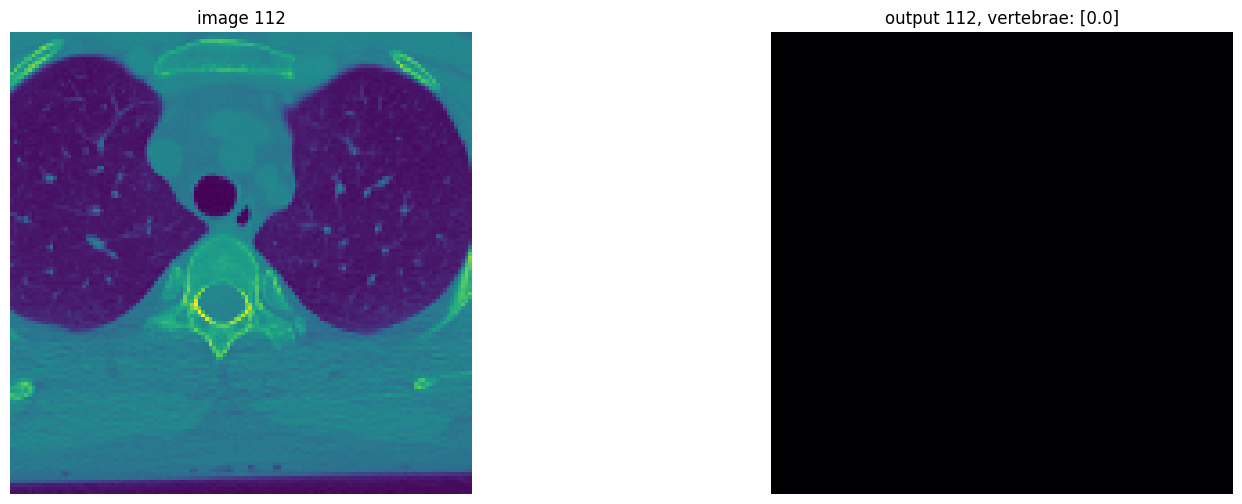

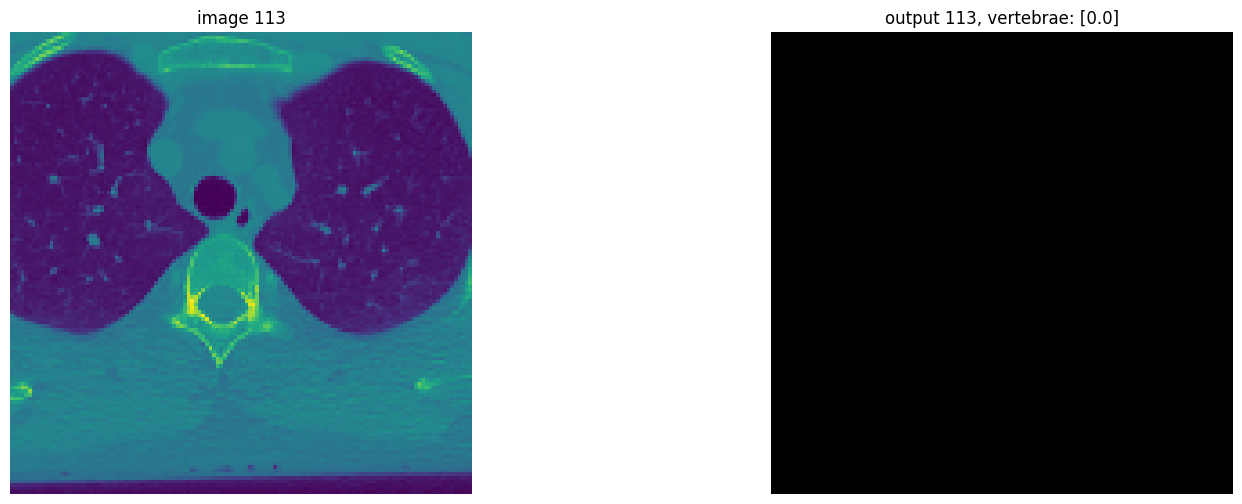

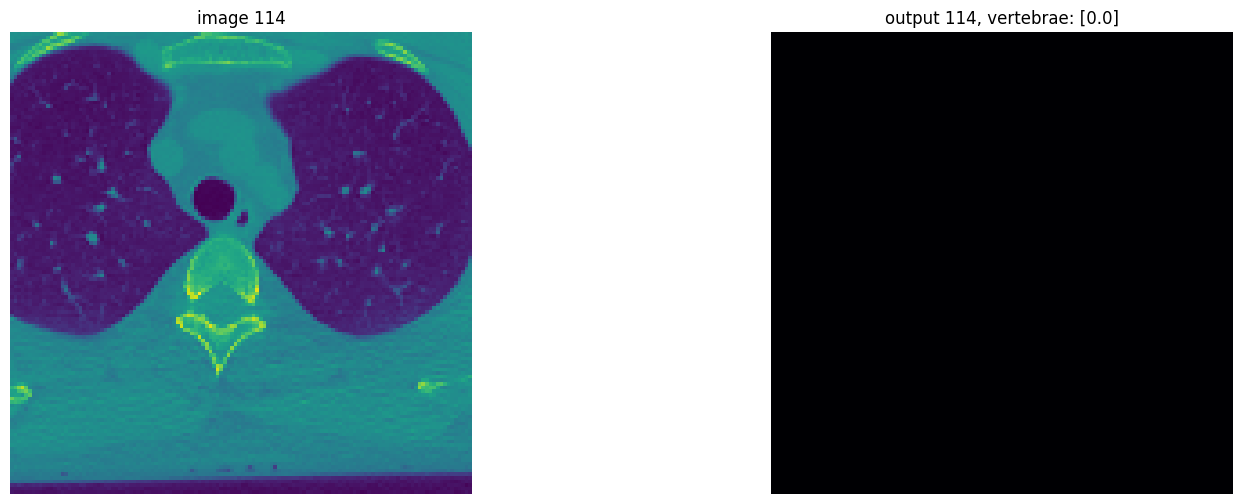

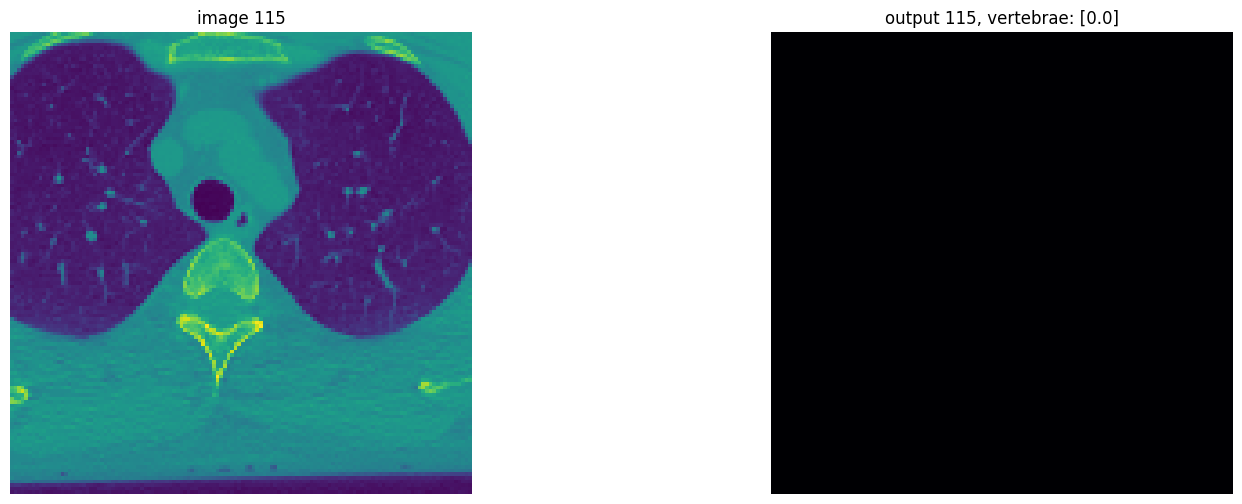

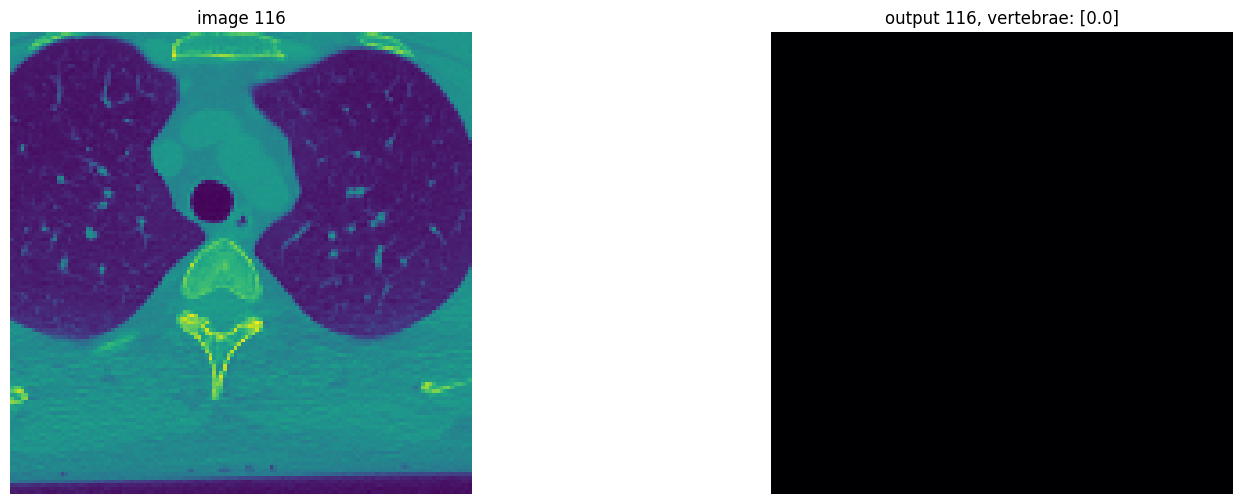

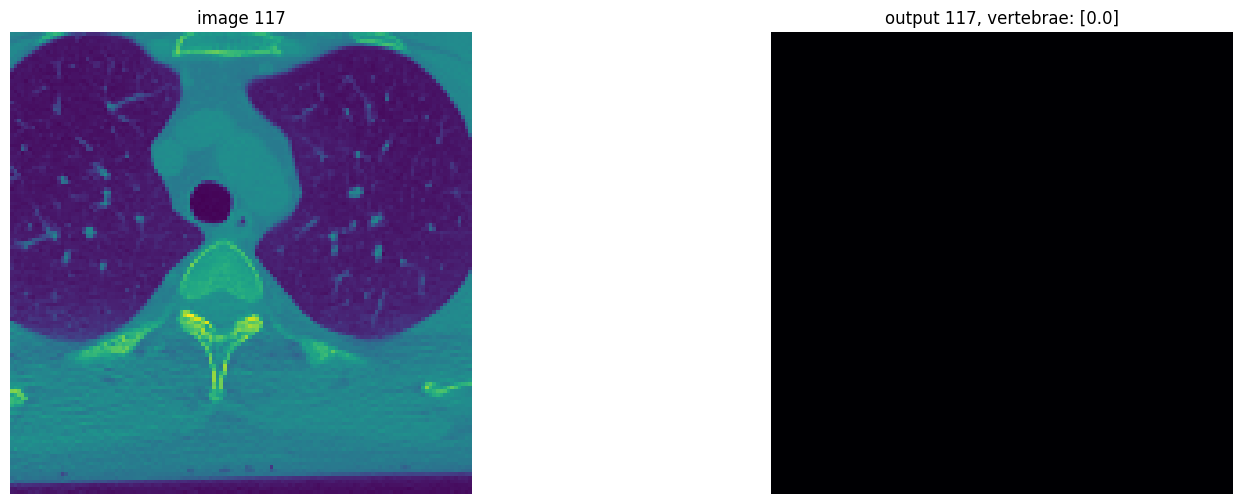

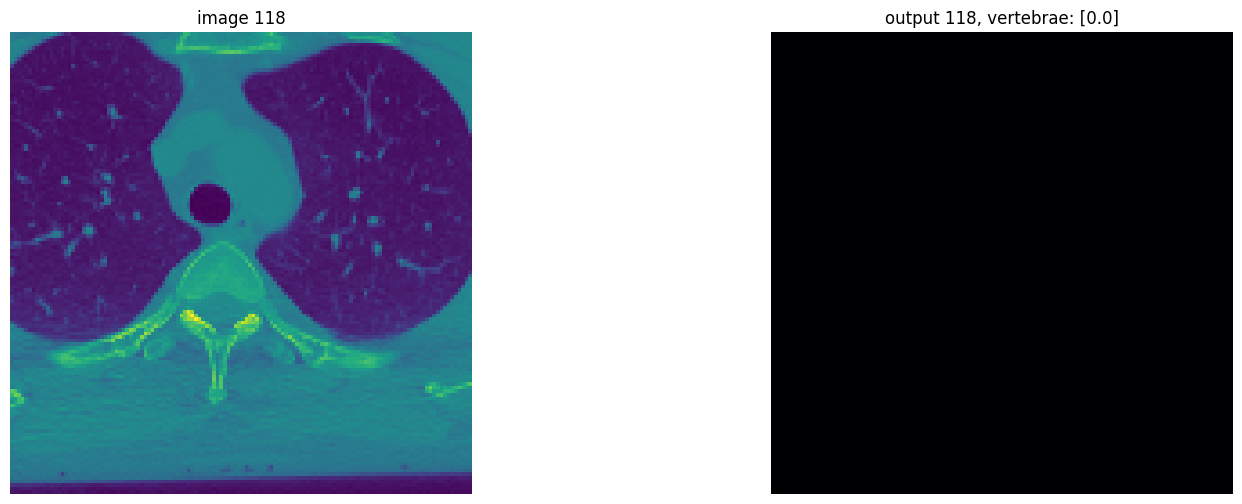

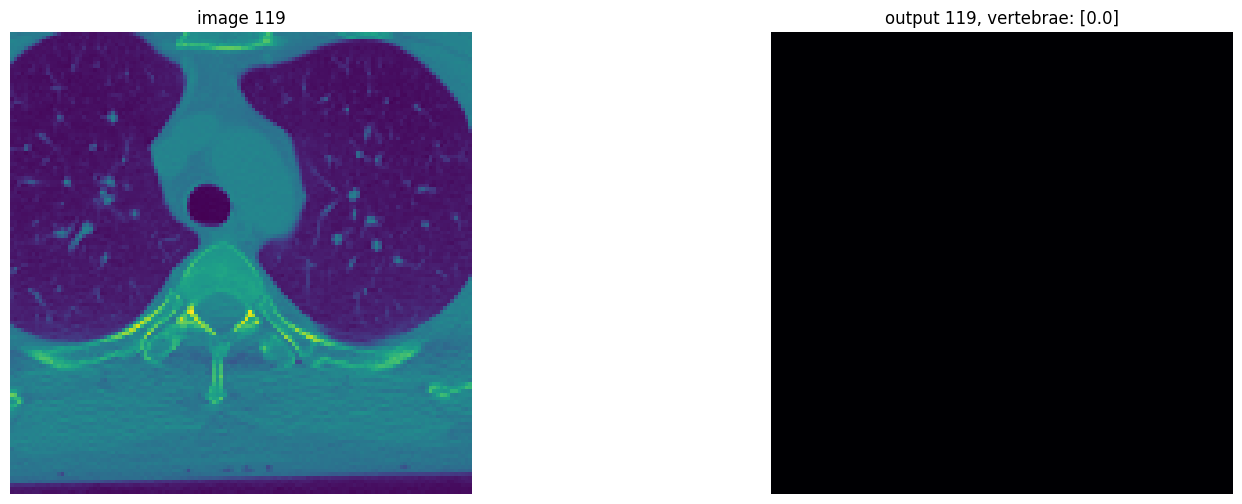

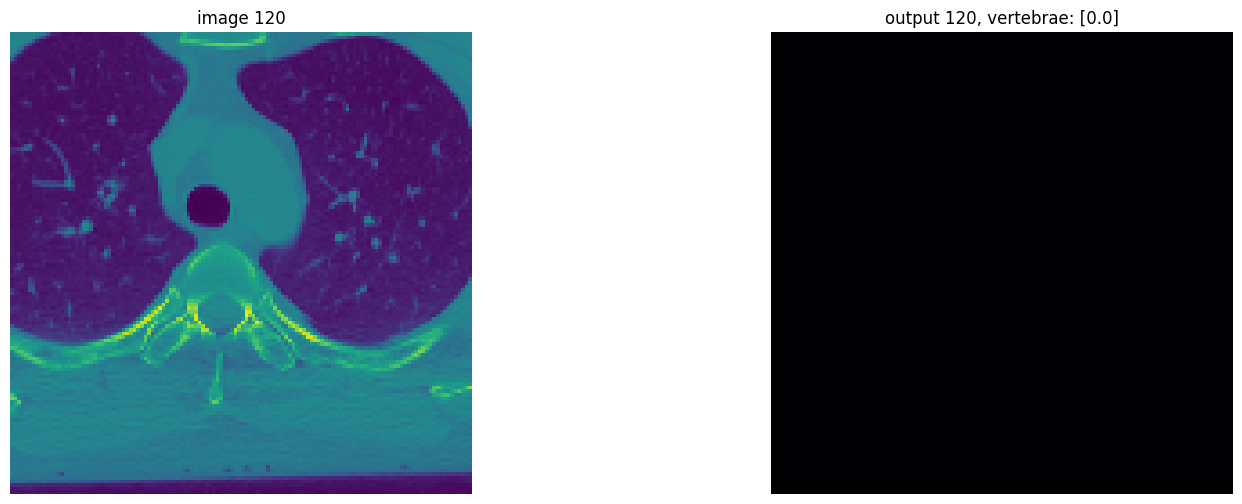

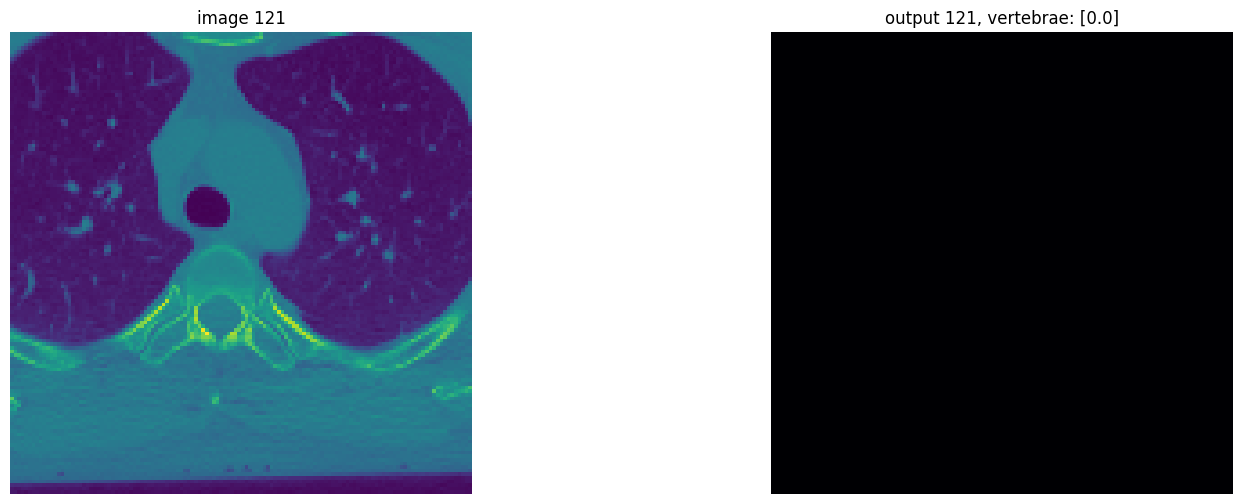

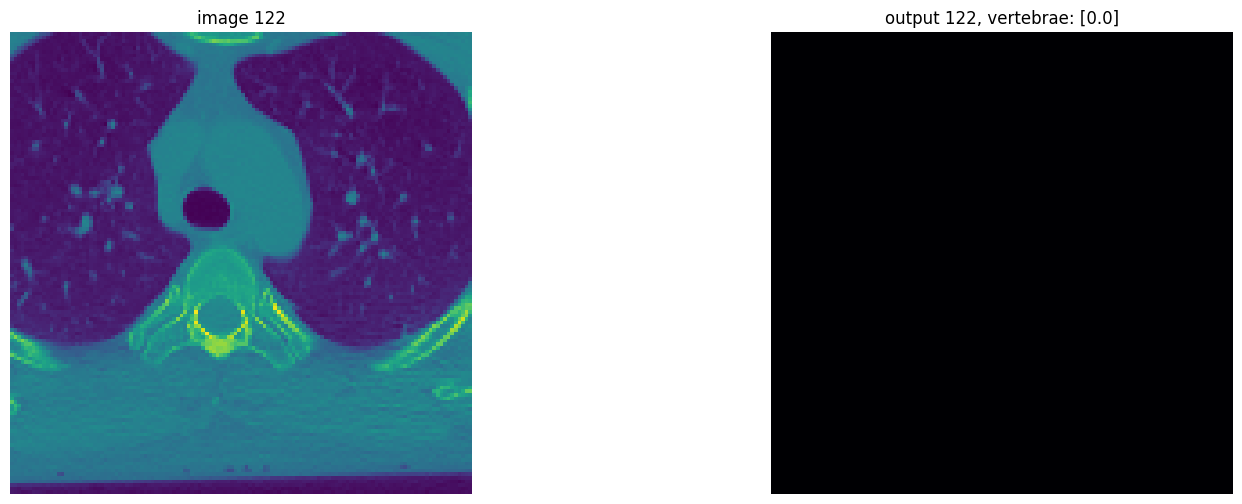

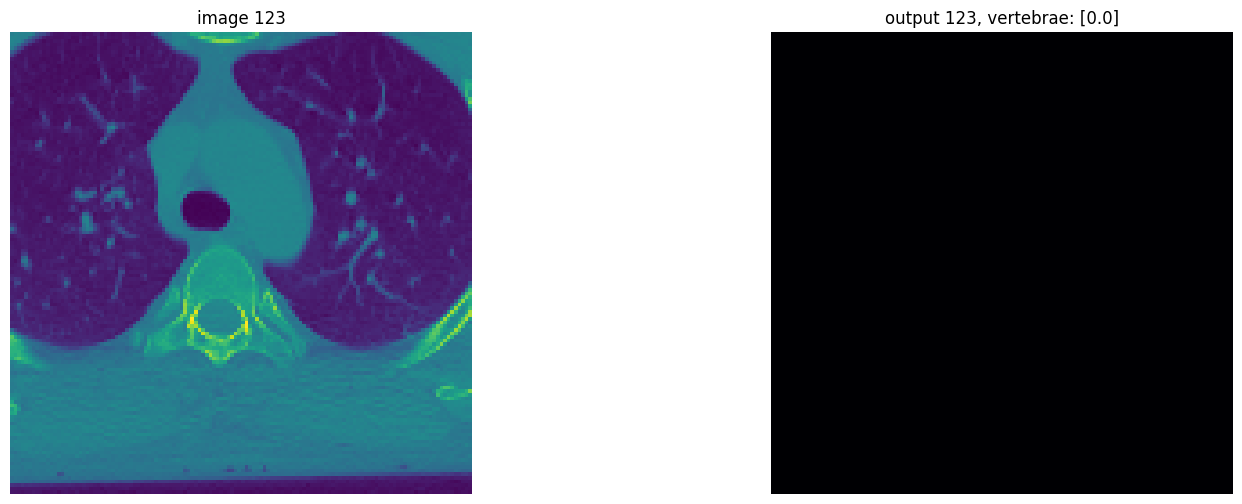

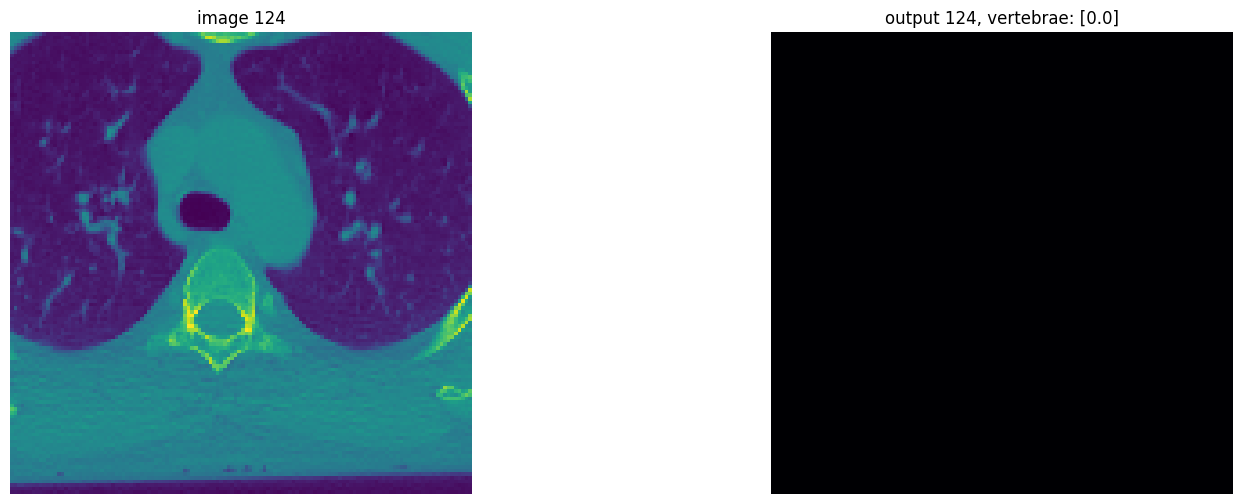

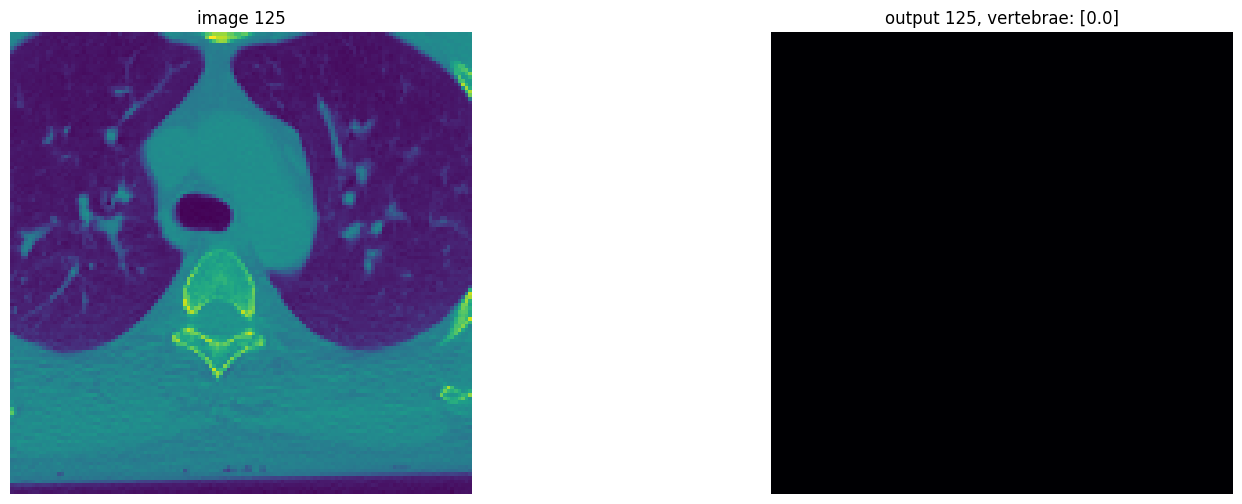

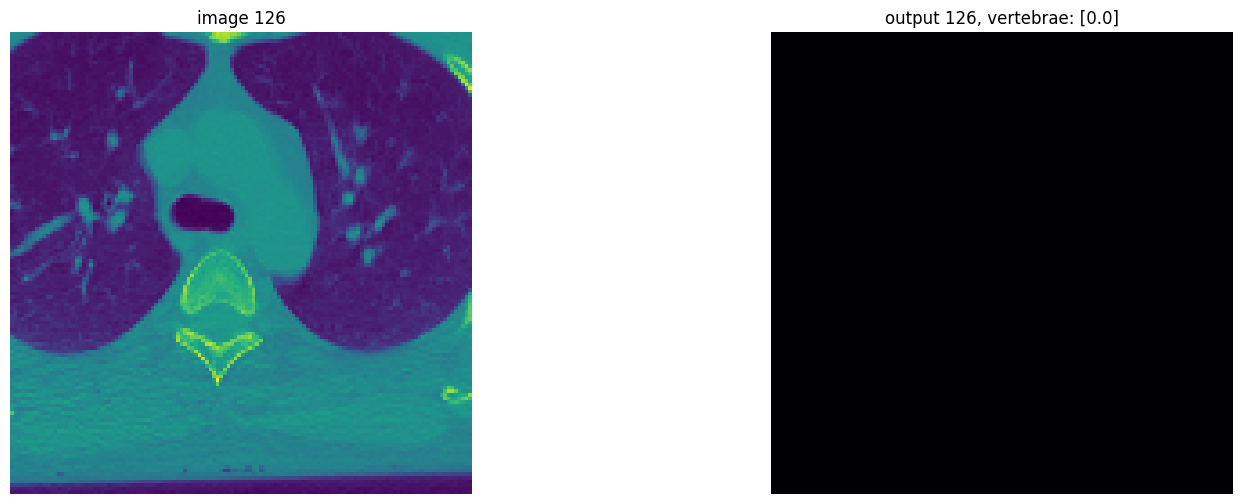

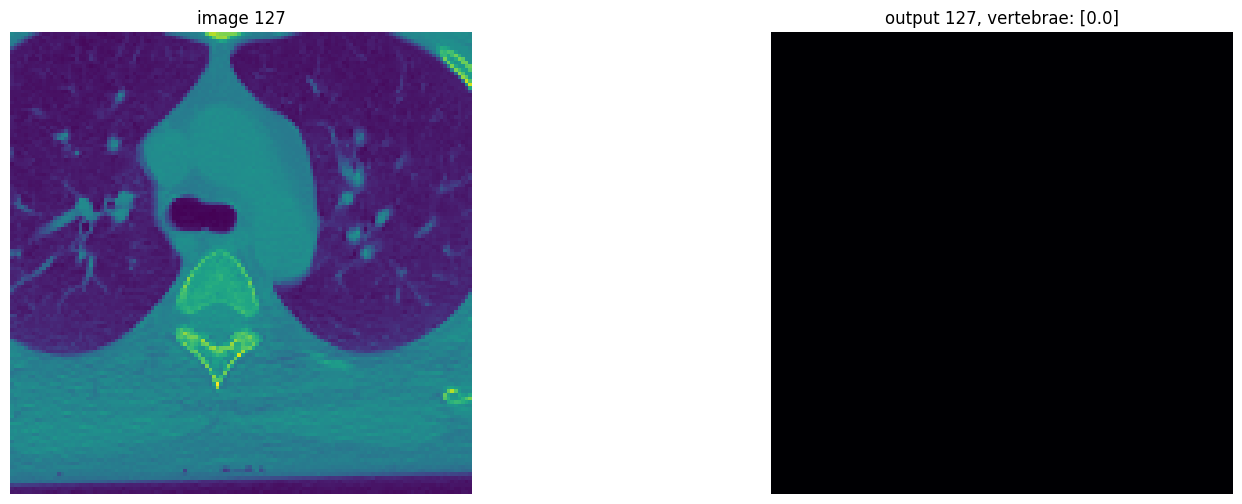

In [23]:
# Plot predicted mask of patient 

for i in range(128):
    plt.figure("check", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"image {i}")
    plt.imshow(patient_scan[0, :, :, i])
    plt.grid(False)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(f"output {i}, vertebrae: {list(np.unique(mask[0, :, :, i]))}")
    plt.imshow(mask[0, :, :, i], cmap=plt.cm.inferno)
    plt.grid(False)
    plt.axis('off')
    plt.show()